# Overview of this jupyter notebook

1. Loading the data
2. Optimize 1D-CNN Model for Multi-Label Classification with Optuna Random Sampler
3. Evaluation of the optimized model and saving the results

In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold, cross_validate
from sklearn.model_selection import cross_val_predict
from sklearn.utils import shuffle
import pickle
import json
import random
import optuna
import logging
import sys

In [2]:
import tensorflow as tf
from tensorflow import keras
import keras_tuner as kt
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.models import Sequential, clone_model, load_model
from tensorflow.keras.layers import Dense, Conv1D, Flatten, MaxPooling1D, Dropout, Input, BatchNormalization
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Adamax
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.backend import clear_session
from tqdm.notebook import tqdm_notebook as tq
from warnings import filterwarnings
filterwarnings('ignore')

In [3]:
import os
import importlib
from library import faps_color as fapsc        # this module contains the color combination of FAPS Institute
from library import classification_helper as ch  # this module contains helper functions for the classification task
print(importlib.reload(fapsc))
print(importlib.reload(ch))

<module 'library.faps_color' from 'C:\\Users\\songs\\OneDrive\\Desktop\\0. MA_FAPS\\04_Code\\library\\faps_color.py'>
<module 'library.classification_helper' from 'C:\\Users\\songs\\OneDrive\\Desktop\\0. MA_FAPS\\04_Code\\library\\classification_helper.py'>


In [4]:
# GPU check

if len(tf.config.list_physical_devices('GPU')) > 0:
    print("TensorFlow version: ", tf.__version__)
    print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
    print("Name: ", tf.test.gpu_device_name())
else:
    print("TensorFlow version: ", tf.__version__)
    print("GPU is not available")

TensorFlow version:  2.8.0
Num GPUs Available:  1
Name:  /device:GPU:0


In [5]:
!python -V

Python 3.9.12


# 1. Loading the data

In [6]:
classes = ['0_in_ordnung',
           '1_kleine_durchgangsbohrung',
           '2_versetzte_fuegepartner',
           '3_unebene_fuegeflaeche',
           '4_span_im_gewinde',
           '5_verschmutzte_schraube',
           '6_fremdkoerper_am_gewindeende',
           '7_beschaedigte_schraube']

In [7]:
feature_train = np.load("feature_label/feature_train_mlc_v2.4.npy")
feature_train.shape

(1550, 920)

In [8]:
feature_test = np.load("feature_label/feature_test_mlc_v2.4.npy")
feature_test.shape

(750, 920)

In [9]:
label_train = np.load("feature_label/label_train_mlc_v2.4.npy")
label_train.shape

(1550, 8)

In [10]:
label_test = np.load("feature_label/label_test_mlc_v2.4.npy")
label_test.shape

(750, 8)

In [11]:
from sklearn.utils import shuffle

x_train, y_train = shuffle(feature_train, label_train, random_state=9)
x_test, y_test = shuffle(feature_test, label_test, random_state=9)

y_train = y_train.astype(np.int32)
y_test = y_test.astype(np.int32)
y_test

array([[0, 0, 1, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 1]])

In [12]:
y_train

array([[1, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 1, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0]])

In [13]:
max_train = np.load("dataframes/max_train.npy")
max_train

array(2.56704)

In [14]:
len_curve = 920
x_test = x_test.reshape(-1, len_curve, 1)

x_train.shape, x_test.shape

((1550, 920), (750, 920, 1))

# 2. Optimize 1D-CNN Model for Multi-Label Classification with Optuna Random Sampler

In [15]:
!optuna --version

optuna 3.1.0


In [19]:
def create_model(trial):
    
    filters = trial.suggest_int('filters', 16, 64, 16)
    kernel_size = trial.suggest_categorical('kernel_size', [4, 8, 12, 16])
    maxpool = trial.suggest_categorical('maxpool', [2, 3, 4])
    conv_layer = trial.suggest_int('conv_layer', 2, 4)
    bn_conv = trial.suggest_categorical('bn_conv', [True, False])
    bn_conv_position = trial.suggest_int('bn_conv_position', 1, conv_layer)
    dropout_rate = trial.suggest_categorical('dropout', [0.1, 0.2, 0.3, 0.4])
    dense_layer = trial.suggest_int('dense_layer', 1, 4)
    bn_dense = trial.suggest_categorical('bn_dense', [True, False])
    bn_dense_position = trial.suggest_int('bn_dense_position', 1, dense_layer)
    
    model = Sequential()
    
    for i in range(1, conv_layer+1):
        if i==1:
            model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation="relu", 
                             input_shape=(len_curve, 1)))
            model.add(MaxPooling1D(maxpool))
            if (bn_conv==1) & (bn_conv_position==1):
                model.add(BatchNormalization())
                dropout_conv = trial.suggest_categorical('dropout_conv', [True, False])
                if dropout_conv:
                    model.add(Dropout(dropout_rate))
        else:
            model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation="relu"))
            model.add(MaxPooling1D(maxpool))
            if (bn_conv==1) & (bn_conv_position==i):
                model.add(BatchNormalization())
                dropout_conv = trial.suggest_categorical('dropout_conv', [True, False])
                if dropout_conv:
                    model.add(Dropout(dropout_rate))
    
    model.add(Flatten())
    
    #global unit_list
    unit_list = [400]
    for j in range(1, dense_layer+1):

        unit = trial.suggest_int(f"unit{j}", 40, unit_list[-1], 40)
        unit_list.append(unit)
        model.add(Dense(unit, activation='relu'))
        if (bn_dense==1) & (bn_dense_position==j):
            model.add(BatchNormalization())
            dropout_dense = trial.suggest_categorical('dropout_dense', [True, False])
            if dropout_dense:
                model.add(Dropout(dropout_rate))
    
    model.add(Dense(8, activation='sigmoid'))
                      
    lr = trial.suggest_float('lr', 1e-4, 1e-2, log=True)
    model.compile(loss='binary_crossentropy', optimizer=Adam(lr=lr), metrics=['accuracy'])
                      
    return model


In [20]:
def add_augmented_data(val_feat, val_label, augmentation_number, std=0.001):
    
    val_feat_aug = val_feat
    val_label_aug = val_label
    
    for i in range(augmentation_number):
        np.random.seed(i)
        noise = np.random.normal(0, std, val_feat.shape)
        augmented_data = val_feat + noise
        augmented_data[augmented_data<0] = 0
        val_feat_aug = np.concatenate((val_feat_aug, augmented_data), axis=0)
        val_label_aug = np.concatenate((val_label_aug, val_label), axis=0)

    print(val_feat_aug.shape, val_label_aug.shape)
    return val_feat_aug, val_label_aug

In [21]:
def objective(trial):
    
    tf.keras.backend.clear_session()
    kf = KFold(n_splits=4)
    acc_list=[]
    
    try:
        for j, (train_index, val_index) in enumerate(kf.split(x_train)):
            print(f"fold {j} start")
            xtrain, xval = x_train[train_index], x_train[val_index]
            ytrain, yval = y_train[train_index], y_train[val_index]

            xtrain_aug, ytrain_aug = add_augmented_data(xtrain, ytrain, augmentation_number=3)
            xtrain_aug, ytrain_aug = shuffle(xtrain_aug, ytrain_aug, random_state=9)
            xtrain_aug = xtrain_aug.reshape(-1, len_curve, 1)

            model = create_model(trial)
            if j ==0:
                print(model.summary())

            batch_size = trial.suggest_categorical('batch_size', [8, 16, 32, 64, 128])
            print(f"batch_size: {batch_size}")
            model.fit(xtrain_aug, ytrain_aug, epochs=100, batch_size=batch_size, validation_split=0.2, verbose=0,
                      callbacks=[EarlyStopping(monitor='val_loss', patience=10, verbose=1)])

            xvalpred = ch.make_pred_mlc(model.predict(xval), threshold=0.5)
            acc = accuracy_score(yval, xvalpred)
            acc_list.append(acc)
            print(acc)
            print(f"fold {j} end")
    except:
        print(f"##### exception occured ###### \n")
        acc_list = [x*0 for x in range(kf.n_splits)]
    
    print(f"length: {len(acc_list)}, {acc_list}")
    return np.mean(acc_list)

In [22]:
from optuna.samplers import RandomSampler

study = optuna.create_study(sampler=RandomSampler(seed=9), direction='maximize')
study.optimize(objective, n_trials=300)

[I 2023-02-06 23:32:40,807] A new study created in memory with name: no-name-95940389-e0bd-46f3-88e1-2669adb509e6


fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 917, 16)           80        
                                                                 
 max_pooling1d (MaxPooling1D  (None, 305, 16)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 302, 16)           1040      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 100, 16)          0         
 1D)                                                             
                                                                 
 batch_normalization (BatchN  (None, 100, 16)          64        
 ormalization)                                                   
                     

[I 2023-02-06 23:35:04,859] Trial 0 finished with value: 0.7210734169796744 and parameters: {'filters': 16, 'kernel_size': 4, 'maxpool': 3, 'conv_layer': 2, 'bn_conv': True, 'bn_conv_position': 2, 'dropout': 0.1, 'dense_layer': 4, 'bn_dense': True, 'bn_dense_position': 3, 'dropout_conv': False, 'unit1': 360, 'unit2': 200, 'unit3': 200, 'dropout_dense': False, 'unit4': 40, 'lr': 0.001101969115631023, 'batch_size': 64}. Best is trial 0 with value: 0.7210734169796744.


0.8552971576227391
fold 3 end
length: 4, [0.8865979381443299, 0.8917525773195877, 0.25064599483204136, 0.8552971576227391]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 913, 16)           144       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 304, 16)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 297, 16)           2064      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 99, 16)           0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (

[I 2023-02-06 23:37:26,605] Trial 1 finished with value: 0.8935473773941767 and parameters: {'filters': 16, 'kernel_size': 8, 'maxpool': 3, 'conv_layer': 3, 'bn_conv': False, 'bn_conv_position': 1, 'dropout': 0.3, 'dense_layer': 3, 'bn_dense': True, 'bn_dense_position': 1, 'unit1': 40, 'dropout_dense': False, 'unit2': 40, 'unit3': 40, 'lr': 0.00021145214406089556, 'batch_size': 128}. Best is trial 1 with value: 0.8935473773941767.


0.8863049095607235
fold 3 end
length: 4, [0.9020618556701031, 0.8865979381443299, 0.8992248062015504, 0.8863049095607235]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 917, 32)           160       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 229, 32)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 226, 32)           4128      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 56, 32)           0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (N

[I 2023-02-06 23:40:28,064] Trial 2 finished with value: 0.9109725885079517 and parameters: {'filters': 32, 'kernel_size': 4, 'maxpool': 4, 'conv_layer': 3, 'bn_conv': False, 'bn_conv_position': 1, 'dropout': 0.1, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'unit1': 400, 'dropout_dense': True, 'unit2': 280, 'lr': 0.0009635136653716702, 'batch_size': 32}. Best is trial 2 with value: 0.9109725885079517.


0.9198966408268734
fold 3 end
length: 4, [0.9149484536082474, 0.8994845360824743, 0.9095607235142119, 0.9198966408268734]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 917, 32)           160       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 458, 32)          0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 458, 32)          128       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 458, 32)           0         
                                                                 
 conv1d_1 (Conv1D)           (N

[I 2023-02-06 23:43:08,138] Trial 3 finished with value: 0.8806457950398252 and parameters: {'filters': 32, 'kernel_size': 4, 'maxpool': 2, 'conv_layer': 2, 'bn_conv': True, 'bn_conv_position': 1, 'dropout': 0.2, 'dense_layer': 3, 'bn_dense': False, 'bn_dense_position': 2, 'dropout_conv': True, 'unit1': 400, 'unit2': 120, 'unit3': 80, 'lr': 0.0010268130197329398, 'batch_size': 32}. Best is trial 2 with value: 0.9109725885079517.


0.8733850129198967
fold 3 end
length: 4, [0.865979381443299, 0.8943298969072165, 0.8888888888888888, 0.8733850129198967]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 909, 16)           208       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 454, 16)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 443, 16)           3088      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 221, 16)          0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (No

[I 2023-02-07 00:02:23,276] Trial 4 finished with value: 0.8896714084019287 and parameters: {'filters': 16, 'kernel_size': 12, 'maxpool': 2, 'conv_layer': 4, 'bn_conv': False, 'bn_conv_position': 4, 'dropout': 0.3, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 2, 'unit1': 240, 'unit2': 120, 'dropout_dense': False, 'lr': 0.00014469948551492246, 'batch_size': 8}. Best is trial 2 with value: 0.9109725885079517.


fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 905, 64)           1088      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 301, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 286, 64)           65600     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 95, 64)           0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 80, 64)            65600     
                                                                 
 max_pooling1d_2 (Max

[I 2023-02-07 00:04:41,537] Trial 5 finished with value: 0.883835810756813 and parameters: {'filters': 64, 'kernel_size': 16, 'maxpool': 3, 'conv_layer': 4, 'bn_conv': False, 'bn_conv_position': 2, 'dropout': 0.1, 'dense_layer': 3, 'bn_dense': True, 'bn_dense_position': 1, 'unit1': 200, 'dropout_dense': True, 'unit2': 200, 'unit3': 120, 'lr': 0.0002269556090951163, 'batch_size': 128}. Best is trial 2 with value: 0.9109725885079517.


0.8191214470284238
fold 3 end
length: 4, [0.9175257731958762, 0.904639175257732, 0.8940568475452196, 0.8191214470284238]
fold 0 start
(4648, 920) (4648, 8)


[I 2023-02-07 00:04:41,796] Trial 6 finished with value: 0.0 and parameters: {'filters': 32, 'kernel_size': 16, 'maxpool': 4, 'conv_layer': 4, 'bn_conv': True, 'bn_conv_position': 3, 'dropout': 0.1, 'dense_layer': 1, 'bn_dense': False, 'bn_dense_position': 1, 'dropout_conv': False}. Best is trial 2 with value: 0.9109725885079517.


##### exception occured ###### 

length: 4, [0, 0, 0, 0]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 905, 32)           544       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 226, 32)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 211, 32)           16416     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 52, 32)           0         
 1D)                                                             
                                                                 
 flatten (Flatten)           (None, 1664)              0         
                              

[I 2023-02-07 00:07:31,764] Trial 7 finished with value: 0.8858020991502171 and parameters: {'filters': 32, 'kernel_size': 16, 'maxpool': 4, 'conv_layer': 2, 'bn_conv': False, 'bn_conv_position': 1, 'dropout': 0.2, 'dense_layer': 2, 'bn_dense': False, 'bn_dense_position': 1, 'unit1': 200, 'unit2': 40, 'lr': 0.004291131297509101, 'batch_size': 64}. Best is trial 2 with value: 0.9109725885079517.


0.875968992248062
fold 3 end
length: 4, [0.8814432989690721, 0.8969072164948454, 0.8888888888888888, 0.875968992248062]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 917, 64)           320       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 458, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 455, 64)           16448     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 227, 64)          0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (Non

[I 2023-02-07 00:08:39,612] Trial 8 finished with value: 0.7051433176163457 and parameters: {'filters': 64, 'kernel_size': 4, 'maxpool': 2, 'conv_layer': 3, 'bn_conv': False, 'bn_conv_position': 1, 'dropout': 0.1, 'dense_layer': 4, 'bn_dense': True, 'bn_dense_position': 2, 'unit1': 120, 'unit2': 120, 'dropout_dense': True, 'unit3': 40, 'unit4': 40, 'lr': 0.006855084861357428, 'batch_size': 128}. Best is trial 2 with value: 0.9109725885079517.


fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 917, 32)           160       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 229, 32)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 226, 32)           4128      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 56, 32)           0         
 1D)                                                             
                                                                 
 flatten (Flatten)           (None, 1792)              0         
                                                                 
 dense (Dense)       

[I 2023-02-07 00:18:21,024] Trial 9 finished with value: 0.8780601507765258 and parameters: {'filters': 32, 'kernel_size': 4, 'maxpool': 4, 'conv_layer': 2, 'bn_conv': False, 'bn_conv_position': 2, 'dropout': 0.1, 'dense_layer': 3, 'bn_dense': False, 'bn_dense_position': 1, 'unit1': 240, 'unit2': 120, 'unit3': 40, 'lr': 0.0005615576317487957, 'batch_size': 16}. Best is trial 2 with value: 0.9109725885079517.


0.8527131782945736
fold 3 end
length: 4, [0.8814432989690721, 0.8814432989690721, 0.896640826873385, 0.8527131782945736]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 905, 32)           544       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 452, 32)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 437, 32)           16416     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 218, 32)          0         
 1D)                                                             
                                                                 
 batch_normalization (BatchN  (N

[I 2023-02-07 00:24:15,168] Trial 10 finished with value: 0.8851544393830416 and parameters: {'filters': 32, 'kernel_size': 16, 'maxpool': 2, 'conv_layer': 2, 'bn_conv': True, 'bn_conv_position': 2, 'dropout': 0.4, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_conv': True, 'unit1': 320, 'dropout_dense': False, 'unit2': 240, 'lr': 0.000996512258210049, 'batch_size': 16}. Best is trial 2 with value: 0.9109725885079517.


fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 917, 48)           240       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 305, 48)          0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 305, 48)          192       
 ormalization)                                                   
                                                                 
 conv1d_1 (Conv1D)           (None, 302, 48)           9264      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 100, 48)          0         
 1D)                                                             
                     

[I 2023-02-07 00:35:11,674] Trial 11 finished with value: 0.8883694291270412 and parameters: {'filters': 48, 'kernel_size': 4, 'maxpool': 3, 'conv_layer': 4, 'bn_conv': True, 'bn_conv_position': 1, 'dropout': 0.4, 'dense_layer': 4, 'bn_dense': True, 'bn_dense_position': 2, 'dropout_conv': False, 'unit1': 240, 'unit2': 200, 'dropout_dense': False, 'unit3': 200, 'unit4': 80, 'lr': 0.004409056454849902, 'batch_size': 16}. Best is trial 2 with value: 0.9109725885079517.


0.8914728682170543
fold 3 end
length: 4, [0.9123711340206185, 0.8917525773195877, 0.8578811369509044, 0.8914728682170543]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 913, 32)           288       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 304, 32)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 297, 32)           8224      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 99, 32)           0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (N

[I 2023-02-07 00:37:03,488] Trial 12 finished with value: 0.8961130424358668 and parameters: {'filters': 32, 'kernel_size': 8, 'maxpool': 3, 'conv_layer': 3, 'bn_conv': False, 'bn_conv_position': 1, 'dropout': 0.3, 'dense_layer': 4, 'bn_dense': False, 'bn_dense_position': 4, 'unit1': 240, 'unit2': 160, 'unit3': 40, 'unit4': 40, 'lr': 0.0014656376511163669, 'batch_size': 128}. Best is trial 2 with value: 0.9109725885079517.


0.8914728682170543
fold 3 end
length: 4, [0.9123711340206185, 0.904639175257732, 0.875968992248062, 0.8914728682170543]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 905, 32)           544       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 452, 32)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 437, 32)           16416     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 218, 32)          0         
 1D)                                                             
                                                                 
 batch_normalization (BatchN  (No

[I 2023-02-07 00:49:49,086] Trial 13 finished with value: 0.8948377021231253 and parameters: {'filters': 32, 'kernel_size': 16, 'maxpool': 2, 'conv_layer': 3, 'bn_conv': True, 'bn_conv_position': 2, 'dropout': 0.1, 'dense_layer': 1, 'bn_dense': False, 'bn_dense_position': 1, 'dropout_conv': False, 'unit1': 320, 'lr': 0.00015928782924019293, 'batch_size': 8}. Best is trial 2 with value: 0.9109725885079517.


0.8837209302325582
fold 3 end
length: 4, [0.884020618556701, 0.9072164948453608, 0.9043927648578811, 0.8837209302325582]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 917, 48)           240       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 305, 48)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 302, 48)           9264      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 100, 48)          0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (No

[I 2023-02-07 00:55:55,432] Trial 14 finished with value: 0.8922537227949598 and parameters: {'filters': 48, 'kernel_size': 4, 'maxpool': 3, 'conv_layer': 4, 'bn_conv': False, 'bn_conv_position': 4, 'dropout': 0.1, 'dense_layer': 4, 'bn_dense': False, 'bn_dense_position': 2, 'unit1': 40, 'unit2': 40, 'unit3': 40, 'unit4': 40, 'lr': 0.0006474710782080154, 'batch_size': 32}. Best is trial 2 with value: 0.9109725885079517.


0.8992248062015504
fold 3 end
length: 4, [0.8943298969072165, 0.8969072164948454, 0.8785529715762274, 0.8992248062015504]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 905, 48)           816       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 226, 48)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 211, 48)           36912     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 52, 48)           0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (N

[I 2023-02-07 01:01:51,905] Trial 15 finished with value: 0.8858054290204853 and parameters: {'filters': 48, 'kernel_size': 16, 'maxpool': 4, 'conv_layer': 3, 'bn_conv': False, 'bn_conv_position': 2, 'dropout': 0.2, 'dense_layer': 1, 'bn_dense': True, 'bn_dense_position': 1, 'unit1': 400, 'dropout_dense': False, 'lr': 0.003063462822208888, 'batch_size': 16}. Best is trial 2 with value: 0.9109725885079517.


0.8527131782945736
fold 3 end
length: 4, [0.8762886597938144, 0.8969072164948454, 0.917312661498708, 0.8527131782945736]
fold 0 start
(4648, 920) (4648, 8)


[I 2023-02-07 01:01:52,124] Trial 16 finished with value: 0.0 and parameters: {'filters': 16, 'kernel_size': 16, 'maxpool': 4, 'conv_layer': 4, 'bn_conv': False, 'bn_conv_position': 4, 'dropout': 0.2, 'dense_layer': 3, 'bn_dense': False, 'bn_dense_position': 1}. Best is trial 2 with value: 0.9109725885079517.


##### exception occured ###### 

length: 4, [0, 0, 0, 0]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 913, 48)           432       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 228, 48)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 221, 48)           18480     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 55, 48)           0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 48, 48)            18480     
                              

[I 2023-02-07 01:06:52,658] Trial 17 finished with value: 0.9135499080955807 and parameters: {'filters': 48, 'kernel_size': 8, 'maxpool': 4, 'conv_layer': 3, 'bn_conv': True, 'bn_conv_position': 3, 'dropout': 0.4, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 2, 'dropout_conv': False, 'unit1': 400, 'unit2': 80, 'dropout_dense': False, 'lr': 0.00010394738085563026, 'batch_size': 64}. Best is trial 17 with value: 0.9135499080955807.


0.9018087855297158
fold 3 end
length: 4, [0.8994845360824743, 0.9252577319587629, 0.9276485788113695, 0.9018087855297158]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 917, 32)           160       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 229, 32)          0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 229, 32)          128       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 229, 32)           0         
                                                                 
 conv1d_1 (Conv1D)           (N

[I 2023-02-07 01:11:29,950] Trial 18 finished with value: 0.8786961559977623 and parameters: {'filters': 32, 'kernel_size': 4, 'maxpool': 4, 'conv_layer': 4, 'bn_conv': True, 'bn_conv_position': 1, 'dropout': 0.1, 'dense_layer': 3, 'bn_dense': False, 'bn_dense_position': 1, 'dropout_conv': True, 'unit1': 80, 'unit2': 40, 'unit3': 40, 'lr': 0.0002543209464594231, 'batch_size': 64}. Best is trial 17 with value: 0.9135499080955807.


0.8733850129198967
fold 3 end
length: 4, [0.8865979381443299, 0.8917525773195877, 0.8630490956072352, 0.8733850129198967]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 905, 64)           1088      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 226, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 211, 64)           65600     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 52, 64)           0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (N

[I 2023-02-07 01:20:22,001] Trial 19 finished with value: 0.9019253309891047 and parameters: {'filters': 64, 'kernel_size': 16, 'maxpool': 4, 'conv_layer': 3, 'bn_conv': False, 'bn_conv_position': 1, 'dropout': 0.2, 'dense_layer': 3, 'bn_dense': False, 'bn_dense_position': 3, 'unit1': 240, 'unit2': 40, 'unit3': 40, 'lr': 0.0002041458599770035, 'batch_size': 16}. Best is trial 17 with value: 0.9135499080955807.


fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 909, 16)           208       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 454, 16)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 443, 16)           3088      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 221, 16)          0         
 1D)                                                             
                                                                 
 batch_normalization (BatchN  (None, 221, 16)          64        
 ormalization)                                                   
                     

[I 2023-02-07 01:22:28,939] Trial 20 finished with value: 0.8767764857881136 and parameters: {'filters': 16, 'kernel_size': 12, 'maxpool': 2, 'conv_layer': 2, 'bn_conv': True, 'bn_conv_position': 2, 'dropout': 0.1, 'dense_layer': 3, 'bn_dense': False, 'bn_dense_position': 2, 'dropout_conv': True, 'unit1': 120, 'unit2': 40, 'unit3': 40, 'lr': 0.00015167028113882141, 'batch_size': 128}. Best is trial 17 with value: 0.9135499080955807.


0.8733850129198967
fold 3 end
length: 4, [0.8814432989690721, 0.8685567010309279, 0.8837209302325582, 0.8733850129198967]
fold 0 start
(4648, 920) (4648, 8)


[I 2023-02-07 01:22:29,142] Trial 21 finished with value: 0.0 and parameters: {'filters': 64, 'kernel_size': 12, 'maxpool': 4, 'conv_layer': 4, 'bn_conv': False, 'bn_conv_position': 1, 'dropout': 0.2, 'dense_layer': 1, 'bn_dense': True, 'bn_dense_position': 1}. Best is trial 17 with value: 0.9135499080955807.


##### exception occured ###### 

length: 4, [0, 0, 0, 0]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 913, 32)           288       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 228, 32)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 221, 32)           8224      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 55, 32)           0         
 1D)                                                             
                                                                 
 batch_normalization (BatchN  (None, 55, 32)           128       
 ormalization)                

[I 2023-02-07 01:27:39,105] Trial 22 finished with value: 0.7987642851434508 and parameters: {'filters': 32, 'kernel_size': 8, 'maxpool': 4, 'conv_layer': 4, 'bn_conv': True, 'bn_conv_position': 2, 'dropout': 0.4, 'dense_layer': 4, 'bn_dense': False, 'bn_dense_position': 4, 'dropout_conv': True, 'unit1': 400, 'unit2': 120, 'unit3': 40, 'unit4': 40, 'lr': 0.007661860922089041, 'batch_size': 16}. Best is trial 17 with value: 0.9135499080955807.


0.8552971576227391
fold 3 end
length: 4, [0.8427835051546392, 0.6701030927835051, 0.8268733850129198, 0.8552971576227391]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 909, 16)           208       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 303, 16)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 292, 16)           3088      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 97, 16)           0         
 1D)                                                             
                                                                 
 flatten (Flatten)           (N

[I 2023-02-07 01:32:42,438] Trial 23 finished with value: 0.8761288260209382 and parameters: {'filters': 16, 'kernel_size': 12, 'maxpool': 3, 'conv_layer': 2, 'bn_conv': False, 'bn_conv_position': 1, 'dropout': 0.1, 'dense_layer': 4, 'bn_dense': False, 'bn_dense_position': 1, 'unit1': 40, 'unit2': 40, 'unit3': 40, 'unit4': 40, 'lr': 0.0016744454906543163, 'batch_size': 32}. Best is trial 17 with value: 0.9135499080955807.


0.8708010335917312
fold 3 end
length: 4, [0.8814432989690721, 0.8711340206185567, 0.8811369509043928, 0.8708010335917312]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 913, 16)           144       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 228, 16)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 221, 16)           2064      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 55, 16)           0         
 1D)                                                             
                                                                 
 batch_normalization (BatchN  (

[I 2023-02-07 01:41:22,058] Trial 24 finished with value: 0.8851610991235781 and parameters: {'filters': 16, 'kernel_size': 8, 'maxpool': 4, 'conv_layer': 2, 'bn_conv': True, 'bn_conv_position': 2, 'dropout': 0.2, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 2, 'dropout_conv': True, 'unit1': 40, 'unit2': 40, 'dropout_dense': False, 'lr': 0.0004799668203904299, 'batch_size': 16}. Best is trial 17 with value: 0.9135499080955807.


0.8914728682170543
fold 3 end
length: 4, [0.8865979381443299, 0.884020618556701, 0.8785529715762274, 0.8914728682170543]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 905, 32)           544       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 226, 32)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 211, 32)           16416     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 52, 32)           0         
 1D)                                                             
                                                                 
 batch_normalization (BatchN  (N

[I 2023-02-07 02:02:51,776] Trial 25 finished with value: 0.9135365886145076 and parameters: {'filters': 32, 'kernel_size': 16, 'maxpool': 4, 'conv_layer': 3, 'bn_conv': True, 'bn_conv_position': 2, 'dropout': 0.4, 'dense_layer': 3, 'bn_dense': True, 'bn_dense_position': 2, 'dropout_conv': True, 'unit1': 80, 'unit2': 40, 'dropout_dense': False, 'unit3': 40, 'lr': 0.009876962945511918, 'batch_size': 8}. Best is trial 17 with value: 0.9135499080955807.


0.8785529715762274
fold 3 end
length: 4, [0.9510309278350515, 0.8943298969072165, 0.9302325581395349, 0.8785529715762274]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 905, 48)           816       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 301, 48)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 286, 48)           36912     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 95, 48)           0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (N

[I 2023-02-07 02:09:49,531] Trial 26 finished with value: 0.8728871973147926 and parameters: {'filters': 48, 'kernel_size': 16, 'maxpool': 3, 'conv_layer': 3, 'bn_conv': False, 'bn_conv_position': 1, 'dropout': 0.3, 'dense_layer': 1, 'bn_dense': True, 'bn_dense_position': 1, 'unit1': 240, 'dropout_dense': True, 'lr': 0.004538736756692194, 'batch_size': 16}. Best is trial 17 with value: 0.9135499080955807.


0.8397932816537468
fold 3 end
length: 4, [0.8917525773195877, 0.8788659793814433, 0.8811369509043928, 0.8397932816537468]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 905, 48)           816       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 452, 48)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 437, 48)           36912     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 218, 48)          0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (N

[I 2023-02-07 02:20:49,747] Trial 27 finished with value: 0.8916177175737233 and parameters: {'filters': 48, 'kernel_size': 16, 'maxpool': 2, 'conv_layer': 3, 'bn_conv': False, 'bn_conv_position': 1, 'dropout': 0.3, 'dense_layer': 3, 'bn_dense': True, 'bn_dense_position': 2, 'unit1': 360, 'unit2': 160, 'dropout_dense': False, 'unit3': 160, 'lr': 0.0008163394841731515, 'batch_size': 8}. Best is trial 17 with value: 0.9135499080955807.



fold 3 end
length: 4, [0.8737113402061856, 0.9020618556701031, 0.9121447028423773, 0.8785529715762274]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 905, 64)           1088      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 301, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 286, 64)           65600     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 95, 64)           0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 80, 64)      

[I 2023-02-07 02:24:08,139] Trial 28 finished with value: 0.9135615626415196 and parameters: {'filters': 64, 'kernel_size': 16, 'maxpool': 3, 'conv_layer': 3, 'bn_conv': False, 'bn_conv_position': 1, 'dropout': 0.1, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'unit1': 200, 'dropout_dense': True, 'unit2': 80, 'lr': 0.00019912422571313518, 'batch_size': 64}. Best is trial 28 with value: 0.9135615626415196.


0.917312661498708
fold 3 end
length: 4, [0.9072164948453608, 0.8994845360824743, 0.9302325581395349, 0.917312661498708]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 905, 48)           816       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 452, 48)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 437, 48)           36912     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 218, 48)          0         
 1D)                                                             
                                                                 
 batch_normalization (BatchN  (No

[I 2023-02-07 02:25:33,980] Trial 29 finished with value: 0.4451753509683263 and parameters: {'filters': 48, 'kernel_size': 16, 'maxpool': 2, 'conv_layer': 2, 'bn_conv': True, 'bn_conv_position': 2, 'dropout': 0.4, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 2, 'dropout_conv': True, 'unit1': 240, 'unit2': 120, 'dropout_dense': True, 'lr': 0.00027349016327173455, 'batch_size': 128}. Best is trial 28 with value: 0.9135615626415196.



fold 3 end
length: 4, [0.8247422680412371, 0.04381443298969072, 0.015503875968992248, 0.896640826873385]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 905, 48)           816       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 452, 48)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 437, 48)           36912     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 218, 48)          0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 203, 48)   

[I 2023-02-07 02:30:14,655] Trial 30 finished with value: 0.8954820320200325 and parameters: {'filters': 48, 'kernel_size': 16, 'maxpool': 2, 'conv_layer': 4, 'bn_conv': False, 'bn_conv_position': 3, 'dropout': 0.3, 'dense_layer': 2, 'bn_dense': False, 'bn_dense_position': 2, 'unit1': 240, 'unit2': 80, 'lr': 0.0012018882809821342, 'batch_size': 64}. Best is trial 28 with value: 0.9135615626415196.


0.8992248062015504
fold 3 end
length: 4, [0.884020618556701, 0.9097938144329897, 0.8888888888888888, 0.8992248062015504]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 913, 64)           576       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 456, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 449, 64)           32832     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 224, 64)          0         
 1D)                                                             
                                                                 
 batch_normalization (BatchN  (N

[I 2023-02-07 02:31:53,639] Trial 31 finished with value: 0.6365912784037935 and parameters: {'filters': 64, 'kernel_size': 8, 'maxpool': 2, 'conv_layer': 3, 'bn_conv': True, 'bn_conv_position': 2, 'dropout': 0.1, 'dense_layer': 1, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_conv': True, 'unit1': 360, 'dropout_dense': True, 'lr': 0.0008103352529695928, 'batch_size': 128}. Best is trial 28 with value: 0.9135615626415196.


fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 917, 32)           160       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 229, 32)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 226, 32)           4128      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 56, 32)           0         
 1D)                                                             
                                                                 
 batch_normalization (BatchN  (None, 56, 32)           128       
 ormalization)                                                   
                     

[I 2023-02-07 02:49:52,253] Trial 32 finished with value: 0.8555269186712485 and parameters: {'filters': 32, 'kernel_size': 4, 'maxpool': 4, 'conv_layer': 3, 'bn_conv': True, 'bn_conv_position': 2, 'dropout': 0.3, 'dense_layer': 3, 'bn_dense': False, 'bn_dense_position': 3, 'dropout_conv': True, 'unit1': 400, 'unit2': 120, 'unit3': 120, 'lr': 0.002402603129217608, 'batch_size': 8}. Best is trial 28 with value: 0.9135615626415196.



fold 3 end
length: 4, [0.8762886597938144, 0.7680412371134021, 0.896640826873385, 0.8811369509043928]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 909, 32)           416       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 454, 32)          0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 454, 32)          128       
 ormalization)                                                   
                                                                 
 conv1d_1 (Conv1D)           (None, 443, 32)           12320     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 221, 32)     

[I 2023-02-07 02:56:51,035] Trial 33 finished with value: 0.8967756866192492 and parameters: {'filters': 32, 'kernel_size': 12, 'maxpool': 2, 'conv_layer': 4, 'bn_conv': True, 'bn_conv_position': 1, 'dropout': 0.2, 'dense_layer': 2, 'bn_dense': False, 'bn_dense_position': 2, 'dropout_conv': False, 'unit1': 240, 'unit2': 240, 'lr': 0.00022365131546541036, 'batch_size': 16}. Best is trial 28 with value: 0.9135615626415196.


0.8888888888888888
fold 3 end
length: 4, [0.9097938144329897, 0.8814432989690721, 0.9069767441860465, 0.8888888888888888]
fold 0 start
(4648, 920) (4648, 8)
##### exception occured ###### 



[I 2023-02-07 02:56:51,270] Trial 34 finished with value: 0.0 and parameters: {'filters': 16, 'kernel_size': 12, 'maxpool': 4, 'conv_layer': 4, 'bn_conv': True, 'bn_conv_position': 3, 'dropout': 0.1, 'dense_layer': 3, 'bn_dense': False, 'bn_dense_position': 2, 'dropout_conv': True}. Best is trial 28 with value: 0.9135615626415196.


length: 4, [0, 0, 0, 0]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 917, 64)           320       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 458, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 455, 64)           16448     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 227, 64)          0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 224, 64)           16448     
                                                               

[I 2023-02-07 03:08:33,869] Trial 35 finished with value: 0.887097418684568 and parameters: {'filters': 64, 'kernel_size': 4, 'maxpool': 2, 'conv_layer': 3, 'bn_conv': True, 'bn_conv_position': 3, 'dropout': 0.4, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_conv': False, 'unit1': 320, 'dropout_dense': False, 'unit2': 200, 'lr': 0.0001780129998606967, 'batch_size': 8}. Best is trial 28 with value: 0.9135615626415196.


0.8863049095607235
fold 3 end
length: 4, [0.8891752577319587, 0.884020618556701, 0.8888888888888888, 0.8863049095607235]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 909, 16)           208       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 454, 16)          0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 454, 16)          64        
 ormalization)                                                   
                                                                 
 conv1d_1 (Conv1D)           (None, 443, 16)           3088      
                                                                 
 max_pooling1d_1 (MaxPooling  (N

[I 2023-02-07 03:19:41,383] Trial 36 finished with value: 0.863871573563494 and parameters: {'filters': 16, 'kernel_size': 12, 'maxpool': 2, 'conv_layer': 2, 'bn_conv': True, 'bn_conv_position': 1, 'dropout': 0.3, 'dense_layer': 4, 'bn_dense': False, 'bn_dense_position': 3, 'dropout_conv': False, 'unit1': 160, 'unit2': 40, 'unit3': 40, 'unit4': 40, 'lr': 0.0001791615322921137, 'batch_size': 8}. Best is trial 28 with value: 0.9135615626415196.


0.8397932816537468
fold 3 end
length: 4, [0.884020618556701, 0.8427835051546392, 0.8888888888888888, 0.8397932816537468]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 917, 64)           320       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 305, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 302, 64)           16448     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 100, 64)          0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (No

[I 2023-02-07 03:21:37,978] Trial 37 finished with value: 0.8864630783984656 and parameters: {'filters': 64, 'kernel_size': 4, 'maxpool': 3, 'conv_layer': 3, 'bn_conv': True, 'bn_conv_position': 3, 'dropout': 0.2, 'dense_layer': 1, 'bn_dense': False, 'bn_dense_position': 1, 'dropout_conv': False, 'unit1': 160, 'lr': 0.006027193741372991, 'batch_size': 64}. Best is trial 28 with value: 0.9135615626415196.


0.896640826873385
fold 3 end
length: 4, [0.8556701030927835, 0.8994845360824743, 0.8940568475452196, 0.896640826873385]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 905, 32)           544       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 301, 32)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 286, 32)           16416     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 95, 32)           0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (Non

[I 2023-02-07 03:34:58,720] Trial 38 finished with value: 0.8638948826553718 and parameters: {'filters': 32, 'kernel_size': 16, 'maxpool': 3, 'conv_layer': 4, 'bn_conv': False, 'bn_conv_position': 4, 'dropout': 0.1, 'dense_layer': 1, 'bn_dense': False, 'bn_dense_position': 1, 'unit1': 200, 'lr': 0.007122413447507534, 'batch_size': 8}. Best is trial 28 with value: 0.9135615626415196.


fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 909, 64)           832       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 454, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 443, 64)           49216     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 221, 64)          0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 210, 64)           49216     
                                                                 
 max_pooling1d_2 (Max

[I 2023-02-07 03:40:50,817] Trial 39 finished with value: 0.9135365886145076 and parameters: {'filters': 64, 'kernel_size': 12, 'maxpool': 2, 'conv_layer': 4, 'bn_conv': True, 'bn_conv_position': 4, 'dropout': 0.2, 'dense_layer': 3, 'bn_dense': True, 'bn_dense_position': 2, 'dropout_conv': False, 'unit1': 120, 'unit2': 40, 'dropout_dense': False, 'unit3': 40, 'lr': 0.00014458250976259081, 'batch_size': 64}. Best is trial 28 with value: 0.9135615626415196.



fold 3 end
length: 4, [0.9329896907216495, 0.9123711340206185, 0.9224806201550387, 0.8863049095607235]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 909, 32)           416       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 454, 32)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 443, 32)           12320     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 221, 32)          0         
 1D)                                                             
                                                                 
 flatten (Flatten)           (None, 7072)        

[I 2023-02-07 03:43:48,774] Trial 40 finished with value: 0.8690362023495564 and parameters: {'filters': 32, 'kernel_size': 12, 'maxpool': 2, 'conv_layer': 2, 'bn_conv': False, 'bn_conv_position': 1, 'dropout': 0.2, 'dense_layer': 4, 'bn_dense': False, 'bn_dense_position': 3, 'unit1': 120, 'unit2': 120, 'unit3': 120, 'unit4': 80, 'lr': 0.00979000379187867, 'batch_size': 64}. Best is trial 28 with value: 0.9135615626415196.


0.8604651162790697
fold 3 end
length: 4, [0.8788659793814433, 0.8530927835051546, 0.8837209302325582, 0.8604651162790697]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 909, 32)           416       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 454, 32)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 443, 32)           12320     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 221, 32)          0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (N

[I 2023-02-07 03:46:07,785] Trial 41 finished with value: 0.905804629851621 and parameters: {'filters': 32, 'kernel_size': 12, 'maxpool': 2, 'conv_layer': 3, 'bn_conv': True, 'bn_conv_position': 3, 'dropout': 0.4, 'dense_layer': 3, 'bn_dense': False, 'bn_dense_position': 2, 'dropout_conv': True, 'unit1': 200, 'unit2': 200, 'unit3': 200, 'lr': 0.00015748594375392973, 'batch_size': 128}. Best is trial 28 with value: 0.9135615626415196.


0.8863049095607235
fold 3 end
length: 4, [0.9123711340206185, 0.9020618556701031, 0.9224806201550387, 0.8863049095607235]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 909, 48)           624       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 303, 48)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 292, 48)           27696     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 97, 48)           0         
 1D)                                                             
                                                                 
 batch_normalization (BatchN  (

[I 2023-02-07 03:49:22,197] Trial 42 finished with value: 0.8903323876501772 and parameters: {'filters': 48, 'kernel_size': 12, 'maxpool': 3, 'conv_layer': 2, 'bn_conv': True, 'bn_conv_position': 2, 'dropout': 0.4, 'dense_layer': 3, 'bn_dense': True, 'bn_dense_position': 2, 'dropout_conv': False, 'unit1': 200, 'unit2': 40, 'dropout_dense': True, 'unit3': 40, 'lr': 0.0012175076371138485, 'batch_size': 32}. Best is trial 28 with value: 0.9135615626415196.


0.8992248062015504
fold 3 end
length: 4, [0.8737113402061856, 0.8917525773195877, 0.896640826873385, 0.8992248062015504]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 909, 48)           624       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 454, 48)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 443, 48)           27696     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 221, 48)          0         
 1D)                                                             
                                                                 
 flatten (Flatten)           (No

[I 2023-02-07 03:52:13,576] Trial 43 finished with value: 0.8574033005674099 and parameters: {'filters': 48, 'kernel_size': 12, 'maxpool': 2, 'conv_layer': 2, 'bn_conv': False, 'bn_conv_position': 2, 'dropout': 0.1, 'dense_layer': 2, 'bn_dense': False, 'bn_dense_position': 2, 'unit1': 40, 'unit2': 40, 'lr': 0.008286502052876229, 'batch_size': 64}. Best is trial 28 with value: 0.9135615626415196.


0.8217054263565892
fold 3 end
length: 4, [0.865979381443299, 0.8737113402061856, 0.8682170542635659, 0.8217054263565892]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 909, 64)           832       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 227, 64)          0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 227, 64)          256       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 227, 64)           0         
                                                                 
 conv1d_1 (Conv1D)           (No

[I 2023-02-07 03:56:49,988] Trial 44 finished with value: 0.8954470683822159 and parameters: {'filters': 64, 'kernel_size': 12, 'maxpool': 4, 'conv_layer': 2, 'bn_conv': True, 'bn_conv_position': 1, 'dropout': 0.2, 'dense_layer': 4, 'bn_dense': False, 'bn_dense_position': 3, 'dropout_conv': True, 'unit1': 400, 'unit2': 400, 'unit3': 80, 'unit4': 40, 'lr': 0.0002586609497036035, 'batch_size': 32}. Best is trial 28 with value: 0.9135615626415196.


0.8217054263565892
fold 3 end
length: 4, [0.9226804123711341, 0.9252577319587629, 0.9121447028423773, 0.8217054263565892]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 909, 16)           208       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 303, 16)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 292, 16)           3088      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 97, 16)           0         
 1D)                                                             
                                                                 
 batch_normalization (BatchN  (

[I 2023-02-07 03:59:10,010] Trial 45 finished with value: 0.8774108260742162 and parameters: {'filters': 16, 'kernel_size': 12, 'maxpool': 3, 'conv_layer': 2, 'bn_conv': True, 'bn_conv_position': 2, 'dropout': 0.2, 'dense_layer': 1, 'bn_dense': False, 'bn_dense_position': 1, 'dropout_conv': False, 'unit1': 280, 'lr': 0.0011706133381879772, 'batch_size': 64}. Best is trial 28 with value: 0.9135615626415196.


0.8475452196382429
fold 3 end
length: 4, [0.8711340206185567, 0.8969072164948454, 0.8940568475452196, 0.8475452196382429]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 913, 16)           144       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 304, 16)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 297, 16)           2064      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 99, 16)           0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (N

[I 2023-02-07 04:00:51,224] Trial 46 finished with value: 0.89225372279496 and parameters: {'filters': 16, 'kernel_size': 8, 'maxpool': 3, 'conv_layer': 3, 'bn_conv': False, 'bn_conv_position': 2, 'dropout': 0.1, 'dense_layer': 2, 'bn_dense': False, 'bn_dense_position': 2, 'unit1': 360, 'unit2': 120, 'lr': 0.001215230441274955, 'batch_size': 128}. Best is trial 28 with value: 0.9135615626415196.


0.8811369509043928
fold 3 end
length: 4, [0.8994845360824743, 0.8917525773195877, 0.896640826873385, 0.8811369509043928]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 909, 16)           208       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 303, 16)          0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 303, 16)          64        
 ormalization)                                                   
                                                                 
 conv1d_1 (Conv1D)           (None, 292, 16)           3088      
                                                                 
 max_pooling1d_1 (MaxPooling  (N

[I 2023-02-07 04:02:03,070] Trial 47 finished with value: 0.6989697381390021 and parameters: {'filters': 16, 'kernel_size': 12, 'maxpool': 3, 'conv_layer': 2, 'bn_conv': True, 'bn_conv_position': 1, 'dropout': 0.3, 'dense_layer': 3, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_conv': False, 'unit1': 240, 'dropout_dense': True, 'unit2': 160, 'unit3': 120, 'lr': 0.00021344258071486413, 'batch_size': 128}. Best is trial 28 with value: 0.9135615626415196.


0.8863049095607235
fold 3 end
length: 4, [0.11082474226804123, 0.884020618556701, 0.9147286821705426, 0.8863049095607235]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 905, 32)           544       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 301, 32)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 286, 32)           16416     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 95, 32)           0         
 1D)                                                             
                                                                 
 batch_normalization (BatchN  (

[I 2023-02-07 04:08:12,858] Trial 48 finished with value: 0.9096756040384667 and parameters: {'filters': 32, 'kernel_size': 16, 'maxpool': 3, 'conv_layer': 2, 'bn_conv': True, 'bn_conv_position': 2, 'dropout': 0.2, 'dense_layer': 1, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_conv': True, 'unit1': 280, 'dropout_dense': False, 'lr': 0.00015043253357145648, 'batch_size': 32}. Best is trial 28 with value: 0.9135615626415196.


0.8940568475452196
fold 3 end
length: 4, [0.9020618556701031, 0.9201030927835051, 0.9224806201550387, 0.8940568475452196]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 909, 48)           624       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 303, 48)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 292, 48)           27696     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 97, 48)           0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (N

[I 2023-02-07 04:20:46,230] Trial 49 finished with value: 0.8980576866725272 and parameters: {'filters': 48, 'kernel_size': 12, 'maxpool': 3, 'conv_layer': 4, 'bn_conv': False, 'bn_conv_position': 3, 'dropout': 0.3, 'dense_layer': 4, 'bn_dense': False, 'bn_dense_position': 4, 'unit1': 40, 'unit2': 40, 'unit3': 40, 'unit4': 40, 'lr': 0.00098869303543299, 'batch_size': 16}. Best is trial 28 with value: 0.9135615626415196.


0.8837209302325582
fold 3 end
length: 4, [0.8917525773195877, 0.9149484536082474, 0.9018087855297158, 0.8837209302325582]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 917, 32)           160       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 305, 32)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 302, 32)           4128      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 100, 32)          0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (N

[I 2023-02-07 04:41:54,124] Trial 50 finished with value: 0.8767731559178453 and parameters: {'filters': 32, 'kernel_size': 4, 'maxpool': 3, 'conv_layer': 3, 'bn_conv': False, 'bn_conv_position': 2, 'dropout': 0.3, 'dense_layer': 1, 'bn_dense': False, 'bn_dense_position': 1, 'unit1': 120, 'lr': 0.00012462951817832438, 'batch_size': 8}. Best is trial 28 with value: 0.9135615626415196.


0.875968992248062
fold 3 end
length: 4, [0.8788659793814433, 0.8762886597938144, 0.875968992248062, 0.875968992248062]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 905, 32)           544       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 452, 32)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 437, 32)           16416     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 218, 32)          0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None

[I 2023-02-07 04:44:35,750] Trial 51 finished with value: 0.905150310343909 and parameters: {'filters': 32, 'kernel_size': 16, 'maxpool': 2, 'conv_layer': 4, 'bn_conv': False, 'bn_conv_position': 4, 'dropout': 0.3, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 2, 'unit1': 120, 'unit2': 80, 'dropout_dense': False, 'lr': 0.001429345266651046, 'batch_size': 64}. Best is trial 28 with value: 0.9135615626415196.


0.8630490956072352
fold 3 end
length: 4, [0.9149484536082474, 0.9123711340206185, 0.9302325581395349, 0.8630490956072352]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 909, 64)           832       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 454, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 443, 64)           49216     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 221, 64)          0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (N

[I 2023-02-07 04:48:35,719] Trial 52 finished with value: 0.8961213671115373 and parameters: {'filters': 64, 'kernel_size': 12, 'maxpool': 2, 'conv_layer': 3, 'bn_conv': False, 'bn_conv_position': 3, 'dropout': 0.2, 'dense_layer': 4, 'bn_dense': True, 'bn_dense_position': 3, 'unit1': 320, 'unit2': 320, 'unit3': 240, 'dropout_dense': False, 'unit4': 40, 'lr': 0.0015068139328152218, 'batch_size': 32}. Best is trial 28 with value: 0.9135615626415196.


0.8837209302325582
fold 3 end
length: 4, [0.8917525773195877, 0.9123711340206185, 0.896640826873385, 0.8837209302325582]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 909, 32)           416       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 227, 32)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 216, 32)           12320     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 54, 32)           0         
 1D)                                                             
                                                                 
 batch_normalization (BatchN  (N

[I 2023-02-07 04:50:38,200] Trial 53 finished with value: 0.90707497535896 and parameters: {'filters': 32, 'kernel_size': 12, 'maxpool': 4, 'conv_layer': 2, 'bn_conv': True, 'bn_conv_position': 2, 'dropout': 0.1, 'dense_layer': 3, 'bn_dense': False, 'bn_dense_position': 1, 'dropout_conv': False, 'unit1': 320, 'unit2': 240, 'unit3': 200, 'lr': 0.000457327127648213, 'batch_size': 64}. Best is trial 28 with value: 0.9135615626415196.


0.8682170542635659
fold 3 end
length: 4, [0.9278350515463918, 0.9201030927835051, 0.9121447028423773, 0.8682170542635659]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 917, 32)           160       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 458, 32)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 455, 32)           4128      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 227, 32)          0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (N

[I 2023-02-07 04:52:34,212] Trial 54 finished with value: 0.8193695223634088 and parameters: {'filters': 32, 'kernel_size': 4, 'maxpool': 2, 'conv_layer': 3, 'bn_conv': False, 'bn_conv_position': 1, 'dropout': 0.1, 'dense_layer': 1, 'bn_dense': False, 'bn_dense_position': 1, 'unit1': 160, 'lr': 0.00012268077003014223, 'batch_size': 128}. Best is trial 28 with value: 0.9135615626415196.


0.8372093023255814
fold 3 end
length: 4, [0.7912371134020618, 0.8247422680412371, 0.8242894056847545, 0.8372093023255814]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 917, 32)           160       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 229, 32)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 226, 32)           4128      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 56, 32)           0         
 1D)                                                             
                                                                 
 batch_normalization (BatchN  (

[I 2023-02-07 04:54:26,744] Trial 55 finished with value: 0.6552052532033352 and parameters: {'filters': 32, 'kernel_size': 4, 'maxpool': 4, 'conv_layer': 2, 'bn_conv': True, 'bn_conv_position': 2, 'dropout': 0.1, 'dense_layer': 1, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_conv': True, 'unit1': 80, 'dropout_dense': False, 'lr': 0.00020071496385589842, 'batch_size': 128}. Best is trial 28 with value: 0.9135615626415196.


0.8785529715762274
fold 3 end
length: 4, [0.8608247422680413, 0.8814432989690721, 0.0, 0.8785529715762274]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 913, 64)           576       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 456, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 449, 64)           32832     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 224, 64)          0         
 1D)                                                             
                                                                 
 batch_normalization (BatchN  (None, 224, 64) 

[I 2023-02-07 04:56:28,685] Trial 56 finished with value: 0.8599956045712459 and parameters: {'filters': 64, 'kernel_size': 8, 'maxpool': 2, 'conv_layer': 2, 'bn_conv': True, 'bn_conv_position': 2, 'dropout': 0.3, 'dense_layer': 1, 'bn_dense': False, 'bn_dense_position': 1, 'dropout_conv': False, 'unit1': 360, 'lr': 0.00029243964303652444, 'batch_size': 128}. Best is trial 28 with value: 0.9135615626415196.


0.8552971576227391
fold 3 end
length: 4, [0.8556701030927835, 0.8711340206185567, 0.8578811369509044, 0.8552971576227391]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 905, 16)           272       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 301, 16)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 286, 16)           4112      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 95, 16)           0         
 1D)                                                             
                                                                 
 flatten (Flatten)           (N

[I 2023-02-07 05:15:00,025] Trial 57 finished with value: 0.8941900423559498 and parameters: {'filters': 16, 'kernel_size': 16, 'maxpool': 3, 'conv_layer': 2, 'bn_conv': False, 'bn_conv_position': 2, 'dropout': 0.3, 'dense_layer': 3, 'bn_dense': False, 'bn_dense_position': 2, 'unit1': 120, 'unit2': 40, 'unit3': 40, 'lr': 0.0016386471428665457, 'batch_size': 8}. Best is trial 28 with value: 0.9135615626415196.


0.8811369509043928
fold 3 end
length: 4, [0.8994845360824743, 0.8943298969072165, 0.9018087855297158, 0.8811369509043928]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 909, 16)           208       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 227, 16)          0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 227, 16)          64        
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 227, 16)           0         
                                                                 
 conv1d_1 (Conv1D)           (N

[I 2023-02-07 05:16:03,304] Trial 58 finished with value: 0.8761238312155357 and parameters: {'filters': 16, 'kernel_size': 12, 'maxpool': 4, 'conv_layer': 3, 'bn_conv': True, 'bn_conv_position': 1, 'dropout': 0.3, 'dense_layer': 4, 'bn_dense': False, 'bn_dense_position': 1, 'dropout_conv': True, 'unit1': 240, 'unit2': 200, 'unit3': 200, 'unit4': 200, 'lr': 0.002868417426381297, 'batch_size': 128}. Best is trial 28 with value: 0.9135615626415196.


0.8837209302325582
fold 3 end
length: 4, [0.8917525773195877, 0.8685567010309279, 0.8604651162790697, 0.8837209302325582]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 905, 16)           272       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 301, 16)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 286, 16)           4112      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 95, 16)           0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (N

[I 2023-02-07 05:19:33,029] Trial 59 finished with value: 0.895513665787581 and parameters: {'filters': 16, 'kernel_size': 16, 'maxpool': 3, 'conv_layer': 4, 'bn_conv': True, 'bn_conv_position': 4, 'dropout': 0.2, 'dense_layer': 2, 'bn_dense': False, 'bn_dense_position': 1, 'dropout_conv': True, 'unit1': 400, 'unit2': 280, 'lr': 0.0041982951381178335, 'batch_size': 32}. Best is trial 28 with value: 0.9135615626415196.


0.9250645994832042
fold 3 end
length: 4, [0.865979381443299, 0.8788659793814433, 0.9121447028423773, 0.9250645994832042]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 913, 32)           288       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 456, 32)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 449, 32)           8224      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 224, 32)          0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (No

[I 2023-02-07 05:30:35,935] Trial 60 finished with value: 0.8787028157382988 and parameters: {'filters': 32, 'kernel_size': 8, 'maxpool': 2, 'conv_layer': 3, 'bn_conv': False, 'bn_conv_position': 2, 'dropout': 0.2, 'dense_layer': 1, 'bn_dense': True, 'bn_dense_position': 1, 'unit1': 40, 'dropout_dense': False, 'lr': 0.0001786581986480941, 'batch_size': 16}. Best is trial 28 with value: 0.9135615626415196.


0.8733850129198967
fold 3 end
length: 4, [0.8788659793814433, 0.8891752577319587, 0.8733850129198967, 0.8733850129198967]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 905, 48)           816       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 301, 48)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 286, 48)           36912     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 95, 48)           0         
 1D)                                                             
                                                                 
 flatten (Flatten)           (N

[I 2023-02-07 05:34:07,253] Trial 61 finished with value: 0.8412950531447294 and parameters: {'filters': 48, 'kernel_size': 16, 'maxpool': 3, 'conv_layer': 2, 'bn_conv': False, 'bn_conv_position': 1, 'dropout': 0.3, 'dense_layer': 4, 'bn_dense': False, 'bn_dense_position': 1, 'unit1': 40, 'unit2': 40, 'unit3': 40, 'unit4': 40, 'lr': 0.00033766883756676026, 'batch_size': 64}. Best is trial 28 with value: 0.9135615626415196.


0.8527131782945736
fold 3 end
length: 4, [0.8298969072164949, 0.845360824742268, 0.8372093023255814, 0.8527131782945736]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 917, 32)           160       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 229, 32)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 226, 32)           4128      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 56, 32)           0         
 1D)                                                             
                                                                 
 flatten (Flatten)           (No

[I 2023-02-07 05:37:35,501] Trial 62 finished with value: 0.8671015477237006 and parameters: {'filters': 32, 'kernel_size': 4, 'maxpool': 4, 'conv_layer': 2, 'bn_conv': False, 'bn_conv_position': 1, 'dropout': 0.3, 'dense_layer': 1, 'bn_dense': False, 'bn_dense_position': 1, 'unit1': 120, 'lr': 0.0011301778985515012, 'batch_size': 32}. Best is trial 28 with value: 0.9135615626415196.


0.8501291989664083
fold 3 end
length: 4, [0.845360824742268, 0.8814432989690721, 0.8914728682170543, 0.8501291989664083]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 913, 48)           432       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 304, 48)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 297, 48)           18480     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 99, 48)           0         
 1D)                                                             
                                                                 
 flatten (Flatten)           (No

[I 2023-02-07 05:42:55,950] Trial 63 finished with value: 0.8612942539758651 and parameters: {'filters': 48, 'kernel_size': 8, 'maxpool': 3, 'conv_layer': 2, 'bn_conv': False, 'bn_conv_position': 2, 'dropout': 0.1, 'dense_layer': 1, 'bn_dense': False, 'bn_dense_position': 1, 'unit1': 240, 'lr': 0.0002255228385124597, 'batch_size': 16}. Best is trial 28 with value: 0.9135615626415196.


0.8578811369509044
fold 3 end
length: 4, [0.8530927835051546, 0.8634020618556701, 0.8708010335917312, 0.8578811369509044]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 905, 48)           816       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 301, 48)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 286, 48)           36912     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 95, 48)           0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (N

[I 2023-02-07 05:46:12,248] Trial 64 finished with value: 0.914195902927622 and parameters: {'filters': 48, 'kernel_size': 16, 'maxpool': 3, 'conv_layer': 4, 'bn_conv': False, 'bn_conv_position': 2, 'dropout': 0.2, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'unit1': 400, 'dropout_dense': True, 'unit2': 240, 'lr': 0.00016374271691989796, 'batch_size': 64}. Best is trial 64 with value: 0.914195902927622.


0.9043927648578811
fold 3 end
length: 4, [0.9020618556701031, 0.9226804123711341, 0.9276485788113695, 0.9043927648578811]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 909, 16)           208       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 454, 16)          0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 454, 16)          64        
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 454, 16)           0         
                                                                 
 conv1d_1 (Conv1D)           (N

[I 2023-02-07 05:46:33,903] Trial 65 finished with value: 0.18260842057593435 and parameters: {'filters': 16, 'kernel_size': 12, 'maxpool': 2, 'conv_layer': 2, 'bn_conv': True, 'bn_conv_position': 1, 'dropout': 0.4, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_conv': True, 'unit1': 40, 'dropout_dense': False, 'unit2': 40, 'lr': 0.007750997243354312, 'batch_size': 128}. Best is trial 64 with value: 0.914195902927622.


0.21963824289405684
fold 3 end
length: 4, [0.13144329896907217, 0.19072164948453607, 0.18863049095607234, 0.21963824289405684]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 913, 64)           576       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 228, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 221, 64)           32832     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 55, 64)           0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)        

[I 2023-02-07 05:53:19,208] Trial 66 finished with value: 0.8948327073177228 and parameters: {'filters': 64, 'kernel_size': 8, 'maxpool': 4, 'conv_layer': 3, 'bn_conv': True, 'bn_conv_position': 3, 'dropout': 0.3, 'dense_layer': 3, 'bn_dense': True, 'bn_dense_position': 2, 'dropout_conv': False, 'unit1': 400, 'unit2': 80, 'dropout_dense': True, 'unit3': 40, 'lr': 0.005711786907655702, 'batch_size': 16}. Best is trial 64 with value: 0.914195902927622.


0.9224806201550387
fold 3 end
length: 4, [0.9097938144329897, 0.8891752577319587, 0.8578811369509044, 0.9224806201550387]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 905, 64)           1088      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 452, 64)          0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 452, 64)          256       
 ormalization)                                                   
                                                                 
 conv1d_1 (Conv1D)           (None, 437, 64)           65600     
                                                                 
 max_pooling1d_1 (MaxPooling  (

[I 2023-02-07 05:59:24,732] Trial 67 finished with value: 0.8535672900183808 and parameters: {'filters': 64, 'kernel_size': 16, 'maxpool': 2, 'conv_layer': 2, 'bn_conv': True, 'bn_conv_position': 1, 'dropout': 0.1, 'dense_layer': 4, 'bn_dense': True, 'bn_dense_position': 4, 'dropout_conv': False, 'unit1': 240, 'unit2': 160, 'unit3': 160, 'unit4': 160, 'dropout_dense': True, 'lr': 0.006017878384257983, 'batch_size': 16}. Best is trial 64 with value: 0.914195902927622.


0.8423772609819121
fold 3 end
length: 4, [0.8814432989690721, 0.7963917525773195, 0.8940568475452196, 0.8423772609819121]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 913, 48)           432       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 228, 48)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 221, 48)           18480     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 55, 48)           0         
 1D)                                                             
                                                                 
 batch_normalization (BatchN  (

[I 2023-02-07 06:02:21,883] Trial 68 finished with value: 0.8650953008870774 and parameters: {'filters': 48, 'kernel_size': 8, 'maxpool': 4, 'conv_layer': 3, 'bn_conv': True, 'bn_conv_position': 2, 'dropout': 0.3, 'dense_layer': 4, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_conv': True, 'unit1': 200, 'dropout_dense': True, 'unit2': 120, 'unit3': 40, 'unit4': 40, 'lr': 0.0005287599849735302, 'batch_size': 64}. Best is trial 64 with value: 0.914195902927622.


0.7209302325581395
fold 3 end
length: 4, [0.9381443298969072, 0.8943298969072165, 0.9069767441860465, 0.7209302325581395]
fold 0 start
(4648, 920) (4648, 8)


[I 2023-02-07 06:02:22,133] Trial 69 finished with value: 0.0 and parameters: {'filters': 16, 'kernel_size': 12, 'maxpool': 4, 'conv_layer': 4, 'bn_conv': True, 'bn_conv_position': 2, 'dropout': 0.2, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_conv': True}. Best is trial 64 with value: 0.914195902927622.


##### exception occured ###### 

length: 4, [0, 0, 0, 0]
fold 0 start
(4648, 920) (4648, 8)


[I 2023-02-07 06:02:22,321] Trial 70 finished with value: 0.0 and parameters: {'filters': 32, 'kernel_size': 12, 'maxpool': 4, 'conv_layer': 4, 'bn_conv': False, 'bn_conv_position': 2, 'dropout': 0.1, 'dense_layer': 4, 'bn_dense': False, 'bn_dense_position': 3}. Best is trial 64 with value: 0.914195902927622.


##### exception occured ###### 

length: 4, [0, 0, 0, 0]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 905, 32)           544       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 452, 32)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 437, 32)           16416     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 218, 32)          0         
 1D)                                                             
                                                                 
 batch_normalization (BatchN  (None, 218, 32)          128       
 ormalization)                

[I 2023-02-07 06:05:01,099] Trial 71 finished with value: 0.8716168518074536 and parameters: {'filters': 32, 'kernel_size': 16, 'maxpool': 2, 'conv_layer': 2, 'bn_conv': True, 'bn_conv_position': 2, 'dropout': 0.2, 'dense_layer': 1, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_conv': False, 'unit1': 360, 'dropout_dense': False, 'lr': 0.000795113048552634, 'batch_size': 32}. Best is trial 64 with value: 0.914195902927622.


0.8682170542635659
fold 3 end
length: 4, [0.8427835051546392, 0.8943298969072165, 0.8811369509043928, 0.8682170542635659]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 909, 64)           832       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 303, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 292, 64)           49216     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 97, 64)           0         
 1D)                                                             
                                                                 
 batch_normalization (BatchN  (

[I 2023-02-07 06:11:24,600] Trial 72 finished with value: 0.9212951863395402 and parameters: {'filters': 64, 'kernel_size': 12, 'maxpool': 3, 'conv_layer': 3, 'bn_conv': True, 'bn_conv_position': 2, 'dropout': 0.2, 'dense_layer': 2, 'bn_dense': False, 'bn_dense_position': 1, 'dropout_conv': False, 'unit1': 320, 'unit2': 320, 'lr': 0.0006986780153677571, 'batch_size': 16}. Best is trial 72 with value: 0.9212951863395402.


0.9224806201550387
fold 3 end
length: 4, [0.9201030927835051, 0.9149484536082474, 0.9276485788113695, 0.9224806201550387]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 909, 16)           208       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 303, 16)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 292, 16)           3088      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 97, 16)           0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (N

[I 2023-02-07 06:12:07,054] Trial 73 finished with value: 0.7432337036149073 and parameters: {'filters': 16, 'kernel_size': 12, 'maxpool': 3, 'conv_layer': 3, 'bn_conv': False, 'bn_conv_position': 3, 'dropout': 0.2, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'unit1': 400, 'dropout_dense': False, 'unit2': 80, 'lr': 0.002549340353374517, 'batch_size': 128}. Best is trial 72 with value: 0.9212951863395402.


0.6795865633074936
fold 3 end
length: 4, [0.8298969072164949, 0.6443298969072165, 0.8191214470284238, 0.6795865633074936]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 917, 48)           240       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 458, 48)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 455, 48)           9264      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 227, 48)          0         
 1D)                                                             
                                                                 
 batch_normalization (BatchN  (

[I 2023-02-07 06:14:15,519] Trial 74 finished with value: 0.8864564186579291 and parameters: {'filters': 48, 'kernel_size': 4, 'maxpool': 2, 'conv_layer': 3, 'bn_conv': True, 'bn_conv_position': 2, 'dropout': 0.1, 'dense_layer': 1, 'bn_dense': False, 'bn_dense_position': 1, 'dropout_conv': False, 'unit1': 320, 'lr': 0.0017210007409111951, 'batch_size': 64}. Best is trial 72 with value: 0.9212951863395402.


0.8863049095607235
fold 3 end
length: 4, [0.8711340206185567, 0.8943298969072165, 0.8940568475452196, 0.8863049095607235]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 909, 16)           208       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 303, 16)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 292, 16)           3088      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 97, 16)           0         
 1D)                                                             
                                                                 
 flatten (Flatten)           (N

[I 2023-02-07 06:28:58,095] Trial 75 finished with value: 0.852260315938091 and parameters: {'filters': 16, 'kernel_size': 12, 'maxpool': 3, 'conv_layer': 2, 'bn_conv': False, 'bn_conv_position': 2, 'dropout': 0.3, 'dense_layer': 1, 'bn_dense': False, 'bn_dense_position': 1, 'unit1': 320, 'lr': 0.00018604642483867006, 'batch_size': 8}. Best is trial 72 with value: 0.9212951863395402.


0.8397932816537468
fold 3 end
length: 4, [0.8530927835051546, 0.8479381443298969, 0.8682170542635659, 0.8397932816537468]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 905, 32)           544       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 452, 32)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 437, 32)           16416     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 218, 32)          0         
 1D)                                                             
                                                                 
 batch_normalization (BatchN  (

[I 2023-02-07 06:32:04,759] Trial 76 finished with value: 0.9199982018700551 and parameters: {'filters': 32, 'kernel_size': 16, 'maxpool': 2, 'conv_layer': 3, 'bn_conv': True, 'bn_conv_position': 2, 'dropout': 0.1, 'dense_layer': 4, 'bn_dense': True, 'bn_dense_position': 4, 'dropout_conv': True, 'unit1': 360, 'unit2': 160, 'unit3': 120, 'unit4': 40, 'dropout_dense': False, 'lr': 0.00027919336494058736, 'batch_size': 128}. Best is trial 72 with value: 0.9212951863395402.


0.9069767441860465
fold 3 end
length: 4, [0.9175257731958762, 0.9252577319587629, 0.9302325581395349, 0.9069767441860465]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 917, 48)           240       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 458, 48)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 455, 48)           9264      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 227, 48)          0         
 1D)                                                             
                                                                 
 batch_normalization (BatchN  (

[I 2023-02-07 06:44:31,920] Trial 77 finished with value: 0.9135449132901783 and parameters: {'filters': 48, 'kernel_size': 4, 'maxpool': 2, 'conv_layer': 4, 'bn_conv': True, 'bn_conv_position': 2, 'dropout': 0.2, 'dense_layer': 3, 'bn_dense': True, 'bn_dense_position': 2, 'dropout_conv': False, 'unit1': 160, 'unit2': 80, 'dropout_dense': True, 'unit3': 40, 'lr': 0.00015589006925807695, 'batch_size': 16}. Best is trial 72 with value: 0.9212951863395402.


0.917312661498708
fold 3 end
length: 4, [0.904639175257732, 0.9278350515463918, 0.9043927648578811, 0.917312661498708]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 913, 64)           576       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 228, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 221, 64)           32832     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 55, 64)           0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None

[I 2023-02-07 06:46:35,424] Trial 78 finished with value: 0.8883944031540532 and parameters: {'filters': 64, 'kernel_size': 8, 'maxpool': 4, 'conv_layer': 4, 'bn_conv': False, 'bn_conv_position': 3, 'dropout': 0.3, 'dense_layer': 1, 'bn_dense': True, 'bn_dense_position': 1, 'unit1': 120, 'dropout_dense': True, 'lr': 0.008256259112639854, 'batch_size': 64}. Best is trial 72 with value: 0.9212951863395402.



fold 3 end
length: 4, [0.8865979381443299, 0.8788659793814433, 0.8888888888888888, 0.8992248062015504]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 909, 16)           208       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 454, 16)          0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 454, 16)          64        
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 454, 16)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 443, 16)     

[I 2023-02-07 06:54:02,575] Trial 79 finished with value: 0.8780601507765258 and parameters: {'filters': 16, 'kernel_size': 12, 'maxpool': 2, 'conv_layer': 2, 'bn_conv': True, 'bn_conv_position': 1, 'dropout': 0.1, 'dense_layer': 3, 'bn_dense': False, 'bn_dense_position': 1, 'dropout_conv': True, 'unit1': 320, 'unit2': 200, 'unit3': 160, 'lr': 0.00012176823874738051, 'batch_size': 16}. Best is trial 72 with value: 0.9212951863395402.


0.8604651162790697
fold 3 end
length: 4, [0.8865979381443299, 0.8762886597938144, 0.8888888888888888, 0.8604651162790697]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 917, 48)           240       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 305, 48)          0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 305, 48)          192       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 305, 48)           0         
                                                                 
 conv1d_1 (Conv1D)           (N

[I 2023-02-07 07:02:39,866] Trial 80 finished with value: 0.8851744186046512 and parameters: {'filters': 48, 'kernel_size': 4, 'maxpool': 3, 'conv_layer': 2, 'bn_conv': True, 'bn_conv_position': 1, 'dropout': 0.1, 'dense_layer': 1, 'bn_dense': False, 'bn_dense_position': 1, 'dropout_conv': True, 'unit1': 360, 'lr': 0.0004732649213984396, 'batch_size': 8}. Best is trial 72 with value: 0.9212951863395402.


0.8733850129198967
fold 3 end
length: 4, [0.8685567010309279, 0.8814432989690721, 0.917312661498708, 0.8733850129198967]
fold 0 start
(4648, 920) (4648, 8)


[I 2023-02-07 07:02:40,085] Trial 81 finished with value: 0.0 and parameters: {'filters': 48, 'kernel_size': 12, 'maxpool': 4, 'conv_layer': 4, 'bn_conv': False, 'bn_conv_position': 2, 'dropout': 0.4, 'dense_layer': 1, 'bn_dense': True, 'bn_dense_position': 1}. Best is trial 72 with value: 0.9212951863395402.


##### exception occured ###### 

length: 4, [0, 0, 0, 0]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 905, 48)           816       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 301, 48)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 286, 48)           36912     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 95, 48)           0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 80, 48)            36912     
                              

[I 2023-02-07 07:17:55,374] Trial 82 finished with value: 0.914838567889395 and parameters: {'filters': 48, 'kernel_size': 16, 'maxpool': 3, 'conv_layer': 4, 'bn_conv': False, 'bn_conv_position': 2, 'dropout': 0.2, 'dense_layer': 3, 'bn_dense': True, 'bn_dense_position': 3, 'unit1': 400, 'unit2': 80, 'unit3': 80, 'dropout_dense': False, 'lr': 0.00011445067143093242, 'batch_size': 16}. Best is trial 72 with value: 0.9212951863395402.


0.9121447028423773
fold 3 end
length: 4, [0.9149484536082474, 0.9149484536082474, 0.917312661498708, 0.9121447028423773]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 913, 16)           144       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 304, 16)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 297, 16)           2064      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 99, 16)           0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (No

[I 2023-02-07 07:22:21,521] Trial 83 finished with value: 0.8935423825887743 and parameters: {'filters': 16, 'kernel_size': 8, 'maxpool': 3, 'conv_layer': 3, 'bn_conv': False, 'bn_conv_position': 2, 'dropout': 0.2, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'unit1': 200, 'dropout_dense': False, 'unit2': 120, 'lr': 0.00025762619770495376, 'batch_size': 32}. Best is trial 72 with value: 0.9212951863395402.


0.8837209302325582
fold 3 end
length: 4, [0.884020618556701, 0.9123711340206185, 0.8940568475452196, 0.8837209302325582]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 913, 64)           576       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 304, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 297, 64)           32832     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 99, 64)           0         
 1D)                                                             
                                                                 
 flatten (Flatten)           (No

[I 2023-02-07 07:30:26,890] Trial 84 finished with value: 0.8335164761980873 and parameters: {'filters': 64, 'kernel_size': 8, 'maxpool': 3, 'conv_layer': 2, 'bn_conv': False, 'bn_conv_position': 1, 'dropout': 0.3, 'dense_layer': 3, 'bn_dense': True, 'bn_dense_position': 1, 'unit1': 360, 'dropout_dense': False, 'unit2': 280, 'unit3': 160, 'lr': 0.0025362807385619665, 'batch_size': 8}. Best is trial 72 with value: 0.9212951863395402.


0.8165374677002584
fold 3 end
length: 4, [0.8969072164948454, 0.8195876288659794, 0.8010335917312662, 0.8165374677002584]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 905, 16)           272       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 301, 16)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 286, 16)           4112      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 95, 16)           0         
 1D)                                                             
                                                                 
 batch_normalization (BatchN  (

[I 2023-02-07 07:31:10,668] Trial 85 finished with value: 0.259739870534644 and parameters: {'filters': 16, 'kernel_size': 16, 'maxpool': 3, 'conv_layer': 3, 'bn_conv': True, 'bn_conv_position': 2, 'dropout': 0.2, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 2, 'dropout_conv': False, 'unit1': 200, 'unit2': 40, 'dropout_dense': True, 'lr': 0.002670226989076763, 'batch_size': 128}. Best is trial 72 with value: 0.9212951863395402.


0.015503875968992248
fold 3 end
length: 4, [0.03350515463917526, 0.8891752577319587, 0.10077519379844961, 0.015503875968992248]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 905, 64)           1088      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 452, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 437, 64)           65600     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 218, 64)          0         
 1D)                                                             
                                                                 
 batch_normalization (Bat

[I 2023-02-07 07:33:12,442] Trial 86 finished with value: 0.858072604491329 and parameters: {'filters': 64, 'kernel_size': 16, 'maxpool': 2, 'conv_layer': 2, 'bn_conv': True, 'bn_conv_position': 2, 'dropout': 0.4, 'dense_layer': 1, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_conv': False, 'unit1': 160, 'dropout_dense': True, 'lr': 0.005979417290251111, 'batch_size': 64}. Best is trial 72 with value: 0.9212951863395402.


0.8630490956072352
fold 3 end
length: 4, [0.8324742268041238, 0.8711340206185567, 0.8656330749354005, 0.8630490956072352]
fold 0 start
(4648, 920) (4648, 8)


[I 2023-02-07 07:33:12,677] Trial 87 finished with value: 0.0 and parameters: {'filters': 32, 'kernel_size': 16, 'maxpool': 4, 'conv_layer': 4, 'bn_conv': True, 'bn_conv_position': 1, 'dropout': 0.3, 'dense_layer': 4, 'bn_dense': False, 'bn_dense_position': 3, 'dropout_conv': False}. Best is trial 72 with value: 0.9212951863395402.


##### exception occured ###### 

length: 4, [0, 0, 0, 0]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 913, 32)           288       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 304, 32)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 297, 32)           8224      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 99, 32)           0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 92, 32)            8224      
                              

[I 2023-02-07 07:39:25,816] Trial 88 finished with value: 0.903212325847785 and parameters: {'filters': 32, 'kernel_size': 8, 'maxpool': 3, 'conv_layer': 3, 'bn_conv': False, 'bn_conv_position': 2, 'dropout': 0.3, 'dense_layer': 3, 'bn_dense': True, 'bn_dense_position': 2, 'unit1': 240, 'unit2': 120, 'dropout_dense': False, 'unit3': 40, 'lr': 0.0004915501548273496, 'batch_size': 16}. Best is trial 72 with value: 0.9212951863395402.


0.8863049095607235
fold 3 end
length: 4, [0.9097938144329897, 0.9175257731958762, 0.8992248062015504, 0.8863049095607235]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 909, 48)           624       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 227, 48)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 216, 48)           27696     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 54, 48)           0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (N

[I 2023-02-07 07:44:22,994] Trial 89 finished with value: 0.8903190681691041 and parameters: {'filters': 48, 'kernel_size': 12, 'maxpool': 4, 'conv_layer': 3, 'bn_conv': False, 'bn_conv_position': 1, 'dropout': 0.2, 'dense_layer': 1, 'bn_dense': True, 'bn_dense_position': 1, 'unit1': 320, 'dropout_dense': True, 'lr': 0.0019266417500901258, 'batch_size': 16}. Best is trial 72 with value: 0.9212951863395402.


0.8888888888888888
fold 3 end
length: 4, [0.8711340206185567, 0.9149484536082474, 0.8863049095607235, 0.8888888888888888]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 909, 48)           624       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 303, 48)          0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 303, 48)          192       
 ormalization)                                                   
                                                                 
 conv1d_1 (Conv1D)           (None, 292, 48)           27696     
                                                                 
 max_pooling1d_1 (MaxPooling  (

[I 2023-02-07 07:50:37,625] Trial 90 finished with value: 0.9019419803404459 and parameters: {'filters': 48, 'kernel_size': 12, 'maxpool': 3, 'conv_layer': 2, 'bn_conv': True, 'bn_conv_position': 1, 'dropout': 0.3, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_conv': False, 'unit1': 160, 'dropout_dense': True, 'unit2': 160, 'lr': 0.0003873317567702359, 'batch_size': 16}. Best is trial 72 with value: 0.9212951863395402.



fold 3 end
length: 4, [0.9020618556701031, 0.8917525773195877, 0.9250645994832042, 0.8888888888888888]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 913, 64)           576       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 304, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 297, 64)           32832     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 99, 64)           0         
 1D)                                                             
                                                                 
 flatten (Flatten)           (None, 6336)        

[I 2023-02-07 07:59:15,444] Trial 91 finished with value: 0.8606449292735555 and parameters: {'filters': 64, 'kernel_size': 8, 'maxpool': 3, 'conv_layer': 2, 'bn_conv': False, 'bn_conv_position': 1, 'dropout': 0.3, 'dense_layer': 1, 'bn_dense': False, 'bn_dense_position': 1, 'unit1': 160, 'lr': 0.00025208562388458704, 'batch_size': 8}. Best is trial 72 with value: 0.9212951863395402.


0.8475452196382429
fold 3 end
length: 4, [0.8479381443298969, 0.8737113402061856, 0.8733850129198967, 0.8475452196382429]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 913, 32)           288       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 228, 32)          0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 228, 32)          128       
 ormalization)                                                   
                                                                 
 conv1d_1 (Conv1D)           (None, 221, 32)           8224      
                                                                 
 max_pooling1d_1 (MaxPooling  (

[I 2023-02-07 08:03:13,622] Trial 92 finished with value: 0.923229840965396 and parameters: {'filters': 32, 'kernel_size': 8, 'maxpool': 4, 'conv_layer': 3, 'bn_conv': True, 'bn_conv_position': 1, 'dropout': 0.3, 'dense_layer': 4, 'bn_dense': True, 'bn_dense_position': 3, 'dropout_conv': False, 'unit1': 120, 'unit2': 120, 'unit3': 80, 'dropout_dense': False, 'unit4': 80, 'lr': 0.000490405675774826, 'batch_size': 32}. Best is trial 92 with value: 0.923229840965396.


0.9224806201550387
fold 3 end
length: 4, [0.9123711340206185, 0.9278350515463918, 0.9302325581395349, 0.9224806201550387]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 909, 16)           208       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 227, 16)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 216, 16)           3088      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 54, 16)           0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (N

[I 2023-02-07 08:08:09,881] Trial 93 finished with value: 0.8412301206744984 and parameters: {'filters': 16, 'kernel_size': 12, 'maxpool': 4, 'conv_layer': 3, 'bn_conv': False, 'bn_conv_position': 1, 'dropout': 0.1, 'dense_layer': 4, 'bn_dense': True, 'bn_dense_position': 1, 'unit1': 400, 'dropout_dense': False, 'unit2': 40, 'unit3': 40, 'unit4': 40, 'lr': 0.004924063893851897, 'batch_size': 16}. Best is trial 92 with value: 0.923229840965396.


0.689922480620155
fold 3 end
length: 4, [0.8917525773195877, 0.884020618556701, 0.8992248062015504, 0.689922480620155]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 909, 64)           832       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 227, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 216, 64)           49216     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 54, 64)           0         
 1D)                                                             
                                                                 
 flatten (Flatten)           (None

[I 2023-02-07 08:10:25,374] Trial 94 finished with value: 0.8593346253229974 and parameters: {'filters': 64, 'kernel_size': 12, 'maxpool': 4, 'conv_layer': 2, 'bn_conv': False, 'bn_conv_position': 1, 'dropout': 0.4, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'unit1': 200, 'dropout_dense': False, 'unit2': 40, 'lr': 0.005272721177060655, 'batch_size': 32}. Best is trial 92 with value: 0.923229840965396.


0.813953488372093
fold 3 end
length: 4, [0.8762886597938144, 0.8737113402061856, 0.8733850129198967, 0.813953488372093]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 913, 32)           288       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 456, 32)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 449, 32)           8224      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 224, 32)          0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (Non

[I 2023-02-07 08:17:59,456] Trial 95 finished with value: 0.8535506406670396 and parameters: {'filters': 32, 'kernel_size': 8, 'maxpool': 2, 'conv_layer': 4, 'bn_conv': False, 'bn_conv_position': 2, 'dropout': 0.1, 'dense_layer': 4, 'bn_dense': False, 'bn_dense_position': 1, 'unit1': 40, 'unit2': 40, 'unit3': 40, 'unit4': 40, 'lr': 0.0003930940627908525, 'batch_size': 32}. Best is trial 92 with value: 0.923229840965396.


0.834625322997416
fold 3 end
length: 4, [0.8582474226804123, 0.845360824742268, 0.875968992248062, 0.834625322997416]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 913, 16)           144       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 304, 16)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 297, 16)           2064      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 99, 16)           0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None,

[I 2023-02-07 08:24:49,655] Trial 96 finished with value: 0.8999973361037854 and parameters: {'filters': 16, 'kernel_size': 8, 'maxpool': 3, 'conv_layer': 4, 'bn_conv': False, 'bn_conv_position': 2, 'dropout': 0.2, 'dense_layer': 2, 'bn_dense': False, 'bn_dense_position': 2, 'unit1': 280, 'unit2': 120, 'lr': 0.0016430424084790689, 'batch_size': 32}. Best is trial 92 with value: 0.923229840965396.


0.8837209302325582
fold 3 end
length: 4, [0.8814432989690721, 0.9226804123711341, 0.9121447028423773, 0.8837209302325582]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 909, 16)           208       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 227, 16)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 216, 16)           3088      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 54, 16)           0         
 1D)                                                             
                                                                 
 flatten (Flatten)           (N

[I 2023-02-07 08:30:37,484] Trial 97 finished with value: 0.8896597538559896 and parameters: {'filters': 16, 'kernel_size': 12, 'maxpool': 4, 'conv_layer': 2, 'bn_conv': False, 'bn_conv_position': 2, 'dropout': 0.3, 'dense_layer': 3, 'bn_dense': True, 'bn_dense_position': 2, 'unit1': 200, 'unit2': 80, 'dropout_dense': True, 'unit3': 40, 'lr': 0.004632711254043431, 'batch_size': 16}. Best is trial 92 with value: 0.923229840965396.


0.875968992248062
fold 3 end
length: 4, [0.9175257731958762, 0.8891752577319587, 0.875968992248062, 0.875968992248062]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 917, 32)           160       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 458, 32)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 455, 32)           4128      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 227, 32)          0         
 1D)                                                             
                                                                 
 flatten (Flatten)           (None

[I 2023-02-07 08:38:00,221] Trial 98 finished with value: 0.8509733210794107 and parameters: {'filters': 32, 'kernel_size': 4, 'maxpool': 2, 'conv_layer': 2, 'bn_conv': False, 'bn_conv_position': 1, 'dropout': 0.3, 'dense_layer': 1, 'bn_dense': False, 'bn_dense_position': 1, 'unit1': 320, 'lr': 0.0005703153496554344, 'batch_size': 8}. Best is trial 92 with value: 0.923229840965396.


0.8397932816537468
fold 3 end
length: 4, [0.845360824742268, 0.8479381443298969, 0.8708010335917312, 0.8397932816537468]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 909, 64)           832       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 454, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 443, 64)           49216     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 221, 64)          0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (No

[I 2023-02-07 08:41:33,867] Trial 99 finished with value: 0.8632555475638669 and parameters: {'filters': 64, 'kernel_size': 12, 'maxpool': 2, 'conv_layer': 4, 'bn_conv': False, 'bn_conv_position': 3, 'dropout': 0.3, 'dense_layer': 1, 'bn_dense': False, 'bn_dense_position': 1, 'unit1': 40, 'lr': 0.007219121919563997, 'batch_size': 128}. Best is trial 92 with value: 0.923229840965396.


0.8863049095607235
fold 3 end
length: 4, [0.8324742268041238, 0.8479381443298969, 0.8863049095607235, 0.8863049095607235]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 905, 64)           1088      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 452, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 437, 64)           65600     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 218, 64)          0         
 1D)                                                             
                                                                 
 flatten (Flatten)           (N

[I 2023-02-07 08:47:53,634] Trial 100 finished with value: 0.8883777538027118 and parameters: {'filters': 64, 'kernel_size': 16, 'maxpool': 2, 'conv_layer': 2, 'bn_conv': False, 'bn_conv_position': 1, 'dropout': 0.2, 'dense_layer': 3, 'bn_dense': True, 'bn_dense_position': 3, 'unit1': 360, 'unit2': 160, 'unit3': 40, 'dropout_dense': True, 'lr': 0.00024688367620360926, 'batch_size': 32}. Best is trial 92 with value: 0.923229840965396.


0.8578811369509044
fold 3 end
length: 4, [0.9123711340206185, 0.8788659793814433, 0.9043927648578811, 0.8578811369509044]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 917, 64)           320       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 229, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 226, 64)           16448     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 56, 64)           0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (N

[I 2023-02-07 09:13:22,484] Trial 101 finished with value: 0.9051602999547137 and parameters: {'filters': 64, 'kernel_size': 4, 'maxpool': 4, 'conv_layer': 3, 'bn_conv': False, 'bn_conv_position': 2, 'dropout': 0.4, 'dense_layer': 4, 'bn_dense': True, 'bn_dense_position': 2, 'unit1': 40, 'unit2': 40, 'dropout_dense': False, 'unit3': 40, 'unit4': 40, 'lr': 0.0002206744965384473, 'batch_size': 8}. Best is trial 92 with value: 0.923229840965396.


0.8914728682170543
fold 3 end
length: 4, [0.9097938144329897, 0.9020618556701031, 0.917312661498708, 0.8914728682170543]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 909, 32)           416       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 303, 32)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 292, 32)           12320     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 97, 32)           0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (No

[I 2023-02-07 09:25:15,551] Trial 102 finished with value: 0.8928897280161965 and parameters: {'filters': 32, 'kernel_size': 12, 'maxpool': 3, 'conv_layer': 4, 'bn_conv': True, 'bn_conv_position': 4, 'dropout': 0.1, 'dense_layer': 2, 'bn_dense': False, 'bn_dense_position': 1, 'dropout_conv': True, 'unit1': 200, 'unit2': 120, 'lr': 0.002209077196469866, 'batch_size': 8}. Best is trial 92 with value: 0.923229840965396.


0.8682170542635659
fold 3 end
length: 4, [0.8994845360824743, 0.9072164948453608, 0.896640826873385, 0.8682170542635659]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 909, 16)           208       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 227, 16)          0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 227, 16)          64        
 ormalization)                                                   
                                                                 
 conv1d_1 (Conv1D)           (None, 216, 16)           3088      
                                                                 
 max_pooling1d_1 (MaxPooling  (N

[I 2023-02-07 09:37:52,934] Trial 103 finished with value: 0.8916343669250646 and parameters: {'filters': 16, 'kernel_size': 12, 'maxpool': 4, 'conv_layer': 2, 'bn_conv': True, 'bn_conv_position': 1, 'dropout': 0.2, 'dense_layer': 3, 'bn_dense': False, 'bn_dense_position': 3, 'dropout_conv': False, 'unit1': 360, 'unit2': 360, 'unit3': 40, 'lr': 0.0035744994510018735, 'batch_size': 8}. Best is trial 92 with value: 0.923229840965396.


0.9121447028423773
fold 3 end
length: 4, [0.8582474226804123, 0.8917525773195877, 0.9043927648578811, 0.9121447028423773]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 905, 16)           272       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 452, 16)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 437, 16)           4112      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 218, 16)          0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (N

[I 2023-02-07 09:39:54,280] Trial 104 finished with value: 0.8928997176270012 and parameters: {'filters': 16, 'kernel_size': 16, 'maxpool': 2, 'conv_layer': 4, 'bn_conv': False, 'bn_conv_position': 3, 'dropout': 0.1, 'dense_layer': 4, 'bn_dense': False, 'bn_dense_position': 4, 'unit1': 360, 'unit2': 80, 'unit3': 80, 'unit4': 80, 'lr': 0.002639247734271987, 'batch_size': 128}. Best is trial 92 with value: 0.923229840965396.


fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 909, 16)           208       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 303, 16)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 292, 16)           3088      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 97, 16)           0         
 1D)                                                             
                                                                 
 batch_normalization (BatchN  (None, 97, 16)           64        
 ormalization)                                                   
                     

[I 2023-02-07 09:40:54,026] Trial 105 finished with value: 0.8457770585257998 and parameters: {'filters': 16, 'kernel_size': 12, 'maxpool': 3, 'conv_layer': 2, 'bn_conv': True, 'bn_conv_position': 2, 'dropout': 0.1, 'dense_layer': 2, 'bn_dense': False, 'bn_dense_position': 1, 'dropout_conv': True, 'unit1': 80, 'unit2': 80, 'lr': 0.0011393115321697408, 'batch_size': 128}. Best is trial 92 with value: 0.923229840965396.


0.772609819121447
fold 3 end
length: 4, [0.8427835051546392, 0.8943298969072165, 0.8733850129198967, 0.772609819121447]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 905, 32)           544       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 452, 32)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 437, 32)           16416     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 218, 32)          0         
 1D)                                                             
                                                                 
 batch_normalization (BatchN  (No

[I 2023-02-07 09:43:30,889] Trial 106 finished with value: 0.8871090732305069 and parameters: {'filters': 32, 'kernel_size': 16, 'maxpool': 2, 'conv_layer': 3, 'bn_conv': True, 'bn_conv_position': 2, 'dropout': 0.1, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_conv': True, 'unit1': 40, 'dropout_dense': True, 'unit2': 40, 'lr': 0.000254918900209039, 'batch_size': 128}. Best is trial 92 with value: 0.923229840965396.


0.8888888888888888
fold 3 end
length: 4, [0.8608247422680413, 0.8943298969072165, 0.9043927648578811, 0.8888888888888888]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 909, 64)           832       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 303, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 292, 64)           49216     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 97, 64)           0         
 1D)                                                             
                                                                 
 flatten (Flatten)           (N

[I 2023-02-07 09:45:37,025] Trial 107 finished with value: 0.8754778363834944 and parameters: {'filters': 64, 'kernel_size': 12, 'maxpool': 3, 'conv_layer': 2, 'bn_conv': False, 'bn_conv_position': 2, 'dropout': 0.4, 'dense_layer': 2, 'bn_dense': False, 'bn_dense_position': 1, 'unit1': 280, 'unit2': 280, 'lr': 0.0006066459305143709, 'batch_size': 128}. Best is trial 92 with value: 0.923229840965396.


0.8656330749354005
fold 3 end
length: 4, [0.8762886597938144, 0.884020618556701, 0.875968992248062, 0.8656330749354005]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 905, 16)           272       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 226, 16)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 211, 16)           4112      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 52, 16)           0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (Non

[I 2023-02-07 09:53:14,054] Trial 108 finished with value: 0.8832131250166493 and parameters: {'filters': 16, 'kernel_size': 16, 'maxpool': 4, 'conv_layer': 3, 'bn_conv': True, 'bn_conv_position': 3, 'dropout': 0.4, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_conv': False, 'unit1': 280, 'dropout_dense': True, 'unit2': 160, 'lr': 0.0012171473380308238, 'batch_size': 16}. Best is trial 92 with value: 0.923229840965396.



fold 3 end
length: 4, [0.8865979381443299, 0.8994845360824743, 0.875968992248062, 0.8708010335917312]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 917, 16)           80        
                                                                 
 max_pooling1d (MaxPooling1D  (None, 305, 16)          0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 305, 16)          64        
 ormalization)                                                   
                                                                 
 conv1d_1 (Conv1D)           (None, 302, 16)           1040      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 100, 16)     

[I 2023-02-07 09:54:10,420] Trial 109 finished with value: 0.8690378672846906 and parameters: {'filters': 16, 'kernel_size': 4, 'maxpool': 3, 'conv_layer': 3, 'bn_conv': True, 'bn_conv_position': 1, 'dropout': 0.3, 'dense_layer': 1, 'bn_dense': False, 'bn_dense_position': 1, 'dropout_conv': False, 'unit1': 400, 'lr': 0.005626161982655676, 'batch_size': 128}. Best is trial 92 with value: 0.923229840965396.


0.8630490956072352
fold 3 end
length: 4, [0.8788659793814433, 0.8505154639175257, 0.8837209302325582, 0.8630490956072352]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 905, 48)           816       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 452, 48)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 437, 48)           36912     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 218, 48)          0         
 1D)                                                             
                                                                 
 flatten (Flatten)           (N

[I 2023-02-07 10:06:27,436] Trial 110 finished with value: 0.7593802445456725 and parameters: {'filters': 48, 'kernel_size': 16, 'maxpool': 2, 'conv_layer': 2, 'bn_conv': False, 'bn_conv_position': 1, 'dropout': 0.2, 'dense_layer': 4, 'bn_dense': False, 'bn_dense_position': 2, 'unit1': 280, 'unit2': 40, 'unit3': 40, 'unit4': 40, 'lr': 0.00744294812087585, 'batch_size': 8}. Best is trial 92 with value: 0.923229840965396.


0.8165374677002584
fold 3 end
length: 4, [0.7577319587628866, 0.7216494845360825, 0.7416020671834626, 0.8165374677002584]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 909, 32)           416       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 454, 32)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 443, 32)           12320     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 221, 32)          0         
 1D)                                                             
                                                                 
 flatten (Flatten)           (N

[I 2023-02-07 10:14:02,442] Trial 111 finished with value: 0.8787111404139695 and parameters: {'filters': 32, 'kernel_size': 12, 'maxpool': 2, 'conv_layer': 2, 'bn_conv': False, 'bn_conv_position': 1, 'dropout': 0.2, 'dense_layer': 1, 'bn_dense': False, 'bn_dense_position': 1, 'unit1': 320, 'lr': 0.004249662833311819, 'batch_size': 16}. Best is trial 92 with value: 0.923229840965396.


0.8708010335917312
fold 3 end
length: 4, [0.8762886597938144, 0.8788659793814433, 0.8888888888888888, 0.8708010335917312]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 913, 16)           144       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 304, 16)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 297, 16)           2064      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 99, 16)           0         
 1D)                                                             
                                                                 
 flatten (Flatten)           (N

[I 2023-02-07 10:20:04,101] Trial 112 finished with value: 0.8987036815045686 and parameters: {'filters': 16, 'kernel_size': 8, 'maxpool': 3, 'conv_layer': 2, 'bn_conv': False, 'bn_conv_position': 1, 'dropout': 0.1, 'dense_layer': 3, 'bn_dense': False, 'bn_dense_position': 1, 'unit1': 160, 'unit2': 40, 'unit3': 40, 'lr': 0.005366782896570144, 'batch_size': 32}. Best is trial 92 with value: 0.923229840965396.


0.8837209302325582
fold 3 end
length: 4, [0.9097938144329897, 0.8969072164948454, 0.9043927648578811, 0.8837209302325582]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 917, 64)           320       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 458, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 455, 64)           16448     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 227, 64)          0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (N

[I 2023-02-07 10:22:51,010] Trial 113 finished with value: 0.852258651002957 and parameters: {'filters': 64, 'kernel_size': 4, 'maxpool': 2, 'conv_layer': 3, 'bn_conv': False, 'bn_conv_position': 2, 'dropout': 0.4, 'dense_layer': 2, 'bn_dense': False, 'bn_dense_position': 2, 'unit1': 240, 'unit2': 40, 'lr': 0.00044966516376604947, 'batch_size': 64}. Best is trial 92 with value: 0.923229840965396.


0.8268733850129198
fold 3 end
length: 4, [0.8402061855670103, 0.8634020618556701, 0.8785529715762274, 0.8268733850129198]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 909, 64)           832       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 303, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 292, 64)           49216     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 97, 64)           0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (N

[I 2023-02-07 10:34:03,147] Trial 114 finished with value: 0.898069341218466 and parameters: {'filters': 64, 'kernel_size': 12, 'maxpool': 3, 'conv_layer': 3, 'bn_conv': False, 'bn_conv_position': 2, 'dropout': 0.4, 'dense_layer': 3, 'bn_dense': False, 'bn_dense_position': 3, 'unit1': 360, 'unit2': 120, 'unit3': 120, 'lr': 0.0005856928007575319, 'batch_size': 16}. Best is trial 92 with value: 0.923229840965396.



fold 3 end
length: 4, [0.8891752577319587, 0.8994845360824743, 0.896640826873385, 0.9069767441860465]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 905, 48)           816       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 301, 48)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 286, 48)           36912     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 95, 48)           0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 80, 48)       

[I 2023-02-07 10:37:41,833] Trial 115 finished with value: 0.9109642638322812 and parameters: {'filters': 48, 'kernel_size': 16, 'maxpool': 3, 'conv_layer': 3, 'bn_conv': True, 'bn_conv_position': 3, 'dropout': 0.2, 'dense_layer': 3, 'bn_dense': False, 'bn_dense_position': 3, 'dropout_conv': True, 'unit1': 320, 'unit2': 120, 'unit3': 40, 'lr': 0.0016052256825985721, 'batch_size': 32}. Best is trial 92 with value: 0.923229840965396.


0.8914728682170543
fold 3 end
length: 4, [0.9355670103092784, 0.8917525773195877, 0.9250645994832042, 0.8914728682170543]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 917, 16)           80        
                                                                 
 max_pooling1d (MaxPooling1D  (None, 305, 16)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 302, 16)           1040      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 100, 16)          0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (N

[I 2023-02-07 10:46:47,489] Trial 116 finished with value: 0.8980643464130638 and parameters: {'filters': 16, 'kernel_size': 4, 'maxpool': 3, 'conv_layer': 3, 'bn_conv': False, 'bn_conv_position': 1, 'dropout': 0.4, 'dense_layer': 3, 'bn_dense': False, 'bn_dense_position': 1, 'unit1': 400, 'unit2': 240, 'unit3': 40, 'lr': 0.006023509175914608, 'batch_size': 16}. Best is trial 92 with value: 0.923229840965396.


0.8811369509043928
fold 3 end
length: 4, [0.8917525773195877, 0.904639175257732, 0.9147286821705426, 0.8811369509043928]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 917, 64)           320       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 229, 64)          0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 229, 64)          256       
 ormalization)                                                   
                                                                 
 conv1d_1 (Conv1D)           (None, 226, 64)           16448     
                                                                 
 max_pooling1d_1 (MaxPooling  (N

[I 2023-02-07 10:52:27,238] Trial 117 finished with value: 0.8948343722528571 and parameters: {'filters': 64, 'kernel_size': 4, 'maxpool': 4, 'conv_layer': 2, 'bn_conv': True, 'bn_conv_position': 1, 'dropout': 0.3, 'dense_layer': 4, 'bn_dense': False, 'bn_dense_position': 3, 'dropout_conv': False, 'unit1': 320, 'unit2': 120, 'unit3': 40, 'unit4': 40, 'lr': 0.0001437662021517304, 'batch_size': 32}. Best is trial 92 with value: 0.923229840965396.


0.8863049095607235
fold 3 end
length: 4, [0.8994845360824743, 0.8969072164948454, 0.896640826873385, 0.8863049095607235]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 909, 16)           208       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 227, 16)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 216, 16)           3088      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 54, 16)           0         
 1D)                                                             
                                                                 
 flatten (Flatten)           (No

[I 2023-02-07 10:55:34,556] Trial 118 finished with value: 0.8922637124057646 and parameters: {'filters': 16, 'kernel_size': 12, 'maxpool': 4, 'conv_layer': 2, 'bn_conv': False, 'bn_conv_position': 1, 'dropout': 0.3, 'dense_layer': 4, 'bn_dense': True, 'bn_dense_position': 2, 'unit1': 160, 'unit2': 160, 'dropout_dense': False, 'unit3': 80, 'unit4': 40, 'lr': 0.00012920195593692593, 'batch_size': 64}. Best is trial 92 with value: 0.923229840965396.


0.8888888888888888
fold 3 end
length: 4, [0.8891752577319587, 0.8865979381443299, 0.9043927648578811, 0.8888888888888888]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 905, 16)           272       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 452, 16)          0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 452, 16)          64        
 ormalization)                                                   
                                                                 
 conv1d_1 (Conv1D)           (None, 437, 16)           4112      
                                                                 
 max_pooling1d_1 (MaxPooling  (

[I 2023-02-07 10:57:10,312] Trial 119 finished with value: 0.8819294600282372 and parameters: {'filters': 16, 'kernel_size': 16, 'maxpool': 2, 'conv_layer': 3, 'bn_conv': True, 'bn_conv_position': 1, 'dropout': 0.3, 'dense_layer': 2, 'bn_dense': False, 'bn_dense_position': 2, 'dropout_conv': False, 'unit1': 120, 'unit2': 40, 'lr': 0.0008174176920326704, 'batch_size': 64}. Best is trial 92 with value: 0.923229840965396.


0.8630490956072352
fold 3 end
length: 4, [0.8891752577319587, 0.884020618556701, 0.8914728682170543, 0.8630490956072352]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 905, 48)           816       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 301, 48)          0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 301, 48)          192       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 301, 48)           0         
                                                                 
 conv1d_1 (Conv1D)           (No

[I 2023-02-07 10:58:40,269] Trial 120 finished with value: 0.8754928207997017 and parameters: {'filters': 48, 'kernel_size': 16, 'maxpool': 3, 'conv_layer': 2, 'bn_conv': True, 'bn_conv_position': 1, 'dropout': 0.4, 'dense_layer': 4, 'bn_dense': False, 'bn_dense_position': 3, 'dropout_conv': True, 'unit1': 40, 'unit2': 40, 'unit3': 40, 'unit4': 40, 'lr': 0.001704767795654849, 'batch_size': 64}. Best is trial 92 with value: 0.923229840965396.


0.8708010335917312
fold 3 end
length: 4, [0.8865979381443299, 0.8505154639175257, 0.8940568475452196, 0.8708010335917312]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 909, 32)           416       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 303, 32)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 292, 32)           12320     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 97, 32)           0         
 1D)                                                             
                                                                 
 batch_normalization (BatchN  (

[I 2023-02-07 11:10:36,454] Trial 121 finished with value: 0.9083869442446522 and parameters: {'filters': 32, 'kernel_size': 12, 'maxpool': 3, 'conv_layer': 3, 'bn_conv': True, 'bn_conv_position': 2, 'dropout': 0.1, 'dense_layer': 1, 'bn_dense': False, 'bn_dense_position': 1, 'dropout_conv': False, 'unit1': 80, 'lr': 0.0006724777379445332, 'batch_size': 8}. Best is trial 92 with value: 0.923229840965396.


0.8914728682170543
fold 3 end
length: 4, [0.8994845360824743, 0.9175257731958762, 0.9250645994832042, 0.8914728682170543]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 913, 64)           576       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 304, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 297, 64)           32832     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 99, 64)           0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (N

[I 2023-02-07 11:16:31,466] Trial 122 finished with value: 0.9051503103439091 and parameters: {'filters': 64, 'kernel_size': 8, 'maxpool': 3, 'conv_layer': 4, 'bn_conv': False, 'bn_conv_position': 1, 'dropout': 0.1, 'dense_layer': 1, 'bn_dense': False, 'bn_dense_position': 1, 'unit1': 200, 'lr': 0.0013676339360001505, 'batch_size': 32}. Best is trial 92 with value: 0.923229840965396.


0.8940568475452196
fold 3 end
length: 4, [0.8994845360824743, 0.9278350515463918, 0.8992248062015504, 0.8940568475452196]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 905, 16)           272       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 301, 16)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 286, 16)           4112      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 95, 16)           0         
 1D)                                                             
                                                                 
 batch_normalization (BatchN  (

[I 2023-02-07 11:19:10,484] Trial 123 finished with value: 0.8238615173552838 and parameters: {'filters': 16, 'kernel_size': 16, 'maxpool': 3, 'conv_layer': 4, 'bn_conv': True, 'bn_conv_position': 2, 'dropout': 0.3, 'dense_layer': 2, 'bn_dense': False, 'bn_dense_position': 2, 'dropout_conv': True, 'unit1': 200, 'unit2': 200, 'lr': 0.004048901239830357, 'batch_size': 32}. Best is trial 92 with value: 0.923229840965396.


0.7932816537467701
fold 3 end
length: 4, [0.7809278350515464, 0.8814432989690721, 0.8397932816537468, 0.7932816537467701]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 917, 16)           80        
                                                                 
 max_pooling1d (MaxPooling1D  (None, 458, 16)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 455, 16)           1040      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 227, 16)          0         
 1D)                                                             
                                                                 
 batch_normalization (BatchN  (

[I 2023-02-07 11:22:01,842] Trial 124 finished with value: 0.8083709608673646 and parameters: {'filters': 16, 'kernel_size': 4, 'maxpool': 2, 'conv_layer': 2, 'bn_conv': True, 'bn_conv_position': 2, 'dropout': 0.4, 'dense_layer': 3, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_conv': False, 'unit1': 120, 'dropout_dense': True, 'unit2': 80, 'unit3': 40, 'lr': 0.0005938853581702739, 'batch_size': 32}. Best is trial 92 with value: 0.923229840965396.



fold 3 end
length: 4, [0.845360824742268, 0.7963917525773195, 0.7777777777777778, 0.813953488372093]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 913, 16)           144       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 304, 16)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 297, 16)           2064      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 99, 16)           0         
 1D)                                                             
                                                                 
 flatten (Flatten)           (None, 1584)          

[I 2023-02-07 11:24:18,896] Trial 125 finished with value: 0.874855150643331 and parameters: {'filters': 16, 'kernel_size': 8, 'maxpool': 3, 'conv_layer': 2, 'bn_conv': False, 'bn_conv_position': 2, 'dropout': 0.1, 'dense_layer': 4, 'bn_dense': True, 'bn_dense_position': 4, 'unit1': 40, 'unit2': 40, 'unit3': 40, 'unit4': 40, 'dropout_dense': False, 'lr': 0.00019895621378701446, 'batch_size': 128}. Best is trial 92 with value: 0.923229840965396.


0.8785529715762274
fold 3 end
length: 4, [0.8556701030927835, 0.8685567010309279, 0.896640826873385, 0.8785529715762274]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 905, 48)           816       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 301, 48)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 286, 48)           36912     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 95, 48)           0         
 1D)                                                             
                                                                 
 batch_normalization (BatchN  (N

[I 2023-02-07 11:25:36,790] Trial 126 finished with value: 0.8102290284770505 and parameters: {'filters': 48, 'kernel_size': 16, 'maxpool': 3, 'conv_layer': 3, 'bn_conv': True, 'bn_conv_position': 2, 'dropout': 0.4, 'dense_layer': 3, 'bn_dense': False, 'bn_dense_position': 2, 'dropout_conv': True, 'unit1': 120, 'unit2': 40, 'unit3': 40, 'lr': 0.003607069525220939, 'batch_size': 64}. Best is trial 92 with value: 0.923229840965396.



fold 3 end
length: 4, [0.8556701030927835, 0.9097938144329897, 0.6976744186046512, 0.7777777777777778]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 909, 32)           416       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 303, 32)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 292, 32)           12320     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 97, 32)           0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 86, 32)      

[I 2023-02-07 11:38:58,082] Trial 127 finished with value: 0.8954903566957031 and parameters: {'filters': 32, 'kernel_size': 12, 'maxpool': 3, 'conv_layer': 4, 'bn_conv': False, 'bn_conv_position': 4, 'dropout': 0.1, 'dense_layer': 1, 'bn_dense': True, 'bn_dense_position': 1, 'unit1': 360, 'dropout_dense': True, 'lr': 0.000126463048034329, 'batch_size': 16}. Best is trial 92 with value: 0.923229840965396.


0.8914728682170543
fold 3 end
length: 4, [0.8917525773195877, 0.8891752577319587, 0.9095607235142119, 0.8914728682170543]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 913, 64)           576       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 456, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 449, 64)           32832     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 224, 64)          0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (N

[I 2023-02-07 11:39:55,560] Trial 128 finished with value: 0.6467174138895548 and parameters: {'filters': 64, 'kernel_size': 8, 'maxpool': 2, 'conv_layer': 3, 'bn_conv': True, 'bn_conv_position': 3, 'dropout': 0.3, 'dense_layer': 2, 'bn_dense': False, 'bn_dense_position': 2, 'dropout_conv': True, 'unit1': 320, 'unit2': 120, 'lr': 0.008852469996574094, 'batch_size': 128}. Best is trial 92 with value: 0.923229840965396.


0.8578811369509044
fold 3 end
length: 4, [0.5902061855670103, 0.2912371134020619, 0.8475452196382429, 0.8578811369509044]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 917, 32)           160       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 305, 32)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 302, 32)           4128      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 100, 32)          0         
 1D)                                                             
                                                                 
 flatten (Flatten)           (N

[I 2023-02-07 11:42:54,113] Trial 129 finished with value: 0.8374324036335544 and parameters: {'filters': 32, 'kernel_size': 4, 'maxpool': 3, 'conv_layer': 2, 'bn_conv': False, 'bn_conv_position': 1, 'dropout': 0.4, 'dense_layer': 1, 'bn_dense': False, 'bn_dense_position': 1, 'unit1': 360, 'lr': 0.00017998580238471286, 'batch_size': 64}. Best is trial 92 with value: 0.923229840965396.


0.8372093023255814
fold 3 end
length: 4, [0.8350515463917526, 0.8195876288659794, 0.8578811369509044, 0.8372093023255814]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 909, 64)           832       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 227, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 216, 64)           49216     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 54, 64)           0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (N

[I 2023-02-07 11:44:47,852] Trial 130 finished with value: 0.9148518873704681 and parameters: {'filters': 64, 'kernel_size': 12, 'maxpool': 4, 'conv_layer': 3, 'bn_conv': False, 'bn_conv_position': 2, 'dropout': 0.2, 'dense_layer': 4, 'bn_dense': True, 'bn_dense_position': 1, 'unit1': 80, 'dropout_dense': False, 'unit2': 80, 'unit3': 80, 'unit4': 40, 'lr': 0.000388077623060858, 'batch_size': 64}. Best is trial 92 with value: 0.923229840965396.



fold 3 end
length: 4, [0.9278350515463918, 0.8814432989690721, 0.9302325581395349, 0.9198966408268734]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 917, 32)           160       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 305, 32)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 302, 32)           4128      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 100, 32)          0         
 1D)                                                             
                                                                 
 flatten (Flatten)           (None, 3200)        

[I 2023-02-07 12:01:38,132] Trial 131 finished with value: 0.8161611923599457 and parameters: {'filters': 32, 'kernel_size': 4, 'maxpool': 3, 'conv_layer': 2, 'bn_conv': False, 'bn_conv_position': 2, 'dropout': 0.3, 'dense_layer': 3, 'bn_dense': True, 'bn_dense_position': 1, 'unit1': 40, 'dropout_dense': True, 'unit2': 40, 'unit3': 40, 'lr': 0.0034762145237899967, 'batch_size': 8}. Best is trial 92 with value: 0.923229840965396.


0.8604651162790697
fold 3 end
length: 4, [0.8762886597938144, 0.7061855670103093, 0.8217054263565892, 0.8604651162790697]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 917, 16)           80        
                                                                 
 max_pooling1d (MaxPooling1D  (None, 229, 16)          0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 229, 16)          64        
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 229, 16)           0         
                                                                 
 conv1d_1 (Conv1D)           (N

[I 2023-02-07 12:04:19,750] Trial 132 finished with value: 0.8735565012387118 and parameters: {'filters': 16, 'kernel_size': 4, 'maxpool': 4, 'conv_layer': 2, 'bn_conv': True, 'bn_conv_position': 1, 'dropout': 0.1, 'dense_layer': 4, 'bn_dense': True, 'bn_dense_position': 3, 'dropout_conv': True, 'unit1': 120, 'unit2': 120, 'unit3': 80, 'dropout_dense': True, 'unit4': 40, 'lr': 0.00018112022219194654, 'batch_size': 128}. Best is trial 92 with value: 0.923229840965396.


0.8863049095607235
fold 3 end
length: 4, [0.8685567010309279, 0.865979381443299, 0.8733850129198967, 0.8863049095607235]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 913, 32)           288       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 304, 32)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 297, 32)           8224      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 99, 32)           0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (No

[I 2023-02-07 12:06:04,909] Trial 133 finished with value: 0.8954953515011055 and parameters: {'filters': 32, 'kernel_size': 8, 'maxpool': 3, 'conv_layer': 4, 'bn_conv': False, 'bn_conv_position': 3, 'dropout': 0.1, 'dense_layer': 3, 'bn_dense': True, 'bn_dense_position': 3, 'unit1': 160, 'unit2': 120, 'unit3': 40, 'dropout_dense': False, 'lr': 0.003895548187586563, 'batch_size': 64}. Best is trial 92 with value: 0.923229840965396.



fold 3 end
length: 4, [0.9123711340206185, 0.8608247422680413, 0.9276485788113695, 0.8811369509043928]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 909, 16)           208       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 454, 16)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 443, 16)           3088      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 221, 16)          0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 210, 16)     

[I 2023-02-07 12:17:15,498] Trial 134 finished with value: 0.89031740323397 and parameters: {'filters': 16, 'kernel_size': 12, 'maxpool': 2, 'conv_layer': 4, 'bn_conv': False, 'bn_conv_position': 3, 'dropout': 0.4, 'dense_layer': 1, 'bn_dense': False, 'bn_dense_position': 1, 'unit1': 280, 'lr': 0.00071592464561052, 'batch_size': 16}. Best is trial 92 with value: 0.923229840965396.


0.8863049095607235
fold 3 end
length: 4, [0.8865979381443299, 0.9020618556701031, 0.8863049095607235, 0.8863049095607235]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 905, 48)           816       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 452, 48)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 437, 48)           36912     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 218, 48)          0         
 1D)                                                             
                                                                 
 batch_normalization (BatchN  (

[I 2023-02-07 12:34:20,407] Trial 135 finished with value: 0.9277351554383442 and parameters: {'filters': 48, 'kernel_size': 16, 'maxpool': 2, 'conv_layer': 4, 'bn_conv': True, 'bn_conv_position': 2, 'dropout': 0.3, 'dense_layer': 3, 'bn_dense': True, 'bn_dense_position': 3, 'dropout_conv': True, 'unit1': 240, 'unit2': 200, 'unit3': 120, 'dropout_dense': True, 'lr': 0.0002195828007997283, 'batch_size': 16}. Best is trial 135 with value: 0.9277351554383442.


0.8992248062015504
fold 3 end
length: 4, [0.9329896907216495, 0.9329896907216495, 0.9457364341085271, 0.8992248062015504]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 905, 64)           1088      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 226, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 211, 64)           65600     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 52, 64)           0         
 1D)                                                             
                                                                 
 batch_normalization (BatchN  (

[I 2023-02-07 12:36:52,972] Trial 136 finished with value: 0.9083686299581768 and parameters: {'filters': 64, 'kernel_size': 16, 'maxpool': 4, 'conv_layer': 3, 'bn_conv': True, 'bn_conv_position': 2, 'dropout': 0.2, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 2, 'dropout_conv': True, 'unit1': 280, 'unit2': 80, 'dropout_dense': True, 'lr': 0.001613987727349651, 'batch_size': 64}. Best is trial 135 with value: 0.9277351554383442.


0.8527131782945736
fold 3 end
length: 4, [0.9175257731958762, 0.9278350515463918, 0.9354005167958657, 0.8527131782945736]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 917, 64)           320       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 229, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 226, 64)           16448     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 56, 64)           0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (N

[I 2023-02-07 12:39:04,680] Trial 137 finished with value: 0.8580775992967313 and parameters: {'filters': 64, 'kernel_size': 4, 'maxpool': 4, 'conv_layer': 4, 'bn_conv': True, 'bn_conv_position': 4, 'dropout': 0.2, 'dense_layer': 3, 'bn_dense': False, 'bn_dense_position': 2, 'dropout_conv': False, 'unit1': 80, 'unit2': 40, 'unit3': 40, 'lr': 0.001453515790815909, 'batch_size': 64}. Best is trial 135 with value: 0.9277351554383442.



fold 3 end
length: 4, [0.8144329896907216, 0.8814432989690721, 0.9043927648578811, 0.8320413436692506]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 909, 16)           208       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 454, 16)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 443, 16)           3088      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 221, 16)          0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 210, 16)     

[I 2023-02-07 12:54:38,303] Trial 138 finished with value: 0.8728938570553291 and parameters: {'filters': 16, 'kernel_size': 12, 'maxpool': 2, 'conv_layer': 4, 'bn_conv': False, 'bn_conv_position': 3, 'dropout': 0.3, 'dense_layer': 2, 'bn_dense': False, 'bn_dense_position': 2, 'unit1': 120, 'unit2': 120, 'lr': 0.0001785742242442241, 'batch_size': 8}. Best is trial 135 with value: 0.9277351554383442.


0.8682170542635659
fold 3 end
length: 4, [0.8762886597938144, 0.884020618556701, 0.8630490956072352, 0.8682170542635659]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 905, 32)           544       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 226, 32)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 211, 32)           16416     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 52, 32)           0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (No

[I 2023-02-07 12:56:48,008] Trial 139 finished with value: 0.8799864807267108 and parameters: {'filters': 32, 'kernel_size': 16, 'maxpool': 4, 'conv_layer': 3, 'bn_conv': False, 'bn_conv_position': 3, 'dropout': 0.3, 'dense_layer': 4, 'bn_dense': False, 'bn_dense_position': 3, 'unit1': 320, 'unit2': 40, 'unit3': 40, 'unit4': 40, 'lr': 0.0004446740740312113, 'batch_size': 128}. Best is trial 135 with value: 0.9277351554383442.


0.8811369509043928
fold 3 end
length: 4, [0.8943298969072165, 0.8865979381443299, 0.8578811369509044, 0.8811369509043928]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 917, 48)           240       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 458, 48)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 455, 48)           9264      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 227, 48)          0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (N

[I 2023-02-07 13:22:42,302] Trial 140 finished with value: 0.8954820320200325 and parameters: {'filters': 48, 'kernel_size': 4, 'maxpool': 2, 'conv_layer': 4, 'bn_conv': False, 'bn_conv_position': 3, 'dropout': 0.4, 'dense_layer': 4, 'bn_dense': True, 'bn_dense_position': 4, 'unit1': 400, 'unit2': 360, 'unit3': 120, 'unit4': 120, 'dropout_dense': False, 'lr': 0.00011530387832957136, 'batch_size': 8}. Best is trial 135 with value: 0.9277351554383442.


0.875968992248062
fold 3 end
length: 4, [0.9123711340206185, 0.8814432989690721, 0.9121447028423773, 0.875968992248062]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 913, 64)           576       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 456, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 449, 64)           32832     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 224, 64)          0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (Non

[I 2023-02-07 13:25:56,806] Trial 141 finished with value: 0.9109592690268787 and parameters: {'filters': 64, 'kernel_size': 8, 'maxpool': 2, 'conv_layer': 4, 'bn_conv': True, 'bn_conv_position': 4, 'dropout': 0.2, 'dense_layer': 4, 'bn_dense': False, 'bn_dense_position': 3, 'dropout_conv': False, 'unit1': 280, 'unit2': 280, 'unit3': 120, 'unit4': 40, 'lr': 0.0007788778005484963, 'batch_size': 32}. Best is trial 135 with value: 0.9277351554383442.



fold 3 end
length: 4, [0.9355670103092784, 0.8994845360824743, 0.9069767441860465, 0.9018087855297158]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 917, 64)           320       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 458, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 455, 64)           16448     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 227, 64)          0         
 1D)                                                             
                                                                 
 flatten (Flatten)           (None, 14528)       

[I 2023-02-07 13:28:43,825] Trial 142 finished with value: 0.8406490583126882 and parameters: {'filters': 64, 'kernel_size': 4, 'maxpool': 2, 'conv_layer': 2, 'bn_conv': False, 'bn_conv_position': 2, 'dropout': 0.4, 'dense_layer': 3, 'bn_dense': False, 'bn_dense_position': 1, 'unit1': 200, 'unit2': 200, 'unit3': 80, 'lr': 0.000632431431989727, 'batch_size': 64}. Best is trial 135 with value: 0.9277351554383442.


0.8397932816537468
fold 3 end
length: 4, [0.8350515463917526, 0.8402061855670103, 0.8475452196382429, 0.8397932816537468]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 917, 64)           320       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 229, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 226, 64)           16448     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 56, 64)           0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (N

[I 2023-02-07 13:35:36,674] Trial 143 finished with value: 0.8587169343882362 and parameters: {'filters': 64, 'kernel_size': 4, 'maxpool': 4, 'conv_layer': 4, 'bn_conv': False, 'bn_conv_position': 4, 'dropout': 0.4, 'dense_layer': 1, 'bn_dense': False, 'bn_dense_position': 1, 'unit1': 120, 'lr': 0.00011188665183227734, 'batch_size': 32}. Best is trial 135 with value: 0.9277351554383442.


0.8604651162790697
fold 3 end
length: 4, [0.8582474226804123, 0.8479381443298969, 0.8682170542635659, 0.8604651162790697]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 905, 16)           272       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 452, 16)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 437, 16)           4112      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 218, 16)          0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (N

[I 2023-02-07 13:37:42,711] Trial 144 finished with value: 0.8883760888675777 and parameters: {'filters': 16, 'kernel_size': 16, 'maxpool': 2, 'conv_layer': 4, 'bn_conv': True, 'bn_conv_position': 3, 'dropout': 0.4, 'dense_layer': 3, 'bn_dense': False, 'bn_dense_position': 2, 'dropout_conv': True, 'unit1': 200, 'unit2': 80, 'unit3': 40, 'lr': 0.001240981274431267, 'batch_size': 64}. Best is trial 135 with value: 0.9277351554383442.


0.8733850129198967
fold 3 end
length: 4, [0.8943298969072165, 0.8994845360824743, 0.8863049095607235, 0.8733850129198967]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 917, 48)           240       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 458, 48)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 455, 48)           9264      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 227, 48)          0         
 1D)                                                             
                                                                 
 flatten (Flatten)           (N

[I 2023-02-07 13:41:43,760] Trial 145 finished with value: 0.8490469911292255 and parameters: {'filters': 48, 'kernel_size': 4, 'maxpool': 2, 'conv_layer': 2, 'bn_conv': False, 'bn_conv_position': 1, 'dropout': 0.1, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'unit1': 200, 'dropout_dense': False, 'unit2': 40, 'lr': 0.00012277159698033114, 'batch_size': 32}. Best is trial 135 with value: 0.9277351554383442.


0.875968992248062
fold 3 end
length: 4, [0.8273195876288659, 0.8479381443298969, 0.8449612403100775, 0.875968992248062]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 913, 64)           576       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 304, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 297, 64)           32832     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 99, 64)           0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (Non

[I 2023-02-07 13:45:53,765] Trial 146 finished with value: 0.8987003516343004 and parameters: {'filters': 64, 'kernel_size': 8, 'maxpool': 3, 'conv_layer': 3, 'bn_conv': False, 'bn_conv_position': 2, 'dropout': 0.4, 'dense_layer': 4, 'bn_dense': False, 'bn_dense_position': 1, 'unit1': 320, 'unit2': 240, 'unit3': 80, 'unit4': 80, 'lr': 0.0006182504791963697, 'batch_size': 64}. Best is trial 135 with value: 0.9277351554383442.


0.8914728682170543
fold 3 end
length: 4, [0.904639175257732, 0.9072164948453608, 0.8914728682170543, 0.8914728682170543]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 917, 48)           240       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 229, 48)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 226, 48)           9264      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 56, 48)           0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (No

[I 2023-02-07 13:47:49,448] Trial 147 finished with value: 0.8883877434135166 and parameters: {'filters': 48, 'kernel_size': 4, 'maxpool': 4, 'conv_layer': 4, 'bn_conv': False, 'bn_conv_position': 3, 'dropout': 0.2, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 2, 'unit1': 80, 'unit2': 40, 'dropout_dense': True, 'lr': 0.0009789828754833505, 'batch_size': 128}. Best is trial 135 with value: 0.9277351554383442.


0.896640826873385
fold 3 end
length: 4, [0.8891752577319587, 0.8865979381443299, 0.8811369509043928, 0.896640826873385]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 905, 48)           816       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 226, 48)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 211, 48)           36912     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 52, 48)           0         
 1D)                                                             
                                                                 
 flatten (Flatten)           (Non

[I 2023-02-07 13:49:50,873] Trial 148 finished with value: 0.7987060124137564 and parameters: {'filters': 48, 'kernel_size': 16, 'maxpool': 4, 'conv_layer': 2, 'bn_conv': False, 'bn_conv_position': 1, 'dropout': 0.3, 'dense_layer': 2, 'bn_dense': False, 'bn_dense_position': 2, 'unit1': 40, 'unit2': 40, 'lr': 0.00010058174629679843, 'batch_size': 128}. Best is trial 135 with value: 0.9277351554383442.


0.7545219638242894
fold 3 end
length: 4, [0.8015463917525774, 0.8015463917525774, 0.8372093023255814, 0.7545219638242894]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 913, 32)           288       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 456, 32)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 449, 32)           8224      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 224, 32)          0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (N

[I 2023-02-07 13:56:37,356] Trial 149 finished with value: 0.8787061456085671 and parameters: {'filters': 32, 'kernel_size': 8, 'maxpool': 2, 'conv_layer': 3, 'bn_conv': False, 'bn_conv_position': 1, 'dropout': 0.3, 'dense_layer': 1, 'bn_dense': True, 'bn_dense_position': 1, 'unit1': 280, 'dropout_dense': False, 'lr': 0.000317765616743073, 'batch_size': 16}. Best is trial 135 with value: 0.9277351554383442.


fold 0 start
(4648, 920) (4648, 8)


[I 2023-02-07 13:56:37,590] Trial 150 finished with value: 0.0 and parameters: {'filters': 64, 'kernel_size': 16, 'maxpool': 4, 'conv_layer': 4, 'bn_conv': True, 'bn_conv_position': 1, 'dropout': 0.4, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 2, 'dropout_conv': False}. Best is trial 135 with value: 0.9277351554383442.


##### exception occured ###### 

length: 4, [0, 0, 0, 0]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 909, 64)           832       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 227, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 216, 64)           49216     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 54, 64)           0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 43, 64)            49216     
                              

[I 2023-02-07 13:58:54,723] Trial 151 finished with value: 0.9103016196488984 and parameters: {'filters': 64, 'kernel_size': 12, 'maxpool': 4, 'conv_layer': 3, 'bn_conv': False, 'bn_conv_position': 3, 'dropout': 0.3, 'dense_layer': 3, 'bn_dense': False, 'bn_dense_position': 2, 'unit1': 360, 'unit2': 320, 'unit3': 120, 'lr': 0.003347312849526602, 'batch_size': 128}. Best is trial 135 with value: 0.9277351554383442.


0.8914728682170543
fold 3 end
length: 4, [0.9175257731958762, 0.9355670103092784, 0.896640826873385, 0.8914728682170543]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 909, 48)           624       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 227, 48)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 216, 48)           27696     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 54, 48)           0         
 1D)                                                             
                                                                 
 flatten (Flatten)           (No

[I 2023-02-07 14:01:29,215] Trial 152 finished with value: 0.6232351687578253 and parameters: {'filters': 48, 'kernel_size': 12, 'maxpool': 4, 'conv_layer': 2, 'bn_conv': False, 'bn_conv_position': 1, 'dropout': 0.3, 'dense_layer': 1, 'bn_dense': True, 'bn_dense_position': 1, 'unit1': 240, 'dropout_dense': False, 'lr': 0.008821926775227886, 'batch_size': 32}. Best is trial 135 with value: 0.9277351554383442.


0.5710594315245479
fold 3 end
length: 4, [0.7371134020618557, 0.4948453608247423, 0.689922480620155, 0.5710594315245479]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 917, 48)           240       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 305, 48)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 302, 48)           9264      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 100, 48)          0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (No

[I 2023-02-07 14:15:22,081] Trial 153 finished with value: 0.9070982844508377 and parameters: {'filters': 48, 'kernel_size': 4, 'maxpool': 3, 'conv_layer': 3, 'bn_conv': False, 'bn_conv_position': 3, 'dropout': 0.3, 'dense_layer': 3, 'bn_dense': True, 'bn_dense_position': 3, 'unit1': 120, 'unit2': 40, 'unit3': 40, 'dropout_dense': True, 'lr': 0.00017628062195285924, 'batch_size': 16}. Best is trial 135 with value: 0.9277351554383442.


fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 917, 48)           240       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 458, 48)          0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 458, 48)          192       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 458, 48)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 455, 48)           9264      
                                                                 
 max_pooling1d_1 (Max

[I 2023-02-07 14:18:08,571] Trial 154 finished with value: 0.8600055941820507 and parameters: {'filters': 48, 'kernel_size': 4, 'maxpool': 2, 'conv_layer': 2, 'bn_conv': True, 'bn_conv_position': 1, 'dropout': 0.1, 'dense_layer': 1, 'bn_dense': False, 'bn_dense_position': 1, 'dropout_conv': True, 'unit1': 320, 'lr': 0.000438256820294843, 'batch_size': 32}. Best is trial 135 with value: 0.9277351554383442.


0.8578811369509044
fold 3 end
length: 4, [0.845360824742268, 0.865979381443299, 0.8708010335917312, 0.8578811369509044]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 909, 64)           832       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 454, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 443, 64)           49216     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 221, 64)          0         
 1D)                                                             
                                                                 
 flatten (Flatten)           (Non

[I 2023-02-07 14:22:14,866] Trial 155 finished with value: 0.8703315218839074 and parameters: {'filters': 64, 'kernel_size': 12, 'maxpool': 2, 'conv_layer': 2, 'bn_conv': False, 'bn_conv_position': 2, 'dropout': 0.3, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 2, 'unit1': 360, 'unit2': 160, 'dropout_dense': False, 'lr': 0.00017960056462160061, 'batch_size': 64}. Best is trial 135 with value: 0.9277351554383442.


0.8682170542635659
fold 3 end
length: 4, [0.8350515463917526, 0.8917525773195877, 0.8863049095607235, 0.8682170542635659]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 913, 64)           576       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 228, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 221, 64)           32832     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 55, 64)           0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (N

[I 2023-02-07 14:30:47,743] Trial 156 finished with value: 0.9245151708889422 and parameters: {'filters': 64, 'kernel_size': 8, 'maxpool': 4, 'conv_layer': 3, 'bn_conv': True, 'bn_conv_position': 3, 'dropout': 0.2, 'dense_layer': 1, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_conv': True, 'unit1': 160, 'dropout_dense': True, 'lr': 0.00019071930212554323, 'batch_size': 32}. Best is trial 135 with value: 0.9277351554383442.



fold 3 end
length: 4, [0.9278350515463918, 0.9226804123711341, 0.9302325581395349, 0.917312661498708]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 905, 64)           1088      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 226, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 211, 64)           65600     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 52, 64)           0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 37, 64)       

[I 2023-02-07 14:33:43,129] Trial 157 finished with value: 0.8857904446042782 and parameters: {'filters': 64, 'kernel_size': 16, 'maxpool': 4, 'conv_layer': 3, 'bn_conv': False, 'bn_conv_position': 2, 'dropout': 0.1, 'dense_layer': 1, 'bn_dense': False, 'bn_dense_position': 1, 'unit1': 160, 'lr': 0.0002716260469874804, 'batch_size': 64}. Best is trial 135 with value: 0.9277351554383442.


0.8578811369509044
fold 3 end
length: 4, [0.8917525773195877, 0.904639175257732, 0.8888888888888888, 0.8578811369509044]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 917, 48)           240       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 305, 48)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 302, 48)           9264      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 100, 48)          0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (No

[I 2023-02-07 14:35:42,502] Trial 158 finished with value: 0.8735498414981752 and parameters: {'filters': 48, 'kernel_size': 4, 'maxpool': 3, 'conv_layer': 4, 'bn_conv': True, 'bn_conv_position': 4, 'dropout': 0.4, 'dense_layer': 2, 'bn_dense': False, 'bn_dense_position': 2, 'dropout_conv': True, 'unit1': 160, 'unit2': 40, 'lr': 0.005100638723774332, 'batch_size': 64}. Best is trial 135 with value: 0.9277351554383442.


0.9147286821705426
fold 3 end
length: 4, [0.904639175257732, 0.8402061855670103, 0.834625322997416, 0.9147286821705426]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 913, 32)           288       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 228, 32)          0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 228, 32)          128       
 ormalization)                                                   
                                                                 
 conv1d_1 (Conv1D)           (None, 221, 32)           8224      
                                                                 
 max_pooling1d_1 (MaxPooling  (No

[I 2023-02-07 14:51:18,380] Trial 159 finished with value: 0.9258121553584272 and parameters: {'filters': 32, 'kernel_size': 8, 'maxpool': 4, 'conv_layer': 3, 'bn_conv': True, 'bn_conv_position': 1, 'dropout': 0.4, 'dense_layer': 4, 'bn_dense': False, 'bn_dense_position': 3, 'dropout_conv': False, 'unit1': 40, 'unit2': 40, 'unit3': 40, 'unit4': 40, 'lr': 0.000456540058113571, 'batch_size': 8}. Best is trial 135 with value: 0.9277351554383442.



fold 3 end
length: 4, [0.9201030927835051, 0.9226804123711341, 0.9302325581395349, 0.9302325581395349]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 917, 16)           80        
                                                                 
 max_pooling1d (MaxPooling1D  (None, 458, 16)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 455, 16)           1040      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 227, 16)          0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 224, 16)     

[I 2023-02-07 15:03:52,275] Trial 160 finished with value: 0.8612975838461334 and parameters: {'filters': 16, 'kernel_size': 4, 'maxpool': 2, 'conv_layer': 3, 'bn_conv': False, 'bn_conv_position': 1, 'dropout': 0.1, 'dense_layer': 1, 'bn_dense': False, 'bn_dense_position': 1, 'unit1': 280, 'lr': 0.0003888809720220437, 'batch_size': 8}. Best is trial 135 with value: 0.9277351554383442.


0.8604651162790697
fold 3 end
length: 4, [0.8479381443298969, 0.8634020618556701, 0.8733850129198967, 0.8604651162790697]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 905, 48)           816       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 226, 48)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 211, 48)           36912     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 52, 48)           0         
 1D)                                                             
                                                                 
 flatten (Flatten)           (N

[I 2023-02-07 15:12:03,185] Trial 161 finished with value: 0.8909700578065478 and parameters: {'filters': 48, 'kernel_size': 16, 'maxpool': 4, 'conv_layer': 2, 'bn_conv': False, 'bn_conv_position': 2, 'dropout': 0.4, 'dense_layer': 4, 'bn_dense': False, 'bn_dense_position': 3, 'unit1': 160, 'unit2': 160, 'unit3': 40, 'unit4': 40, 'lr': 0.0003461023147096038, 'batch_size': 16}. Best is trial 135 with value: 0.9277351554383442.


0.8940568475452196
fold 3 end
length: 4, [0.9149484536082474, 0.8634020618556701, 0.8914728682170543, 0.8940568475452196]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 905, 32)           544       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 301, 32)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 286, 32)           16416     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 95, 32)           0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (N

[I 2023-02-07 15:19:35,219] Trial 162 finished with value: 0.9109825781187565 and parameters: {'filters': 32, 'kernel_size': 16, 'maxpool': 3, 'conv_layer': 4, 'bn_conv': False, 'bn_conv_position': 3, 'dropout': 0.2, 'dense_layer': 4, 'bn_dense': False, 'bn_dense_position': 3, 'unit1': 200, 'unit2': 120, 'unit3': 80, 'unit4': 80, 'lr': 0.0011578204737183813, 'batch_size': 32}. Best is trial 135 with value: 0.9277351554383442.


0.9198966408268734
fold 3 end
length: 4, [0.8891752577319587, 0.9097938144329897, 0.9250645994832042, 0.9198966408268734]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 917, 32)           160       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 229, 32)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 226, 32)           4128      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 56, 32)           0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (N

[I 2023-02-07 15:27:27,824] Trial 163 finished with value: 0.9019236660539705 and parameters: {'filters': 32, 'kernel_size': 4, 'maxpool': 4, 'conv_layer': 4, 'bn_conv': True, 'bn_conv_position': 3, 'dropout': 0.2, 'dense_layer': 2, 'bn_dense': False, 'bn_dense_position': 2, 'dropout_conv': True, 'unit1': 240, 'unit2': 120, 'lr': 0.0007223845008369376, 'batch_size': 16}. Best is trial 135 with value: 0.9277351554383442.


0.875968992248062
fold 3 end
length: 4, [0.9123711340206185, 0.9097938144329897, 0.9095607235142119, 0.875968992248062]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 913, 48)           432       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 228, 48)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 221, 48)           18480     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 55, 48)           0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (Non

[I 2023-02-07 15:31:47,588] Trial 164 finished with value: 0.899338021790671 and parameters: {'filters': 48, 'kernel_size': 8, 'maxpool': 4, 'conv_layer': 4, 'bn_conv': True, 'bn_conv_position': 3, 'dropout': 0.3, 'dense_layer': 3, 'bn_dense': False, 'bn_dense_position': 1, 'dropout_conv': False, 'unit1': 80, 'unit2': 80, 'unit3': 80, 'lr': 0.0007178501255176552, 'batch_size': 32}. Best is trial 135 with value: 0.9277351554383442.


0.8527131782945736
fold 3 end
length: 4, [0.9175257731958762, 0.9072164948453608, 0.9198966408268734, 0.8527131782945736]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 917, 48)           240       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 229, 48)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 226, 48)           9264      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 56, 48)           0         
 1D)                                                             
                                                                 
 flatten (Flatten)           (N

[I 2023-02-07 15:35:06,601] Trial 165 finished with value: 0.8922453981192893 and parameters: {'filters': 48, 'kernel_size': 4, 'maxpool': 4, 'conv_layer': 2, 'bn_conv': False, 'bn_conv_position': 2, 'dropout': 0.1, 'dense_layer': 3, 'bn_dense': False, 'bn_dense_position': 1, 'unit1': 80, 'unit2': 80, 'unit3': 80, 'lr': 0.0034374951066029314, 'batch_size': 64}. Best is trial 135 with value: 0.9277351554383442.


0.875968992248062
fold 3 end
length: 4, [0.9072164948453608, 0.8969072164948454, 0.8888888888888888, 0.875968992248062]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 905, 32)           544       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 452, 32)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 437, 32)           16416     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 218, 32)          0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (Non

[I 2023-02-07 15:40:39,758] Trial 166 finished with value: 0.8871007485548363 and parameters: {'filters': 32, 'kernel_size': 16, 'maxpool': 2, 'conv_layer': 4, 'bn_conv': False, 'bn_conv_position': 1, 'dropout': 0.3, 'dense_layer': 3, 'bn_dense': False, 'bn_dense_position': 3, 'unit1': 40, 'unit2': 40, 'unit3': 40, 'lr': 0.0005911125135036949, 'batch_size': 32}. Best is trial 135 with value: 0.9277351554383442.


0.8863049095607235
fold 3 end
length: 4, [0.8865979381443299, 0.8814432989690721, 0.8940568475452196, 0.8863049095607235]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 913, 32)           288       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 304, 32)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 297, 32)           8224      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 99, 32)           0         
 1D)                                                             
                                                                 
 flatten (Flatten)           (N

[I 2023-02-07 15:41:51,597] Trial 167 finished with value: 0.8690262127387517 and parameters: {'filters': 32, 'kernel_size': 8, 'maxpool': 3, 'conv_layer': 2, 'bn_conv': False, 'bn_conv_position': 1, 'dropout': 0.2, 'dense_layer': 1, 'bn_dense': False, 'bn_dense_position': 1, 'unit1': 120, 'lr': 0.0031017839069993882, 'batch_size': 128}. Best is trial 135 with value: 0.9277351554383442.


0.8578811369509044
fold 3 end
length: 4, [0.8634020618556701, 0.884020618556701, 0.8708010335917312, 0.8578811369509044]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 909, 32)           416       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 303, 32)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 292, 32)           12320     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 97, 32)           0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (No

[I 2023-02-07 15:43:54,190] Trial 168 finished with value: 0.8883860784783825 and parameters: {'filters': 32, 'kernel_size': 12, 'maxpool': 3, 'conv_layer': 4, 'bn_conv': False, 'bn_conv_position': 4, 'dropout': 0.2, 'dense_layer': 4, 'bn_dense': False, 'bn_dense_position': 4, 'unit1': 160, 'unit2': 120, 'unit3': 80, 'unit4': 80, 'lr': 0.0026750626514107896, 'batch_size': 128}. Best is trial 135 with value: 0.9277351554383442.


0.8811369509043928
fold 3 end
length: 4, [0.8865979381443299, 0.8917525773195877, 0.8940568475452196, 0.8811369509043928]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 909, 64)           832       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 303, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 292, 64)           49216     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 97, 64)           0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (N

[I 2023-02-07 15:45:34,042] Trial 169 finished with value: 0.8754961506699699 and parameters: {'filters': 64, 'kernel_size': 12, 'maxpool': 3, 'conv_layer': 4, 'bn_conv': False, 'bn_conv_position': 1, 'dropout': 0.2, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 2, 'unit1': 200, 'unit2': 120, 'dropout_dense': False, 'lr': 0.007312060420410732, 'batch_size': 64}. Best is trial 135 with value: 0.9277351554383442.



fold 3 end
length: 4, [0.8762886597938144, 0.8556701030927835, 0.9043927648578811, 0.8656330749354005]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 909, 16)           208       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 303, 16)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 292, 16)           3088      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 97, 16)           0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 86, 16)      

[I 2023-02-07 15:51:28,032] Trial 170 finished with value: 0.8864580835930631 and parameters: {'filters': 16, 'kernel_size': 12, 'maxpool': 3, 'conv_layer': 3, 'bn_conv': False, 'bn_conv_position': 3, 'dropout': 0.2, 'dense_layer': 4, 'bn_dense': False, 'bn_dense_position': 1, 'unit1': 240, 'unit2': 80, 'unit3': 80, 'unit4': 80, 'lr': 0.00024697250324141445, 'batch_size': 32}. Best is trial 135 with value: 0.9277351554383442.


0.8914728682170543
fold 3 end
length: 4, [0.884020618556701, 0.8788659793814433, 0.8914728682170543, 0.8914728682170543]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 917, 32)           160       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 305, 32)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 302, 32)           4128      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 100, 32)          0         
 1D)                                                             
                                                                 
 batch_normalization (BatchN  (N

[I 2023-02-07 15:56:15,760] Trial 171 finished with value: 0.8967790164895175 and parameters: {'filters': 32, 'kernel_size': 4, 'maxpool': 3, 'conv_layer': 3, 'bn_conv': True, 'bn_conv_position': 2, 'dropout': 0.3, 'dense_layer': 3, 'bn_dense': True, 'bn_dense_position': 2, 'dropout_conv': True, 'unit1': 80, 'unit2': 40, 'dropout_dense': True, 'unit3': 40, 'lr': 0.0012348615485106695, 'batch_size': 32}. Best is trial 135 with value: 0.9277351554383442.


0.8863049095607235
fold 3 end
length: 4, [0.8737113402061856, 0.9123711340206185, 0.9147286821705426, 0.8863049095607235]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 917, 16)           80        
                                                                 
 max_pooling1d (MaxPooling1D  (None, 305, 16)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 302, 16)           1040      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 100, 16)          0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (N

[I 2023-02-07 16:00:59,604] Trial 172 finished with value: 0.8967756866192493 and parameters: {'filters': 16, 'kernel_size': 4, 'maxpool': 3, 'conv_layer': 4, 'bn_conv': True, 'bn_conv_position': 4, 'dropout': 0.2, 'dense_layer': 1, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_conv': False, 'unit1': 120, 'dropout_dense': True, 'lr': 0.0003135866492523555, 'batch_size': 64}. Best is trial 135 with value: 0.9277351554383442.


0.9018087855297158
fold 3 end
length: 4, [0.8917525773195877, 0.8994845360824743, 0.8940568475452196, 0.9018087855297158]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 905, 32)           544       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 301, 32)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 286, 32)           16416     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 95, 32)           0         
 1D)                                                             
                                                                 
 batch_normalization (BatchN  (

[I 2023-02-07 16:18:52,283] Trial 173 finished with value: 0.8961346865926103 and parameters: {'filters': 32, 'kernel_size': 16, 'maxpool': 3, 'conv_layer': 2, 'bn_conv': True, 'bn_conv_position': 2, 'dropout': 0.2, 'dense_layer': 3, 'bn_dense': True, 'bn_dense_position': 2, 'dropout_conv': True, 'unit1': 400, 'unit2': 400, 'dropout_dense': True, 'unit3': 360, 'lr': 0.00020961560506076407, 'batch_size': 8}. Best is trial 135 with value: 0.9277351554383442.


fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 905, 48)           816       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 452, 48)          0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 452, 48)          192       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 452, 48)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 437, 48)           36912     
                                                                 
 max_pooling1d_1 (Max

[I 2023-02-07 16:21:49,562] Trial 174 finished with value: 0.8716151868723194 and parameters: {'filters': 48, 'kernel_size': 16, 'maxpool': 2, 'conv_layer': 2, 'bn_conv': True, 'bn_conv_position': 1, 'dropout': 0.4, 'dense_layer': 2, 'bn_dense': False, 'bn_dense_position': 1, 'dropout_conv': True, 'unit1': 280, 'unit2': 120, 'lr': 0.00010124455733417617, 'batch_size': 64}. Best is trial 135 with value: 0.9277351554383442.


0.8578811369509044
fold 3 end
length: 4, [0.8685567010309279, 0.8711340206185567, 0.8888888888888888, 0.8578811369509044]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 905, 16)           272       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 226, 16)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 211, 16)           4112      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 52, 16)           0         
 1D)                                                             
                                                                 
 flatten (Flatten)           (N

[I 2023-02-07 16:25:33,138] Trial 175 finished with value: 0.8987186659207757 and parameters: {'filters': 16, 'kernel_size': 16, 'maxpool': 4, 'conv_layer': 2, 'bn_conv': False, 'bn_conv_position': 1, 'dropout': 0.1, 'dense_layer': 3, 'bn_dense': True, 'bn_dense_position': 1, 'unit1': 120, 'dropout_dense': False, 'unit2': 40, 'unit3': 40, 'lr': 0.0006021340129588224, 'batch_size': 32}. Best is trial 135 with value: 0.9277351554383442.


0.9069767441860465
fold 3 end
length: 4, [0.8762886597938144, 0.9072164948453608, 0.9043927648578811, 0.9069767441860465]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 909, 48)           624       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 454, 48)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 443, 48)           27696     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 221, 48)          0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (N

[I 2023-02-07 16:29:33,651] Trial 176 finished with value: 0.8870907589440316 and parameters: {'filters': 48, 'kernel_size': 12, 'maxpool': 2, 'conv_layer': 3, 'bn_conv': False, 'bn_conv_position': 2, 'dropout': 0.1, 'dense_layer': 2, 'bn_dense': False, 'bn_dense_position': 1, 'unit1': 240, 'unit2': 160, 'lr': 0.0018316201463645912, 'batch_size': 64}. Best is trial 135 with value: 0.9277351554383442.


0.875968992248062
fold 3 end
length: 4, [0.8917525773195877, 0.8917525773195877, 0.8888888888888888, 0.875968992248062]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 909, 48)           624       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 227, 48)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 216, 48)           27696     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 54, 48)           0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (Non

[I 2023-02-07 16:32:14,761] Trial 177 finished with value: 0.9225805162630863 and parameters: {'filters': 48, 'kernel_size': 12, 'maxpool': 4, 'conv_layer': 3, 'bn_conv': True, 'bn_conv_position': 3, 'dropout': 0.1, 'dense_layer': 2, 'bn_dense': False, 'bn_dense_position': 1, 'dropout_conv': True, 'unit1': 360, 'unit2': 280, 'lr': 0.0012839618938527359, 'batch_size': 32}. Best is trial 135 with value: 0.9277351554383442.


0.9302325581395349
fold 3 end
length: 4, [0.9175257731958762, 0.9278350515463918, 0.9147286821705426, 0.9302325581395349]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 917, 64)           320       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 305, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 302, 64)           16448     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 100, 64)          0         
 1D)                                                             
                                                                 
 flatten (Flatten)           (N

[I 2023-02-07 16:42:33,065] Trial 178 finished with value: 0.8890320733104238 and parameters: {'filters': 64, 'kernel_size': 4, 'maxpool': 3, 'conv_layer': 2, 'bn_conv': False, 'bn_conv_position': 2, 'dropout': 0.2, 'dense_layer': 2, 'bn_dense': False, 'bn_dense_position': 1, 'unit1': 280, 'unit2': 200, 'lr': 0.0019885546238622184, 'batch_size': 16}. Best is trial 135 with value: 0.9277351554383442.


0.8785529715762274
fold 3 end
length: 4, [0.8969072164948454, 0.8814432989690721, 0.8992248062015504, 0.8785529715762274]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 917, 16)           80        
                                                                 
 max_pooling1d (MaxPooling1D  (None, 458, 16)          0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 458, 16)          64        
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 458, 16)           0         
                                                                 
 conv1d_1 (Conv1D)           (N

[I 2023-02-07 16:54:53,274] Trial 179 finished with value: 0.85999726950638 and parameters: {'filters': 16, 'kernel_size': 4, 'maxpool': 2, 'conv_layer': 4, 'bn_conv': True, 'bn_conv_position': 1, 'dropout': 0.4, 'dense_layer': 1, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_conv': True, 'unit1': 240, 'dropout_dense': False, 'lr': 0.00021874277402752587, 'batch_size': 16}. Best is trial 135 with value: 0.9277351554383442.


0.8320413436692506
fold 3 end
length: 4, [0.8582474226804123, 0.865979381443299, 0.8837209302325582, 0.8320413436692506]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 905, 64)           1088      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 301, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 286, 64)           65600     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 95, 64)           0         
 1D)                                                             
                                                                 
 batch_normalization (BatchN  (N

[I 2023-02-07 17:00:56,038] Trial 180 finished with value: 0.6273592130850582 and parameters: {'filters': 64, 'kernel_size': 16, 'maxpool': 3, 'conv_layer': 3, 'bn_conv': True, 'bn_conv_position': 2, 'dropout': 0.1, 'dense_layer': 4, 'bn_dense': False, 'bn_dense_position': 1, 'dropout_conv': True, 'unit1': 200, 'unit2': 160, 'unit3': 160, 'unit4': 40, 'lr': 0.005533365144848083, 'batch_size': 16}. Best is trial 135 with value: 0.9277351554383442.



fold 3 end
length: 4, [0.8479381443298969, 0.0, 0.834625322997416, 0.8268733850129198]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 909, 16)           208       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 227, 16)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 216, 16)           3088      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 54, 16)           0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 43, 16)            3088      

[I 2023-02-07 17:05:46,510] Trial 181 finished with value: 0.8916060630277844 and parameters: {'filters': 16, 'kernel_size': 12, 'maxpool': 4, 'conv_layer': 3, 'bn_conv': False, 'bn_conv_position': 2, 'dropout': 0.4, 'dense_layer': 3, 'bn_dense': False, 'bn_dense_position': 2, 'unit1': 80, 'unit2': 40, 'unit3': 40, 'lr': 0.009245027021531073, 'batch_size': 16}. Best is trial 135 with value: 0.9277351554383442.


0.8992248062015504
fold 3 end
length: 4, [0.8814432989690721, 0.9123711340206185, 0.8733850129198967, 0.8992248062015504]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 913, 48)           432       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 304, 48)          0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 304, 48)          192       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 304, 48)           0         
                                                                 
 conv1d_1 (Conv1D)           (N

[I 2023-02-07 17:15:42,315] Trial 182 finished with value: 0.9025946349130238 and parameters: {'filters': 48, 'kernel_size': 8, 'maxpool': 3, 'conv_layer': 3, 'bn_conv': True, 'bn_conv_position': 1, 'dropout': 0.3, 'dense_layer': 3, 'bn_dense': False, 'bn_dense_position': 1, 'dropout_conv': True, 'unit1': 160, 'unit2': 160, 'unit3': 80, 'lr': 0.0010856813292793217, 'batch_size': 8}. Best is trial 135 with value: 0.9277351554383442.


0.9121447028423773
fold 3 end
length: 4, [0.8917525773195877, 0.8917525773195877, 0.9147286821705426, 0.9121447028423773]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 917, 64)           320       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 305, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 302, 64)           16448     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 100, 64)          0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (N

[I 2023-02-07 17:18:38,881] Trial 183 finished with value: 0.7175121207277765 and parameters: {'filters': 64, 'kernel_size': 4, 'maxpool': 3, 'conv_layer': 4, 'bn_conv': False, 'bn_conv_position': 3, 'dropout': 0.3, 'dense_layer': 1, 'bn_dense': True, 'bn_dense_position': 1, 'unit1': 160, 'dropout_dense': False, 'lr': 0.0070232001424059, 'batch_size': 32}. Best is trial 135 with value: 0.9277351554383442.


0.7338501291989664
fold 3 end
length: 4, [0.8015463917525774, 0.4896907216494845, 0.8449612403100775, 0.7338501291989664]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 909, 48)           624       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 454, 48)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 443, 48)           27696     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 221, 48)          0         
 1D)                                                             
                                                                 
 batch_normalization (BatchN  (

[I 2023-02-07 17:20:52,010] Trial 184 finished with value: 0.8825787847305469 and parameters: {'filters': 48, 'kernel_size': 12, 'maxpool': 2, 'conv_layer': 2, 'bn_conv': True, 'bn_conv_position': 2, 'dropout': 0.3, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 2, 'dropout_conv': True, 'unit1': 40, 'unit2': 40, 'dropout_dense': True, 'lr': 0.0016255860181107046, 'batch_size': 64}. Best is trial 135 with value: 0.9277351554383442.


fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 917, 16)           80        
                                                                 
 max_pooling1d (MaxPooling1D  (None, 229, 16)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 226, 16)           1040      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 56, 16)           0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 53, 16)            1040      
                                                                 
 max_pooling1d_2 (Max

[I 2023-02-07 17:22:09,835] Trial 185 finished with value: 0.8754894909294334 and parameters: {'filters': 16, 'kernel_size': 4, 'maxpool': 4, 'conv_layer': 4, 'bn_conv': False, 'bn_conv_position': 4, 'dropout': 0.3, 'dense_layer': 2, 'bn_dense': False, 'bn_dense_position': 1, 'unit1': 80, 'unit2': 40, 'lr': 0.005120068155734492, 'batch_size': 128}. Best is trial 135 with value: 0.9277351554383442.


0.8656330749354005
fold 3 end
length: 4, [0.865979381443299, 0.8762886597938144, 0.8940568475452196, 0.8656330749354005]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 917, 48)           240       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 305, 48)          0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 305, 48)          192       
 ormalization)                                                   
                                                                 
 conv1d_1 (Conv1D)           (None, 302, 48)           9264      
                                                                 
 max_pooling1d_1 (MaxPooling  (N

[I 2023-02-07 17:25:13,286] Trial 186 finished with value: 0.8535739497589174 and parameters: {'filters': 48, 'kernel_size': 4, 'maxpool': 3, 'conv_layer': 2, 'bn_conv': True, 'bn_conv_position': 1, 'dropout': 0.2, 'dense_layer': 1, 'bn_dense': False, 'bn_dense_position': 1, 'dropout_conv': False, 'unit1': 160, 'lr': 0.00015785618286000755, 'batch_size': 64}. Best is trial 135 with value: 0.9277351554383442.


0.8708010335917312
fold 3 end
length: 4, [0.8195876288659794, 0.8479381443298969, 0.875968992248062, 0.8708010335917312]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 905, 64)           1088      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 452, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 437, 64)           65600     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 218, 64)          0         
 1D)                                                             
                                                                 
 flatten (Flatten)           (No

[I 2023-02-07 17:27:16,171] Trial 187 finished with value: 0.8858104238258877 and parameters: {'filters': 64, 'kernel_size': 16, 'maxpool': 2, 'conv_layer': 2, 'bn_conv': False, 'bn_conv_position': 2, 'dropout': 0.3, 'dense_layer': 4, 'bn_dense': True, 'bn_dense_position': 2, 'unit1': 160, 'unit2': 80, 'dropout_dense': True, 'unit3': 80, 'unit4': 80, 'lr': 0.0007204647490362338, 'batch_size': 64}. Best is trial 135 with value: 0.9277351554383442.


0.875968992248062
fold 3 end
length: 4, [0.884020618556701, 0.8814432989690721, 0.9018087855297158, 0.875968992248062]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 913, 64)           576       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 456, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 449, 64)           32832     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 224, 64)          0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None

[I 2023-02-07 17:29:50,742] Trial 188 finished with value: 0.9096739391033326 and parameters: {'filters': 64, 'kernel_size': 8, 'maxpool': 2, 'conv_layer': 4, 'bn_conv': False, 'bn_conv_position': 1, 'dropout': 0.1, 'dense_layer': 4, 'bn_dense': True, 'bn_dense_position': 3, 'unit1': 80, 'unit2': 80, 'unit3': 80, 'dropout_dense': True, 'unit4': 80, 'lr': 0.0004719871145248678, 'batch_size': 64}. Best is trial 135 with value: 0.9277351554383442.


0.8992248062015504
fold 3 end
length: 4, [0.9226804123711341, 0.9020618556701031, 0.9147286821705426, 0.8992248062015504]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 917, 16)           80        
                                                                 
 max_pooling1d (MaxPooling1D  (None, 229, 16)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 226, 16)           1040      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 56, 16)           0         
 1D)                                                             
                                                                 
 batch_normalization (BatchN  (

[I 2023-02-07 17:33:06,669] Trial 189 finished with value: 0.8522802951597006 and parameters: {'filters': 16, 'kernel_size': 4, 'maxpool': 4, 'conv_layer': 2, 'bn_conv': True, 'bn_conv_position': 2, 'dropout': 0.2, 'dense_layer': 4, 'bn_dense': True, 'bn_dense_position': 3, 'dropout_conv': True, 'unit1': 240, 'unit2': 160, 'unit3': 160, 'dropout_dense': False, 'unit4': 160, 'lr': 0.004881798824815883, 'batch_size': 32}. Best is trial 135 with value: 0.9277351554383442.


0.8682170542635659
fold 3 end
length: 4, [0.8608247422680413, 0.8092783505154639, 0.8708010335917312, 0.8682170542635659]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 913, 32)           288       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 228, 32)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 221, 32)           8224      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 55, 32)           0         
 1D)                                                             
                                                                 
 flatten (Flatten)           (N

[I 2023-02-07 17:41:20,348] Trial 190 finished with value: 0.8128479714430326 and parameters: {'filters': 32, 'kernel_size': 8, 'maxpool': 4, 'conv_layer': 2, 'bn_conv': False, 'bn_conv_position': 1, 'dropout': 0.3, 'dense_layer': 1, 'bn_dense': True, 'bn_dense_position': 1, 'unit1': 280, 'dropout_dense': False, 'lr': 0.0027362304734212116, 'batch_size': 8}. Best is trial 135 with value: 0.9277351554383442.


0.7777777777777778
fold 3 end
length: 4, [0.8427835051546392, 0.8685567010309279, 0.7622739018087855, 0.7777777777777778]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 905, 16)           272       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 301, 16)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 286, 16)           4112      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 95, 16)           0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (N

[I 2023-02-07 17:45:41,863] Trial 191 finished with value: 0.8890187538293508 and parameters: {'filters': 16, 'kernel_size': 16, 'maxpool': 3, 'conv_layer': 4, 'bn_conv': True, 'bn_conv_position': 4, 'dropout': 0.1, 'dense_layer': 3, 'bn_dense': False, 'bn_dense_position': 3, 'dropout_conv': True, 'unit1': 200, 'unit2': 40, 'unit3': 40, 'lr': 0.000924315092640196, 'batch_size': 32}. Best is trial 135 with value: 0.9277351554383442.


0.8914728682170543
fold 3 end
length: 4, [0.9226804123711341, 0.8762886597938144, 0.8656330749354005, 0.8914728682170543]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 905, 16)           272       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 452, 16)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 437, 16)           4112      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 218, 16)          0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (N

[I 2023-02-07 17:53:21,435] Trial 192 finished with value: 0.8548126614987079 and parameters: {'filters': 16, 'kernel_size': 16, 'maxpool': 2, 'conv_layer': 4, 'bn_conv': True, 'bn_conv_position': 4, 'dropout': 0.1, 'dense_layer': 3, 'bn_dense': True, 'bn_dense_position': 2, 'dropout_conv': False, 'unit1': 200, 'unit2': 160, 'dropout_dense': False, 'unit3': 80, 'lr': 0.005673068377530631, 'batch_size': 16}. Best is trial 135 with value: 0.9277351554383442.


0.8036175710594315
fold 3 end
length: 4, [0.8762886597938144, 0.8737113402061856, 0.8656330749354005, 0.8036175710594315]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 917, 48)           240       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 229, 48)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 226, 48)           9264      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 56, 48)           0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (N

[I 2023-02-07 18:09:00,934] Trial 193 finished with value: 0.5724879458696289 and parameters: {'filters': 48, 'kernel_size': 4, 'maxpool': 4, 'conv_layer': 4, 'bn_conv': False, 'bn_conv_position': 2, 'dropout': 0.3, 'dense_layer': 3, 'bn_dense': True, 'bn_dense_position': 2, 'unit1': 280, 'unit2': 280, 'dropout_dense': True, 'unit3': 280, 'lr': 0.006225234045843922, 'batch_size': 8}. Best is trial 135 with value: 0.9277351554383442.


0.34366925064599485
fold 3 end
length: 4, [0.8969072164948454, 0.8917525773195877, 0.15762273901808785, 0.34366925064599485]
fold 0 start
(4648, 920) (4648, 8)


[I 2023-02-07 18:09:01,153] Trial 194 finished with value: 0.0 and parameters: {'filters': 32, 'kernel_size': 12, 'maxpool': 4, 'conv_layer': 4, 'bn_conv': False, 'bn_conv_position': 4, 'dropout': 0.4, 'dense_layer': 2, 'bn_dense': False, 'bn_dense_position': 2}. Best is trial 135 with value: 0.9277351554383442.


##### exception occured ###### 

length: 4, [0, 0, 0, 0]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 905, 32)           544       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 301, 32)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 286, 32)           16416     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 95, 32)           0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 80, 32)            16416     
                              

[I 2023-02-07 18:28:36,938] Trial 195 finished with value: 0.9103166040651056 and parameters: {'filters': 32, 'kernel_size': 16, 'maxpool': 3, 'conv_layer': 4, 'bn_conv': True, 'bn_conv_position': 4, 'dropout': 0.3, 'dense_layer': 3, 'bn_dense': False, 'bn_dense_position': 2, 'dropout_conv': True, 'unit1': 320, 'unit2': 40, 'unit3': 40, 'lr': 0.000432174035502, 'batch_size': 8}. Best is trial 135 with value: 0.9277351554383442.


0.8811369509043928
fold 3 end
length: 4, [0.9097938144329897, 0.9201030927835051, 0.9302325581395349, 0.8811369509043928]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 917, 48)           240       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 305, 48)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 302, 48)           9264      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 100, 48)          0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (N

[I 2023-02-07 18:31:01,424] Trial 196 finished with value: 0.906447294813394 and parameters: {'filters': 48, 'kernel_size': 4, 'maxpool': 3, 'conv_layer': 4, 'bn_conv': True, 'bn_conv_position': 3, 'dropout': 0.1, 'dense_layer': 4, 'bn_dense': False, 'bn_dense_position': 2, 'dropout_conv': True, 'unit1': 320, 'unit2': 320, 'unit3': 320, 'unit4': 240, 'lr': 0.0001244291011354356, 'batch_size': 128}. Best is trial 135 with value: 0.9277351554383442.


0.9043927648578811
fold 3 end
length: 4, [0.9149484536082474, 0.904639175257732, 0.9018087855297158, 0.9043927648578811]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 905, 48)           816       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 452, 48)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 437, 48)           36912     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 218, 48)          0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (No

[I 2023-02-07 18:38:53,516] Trial 197 finished with value: 0.8980593516076614 and parameters: {'filters': 48, 'kernel_size': 16, 'maxpool': 2, 'conv_layer': 4, 'bn_conv': False, 'bn_conv_position': 3, 'dropout': 0.4, 'dense_layer': 3, 'bn_dense': False, 'bn_dense_position': 3, 'unit1': 160, 'unit2': 40, 'unit3': 40, 'lr': 0.0012598719387615126, 'batch_size': 32}. Best is trial 135 with value: 0.9277351554383442.


0.8914728682170543
fold 3 end
length: 4, [0.9149484536082474, 0.8891752577319587, 0.896640826873385, 0.8914728682170543]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 905, 16)           272       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 452, 16)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 437, 16)           4112      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 218, 16)          0         
 1D)                                                             
                                                                 
 batch_normalization (BatchN  (N

[I 2023-02-07 18:44:13,326] Trial 198 finished with value: 0.8690411971549588 and parameters: {'filters': 16, 'kernel_size': 16, 'maxpool': 2, 'conv_layer': 2, 'bn_conv': True, 'bn_conv_position': 2, 'dropout': 0.2, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_conv': False, 'unit1': 120, 'dropout_dense': False, 'unit2': 40, 'lr': 0.00012130647135895846, 'batch_size': 32}. Best is trial 135 with value: 0.9277351554383442.


0.8682170542635659
fold 3 end
length: 4, [0.865979381443299, 0.8582474226804123, 0.8837209302325582, 0.8682170542635659]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 913, 64)           576       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 304, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 297, 64)           32832     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 99, 64)           0         
 1D)                                                             
                                                                 
 flatten (Flatten)           (No

[I 2023-02-07 18:46:59,892] Trial 199 finished with value: 0.9051586350195797 and parameters: {'filters': 64, 'kernel_size': 8, 'maxpool': 3, 'conv_layer': 2, 'bn_conv': False, 'bn_conv_position': 2, 'dropout': 0.4, 'dense_layer': 3, 'bn_dense': True, 'bn_dense_position': 1, 'unit1': 400, 'dropout_dense': False, 'unit2': 360, 'unit3': 280, 'lr': 0.0008029216549134524, 'batch_size': 32}. Best is trial 135 with value: 0.9277351554383442.


0.9095607235142119
fold 3 end
length: 4, [0.8969072164948454, 0.9175257731958762, 0.896640826873385, 0.9095607235142119]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 909, 16)           208       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 454, 16)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 443, 16)           3088      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 221, 16)          0         
 1D)                                                             
                                                                 
 batch_normalization (BatchN  (N

[I 2023-02-07 18:49:30,655] Trial 200 finished with value: 0.8638599190175551 and parameters: {'filters': 16, 'kernel_size': 12, 'maxpool': 2, 'conv_layer': 3, 'bn_conv': True, 'bn_conv_position': 2, 'dropout': 0.1, 'dense_layer': 3, 'bn_dense': True, 'bn_dense_position': 2, 'dropout_conv': False, 'unit1': 320, 'unit2': 120, 'dropout_dense': False, 'unit3': 120, 'lr': 0.004109121450934061, 'batch_size': 32}. Best is trial 135 with value: 0.9277351554383442.



fold 3 end
length: 4, [0.845360824742268, 0.8994845360824743, 0.8552971576227391, 0.8552971576227391]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 913, 32)           288       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 228, 32)          0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 228, 32)          128       
 ormalization)                                                   
                                                                 
 conv1d_1 (Conv1D)           (None, 221, 32)           8224      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 55, 32)      

[I 2023-02-07 18:50:29,328] Trial 201 finished with value: 0.4123062015503876 and parameters: {'filters': 32, 'kernel_size': 8, 'maxpool': 4, 'conv_layer': 2, 'bn_conv': True, 'bn_conv_position': 1, 'dropout': 0.1, 'dense_layer': 3, 'bn_dense': False, 'bn_dense_position': 1, 'dropout_conv': False, 'unit1': 360, 'unit2': 320, 'unit3': 120, 'lr': 0.0043564911600402125, 'batch_size': 128}. Best is trial 135 with value: 0.9277351554383442.


0.32299741602067183
fold 3 end
length: 4, [0.2190721649484536, 0.5309278350515464, 0.5762273901808785, 0.32299741602067183]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 917, 64)           320       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 458, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 455, 64)           16448     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 227, 64)          0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           

[I 2023-02-07 18:56:01,822] Trial 202 finished with value: 0.6841368310290631 and parameters: {'filters': 64, 'kernel_size': 4, 'maxpool': 2, 'conv_layer': 4, 'bn_conv': True, 'bn_conv_position': 3, 'dropout': 0.2, 'dense_layer': 3, 'bn_dense': False, 'bn_dense_position': 1, 'dropout_conv': False, 'unit1': 120, 'unit2': 40, 'unit3': 40, 'lr': 0.005740261900882252, 'batch_size': 16}. Best is trial 135 with value: 0.9277351554383442.


0.8888888888888888
fold 3 end
length: 4, [0.10051546391752578, 0.8556701030927835, 0.8914728682170543, 0.8888888888888888]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 913, 16)           144       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 304, 16)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 297, 16)           2064      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 99, 16)           0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (

[I 2023-02-07 18:57:32,690] Trial 203 finished with value: 0.8909800474173526 and parameters: {'filters': 16, 'kernel_size': 8, 'maxpool': 3, 'conv_layer': 4, 'bn_conv': False, 'bn_conv_position': 1, 'dropout': 0.3, 'dense_layer': 1, 'bn_dense': True, 'bn_dense_position': 1, 'unit1': 320, 'dropout_dense': False, 'lr': 0.002849545610802023, 'batch_size': 64}. Best is trial 135 with value: 0.9277351554383442.


0.8992248062015504
fold 3 end
length: 4, [0.8685567010309279, 0.8943298969072165, 0.9018087855297158, 0.8992248062015504]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 913, 32)           288       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 228, 32)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 221, 32)           8224      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 55, 32)           0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (N

[I 2023-02-07 19:12:43,573] Trial 204 finished with value: 0.8799748261807718 and parameters: {'filters': 32, 'kernel_size': 8, 'maxpool': 4, 'conv_layer': 4, 'bn_conv': False, 'bn_conv_position': 2, 'dropout': 0.3, 'dense_layer': 3, 'bn_dense': True, 'bn_dense_position': 1, 'unit1': 360, 'dropout_dense': False, 'unit2': 80, 'unit3': 80, 'lr': 0.001267674193387227, 'batch_size': 8}. Best is trial 135 with value: 0.9277351554383442.


0.8604651162790697
fold 3 end
length: 4, [0.8814432989690721, 0.9175257731958762, 0.8604651162790697, 0.8604651162790697]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 917, 48)           240       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 458, 48)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 455, 48)           9264      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 227, 48)          0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (N

[I 2023-02-07 19:28:21,637] Trial 205 finished with value: 0.8606449292735554 and parameters: {'filters': 48, 'kernel_size': 4, 'maxpool': 2, 'conv_layer': 3, 'bn_conv': False, 'bn_conv_position': 2, 'dropout': 0.2, 'dense_layer': 1, 'bn_dense': True, 'bn_dense_position': 1, 'unit1': 280, 'dropout_dense': True, 'lr': 0.0003764280911848867, 'batch_size': 8}. Best is trial 135 with value: 0.9277351554383442.


fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 913, 16)           144       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 456, 16)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 449, 16)           2064      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 224, 16)          0         
 1D)                                                             
                                                                 
 batch_normalization (BatchN  (None, 224, 16)          64        
 ormalization)                                                   
                     

[I 2023-02-07 19:35:05,308] Trial 206 finished with value: 0.8444933935373878 and parameters: {'filters': 16, 'kernel_size': 8, 'maxpool': 2, 'conv_layer': 2, 'bn_conv': True, 'bn_conv_position': 2, 'dropout': 0.3, 'dense_layer': 2, 'bn_dense': False, 'bn_dense_position': 2, 'dropout_conv': True, 'unit1': 200, 'unit2': 80, 'lr': 0.0013616336301277166, 'batch_size': 8}. Best is trial 135 with value: 0.9277351554383442.


0.7984496124031008
fold 3 end
length: 4, [0.8530927835051546, 0.8711340206185567, 0.8552971576227391, 0.7984496124031008]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 909, 32)           416       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 227, 32)          0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 227, 32)          128       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 227, 32)           0         
                                                                 
 conv1d_1 (Conv1D)           (N

[I 2023-02-07 19:41:05,666] Trial 207 finished with value: 0.9199965369349211 and parameters: {'filters': 32, 'kernel_size': 12, 'maxpool': 4, 'conv_layer': 3, 'bn_conv': True, 'bn_conv_position': 1, 'dropout': 0.3, 'dense_layer': 3, 'bn_dense': False, 'bn_dense_position': 3, 'dropout_conv': True, 'unit1': 120, 'unit2': 120, 'unit3': 120, 'lr': 0.0016464134912098768, 'batch_size': 16}. Best is trial 135 with value: 0.9277351554383442.


fold 0 start
(4648, 920) (4648, 8)
##### exception occured ###### 



[I 2023-02-07 19:41:05,869] Trial 208 finished with value: 0.0 and parameters: {'filters': 16, 'kernel_size': 16, 'maxpool': 4, 'conv_layer': 4, 'bn_conv': False, 'bn_conv_position': 4, 'dropout': 0.4, 'dense_layer': 1, 'bn_dense': True, 'bn_dense_position': 1}. Best is trial 135 with value: 0.9277351554383442.


length: 4, [0, 0, 0, 0]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 913, 64)           576       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 228, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 221, 64)           32832     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 55, 64)           0         
 1D)                                                             
                                                                 
 batch_normalization (BatchN  (None, 55, 64)           256       
 ormalization)                                                 

[I 2023-02-07 19:42:15,967] Trial 209 finished with value: 0.5304783025653321 and parameters: {'filters': 64, 'kernel_size': 8, 'maxpool': 4, 'conv_layer': 3, 'bn_conv': True, 'bn_conv_position': 2, 'dropout': 0.1, 'dense_layer': 4, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_conv': False, 'unit1': 320, 'dropout_dense': True, 'unit2': 160, 'unit3': 160, 'unit4': 40, 'lr': 0.00017926371608255622, 'batch_size': 128}. Best is trial 135 with value: 0.9277351554383442.


0.17571059431524547
fold 3 end
length: 4, [0.9226804123711341, 0.8969072164948454, 0.12661498708010335, 0.17571059431524547]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 905, 32)           544       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 452, 32)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 437, 32)           16416     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 218, 32)          0         
 1D)                                                             
                                                                 
 batch_normalization (BatchN

[I 2023-02-07 19:43:23,510] Trial 210 finished with value: 0.8123385012919897 and parameters: {'filters': 32, 'kernel_size': 16, 'maxpool': 2, 'conv_layer': 2, 'bn_conv': True, 'bn_conv_position': 2, 'dropout': 0.2, 'dense_layer': 3, 'bn_dense': False, 'bn_dense_position': 1, 'dropout_conv': False, 'unit1': 40, 'unit2': 40, 'unit3': 40, 'lr': 0.004479115605923911, 'batch_size': 128}. Best is trial 135 with value: 0.9277351554383442.


0.8785529715762274
fold 3 end
length: 4, [0.6701030927835051, 0.8298969072164949, 0.8708010335917312, 0.8785529715762274]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 917, 64)           320       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 305, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 302, 64)           16448     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 100, 64)          0         
 1D)                                                             
                                                                 
 batch_normalization (BatchN  (

[I 2023-02-07 19:46:05,087] Trial 211 finished with value: 0.9045126401875383 and parameters: {'filters': 64, 'kernel_size': 4, 'maxpool': 3, 'conv_layer': 4, 'bn_conv': True, 'bn_conv_position': 2, 'dropout': 0.1, 'dense_layer': 2, 'bn_dense': False, 'bn_dense_position': 2, 'dropout_conv': False, 'unit1': 360, 'unit2': 120, 'lr': 0.00018290931501813124, 'batch_size': 128}. Best is trial 135 with value: 0.9277351554383442.


0.896640826873385
fold 3 end
length: 4, [0.9072164948453608, 0.9072164948453608, 0.9069767441860465, 0.896640826873385]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 917, 48)           240       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 458, 48)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 455, 48)           9264      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 227, 48)          0         
 1D)                                                             
                                                                 
 batch_normalization (BatchN  (No

[I 2023-02-07 19:54:06,194] Trial 212 finished with value: 0.8522802951597006 and parameters: {'filters': 48, 'kernel_size': 4, 'maxpool': 2, 'conv_layer': 2, 'bn_conv': True, 'bn_conv_position': 2, 'dropout': 0.2, 'dense_layer': 1, 'bn_dense': False, 'bn_dense_position': 1, 'dropout_conv': True, 'unit1': 280, 'lr': 0.0003324676447863259, 'batch_size': 8}. Best is trial 135 with value: 0.9277351554383442.


0.875968992248062
fold 3 end
length: 4, [0.8144329896907216, 0.8556701030927835, 0.8630490956072352, 0.875968992248062]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 909, 64)           832       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 454, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 443, 64)           49216     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 221, 64)          0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (Non

[I 2023-02-07 19:58:11,220] Trial 213 finished with value: 0.9199948719997869 and parameters: {'filters': 64, 'kernel_size': 12, 'maxpool': 2, 'conv_layer': 4, 'bn_conv': False, 'bn_conv_position': 2, 'dropout': 0.4, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'unit1': 240, 'dropout_dense': False, 'unit2': 240, 'lr': 0.0002509266386435134, 'batch_size': 32}. Best is trial 135 with value: 0.9277351554383442.


0.8940568475452196
fold 3 end
length: 4, [0.9201030927835051, 0.9278350515463918, 0.937984496124031, 0.8940568475452196]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 909, 32)           416       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 303, 32)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 292, 32)           12320     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 97, 32)           0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (No

[I 2023-02-07 19:59:31,465] Trial 214 finished with value: 0.8554370121740056 and parameters: {'filters': 32, 'kernel_size': 12, 'maxpool': 3, 'conv_layer': 3, 'bn_conv': False, 'bn_conv_position': 3, 'dropout': 0.4, 'dense_layer': 1, 'bn_dense': True, 'bn_dense_position': 1, 'unit1': 280, 'dropout_dense': False, 'lr': 0.003729427063319027, 'batch_size': 64}. Best is trial 135 with value: 0.9277351554383442.


0.8992248062015504
fold 3 end
length: 4, [0.9123711340206185, 0.8711340206185567, 0.7390180878552972, 0.8992248062015504]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 913, 16)           144       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 304, 16)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 297, 16)           2064      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 99, 16)           0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (N

[I 2023-02-07 20:15:59,208] Trial 215 finished with value: 0.9116035989237861 and parameters: {'filters': 16, 'kernel_size': 8, 'maxpool': 3, 'conv_layer': 3, 'bn_conv': True, 'bn_conv_position': 3, 'dropout': 0.2, 'dense_layer': 3, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_conv': False, 'unit1': 160, 'dropout_dense': True, 'unit2': 160, 'unit3': 80, 'lr': 0.0010165457177120827, 'batch_size': 8}. Best is trial 135 with value: 0.9277351554383442.


fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 917, 64)           320       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 458, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 455, 64)           16448     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 227, 64)          0         
 1D)                                                             
                                                                 
 flatten (Flatten)           (None, 14528)             0         
                                                                 
 dense (Dense)       

[I 2023-02-07 20:21:00,231] Trial 216 finished with value: 0.8277558006340073 and parameters: {'filters': 64, 'kernel_size': 4, 'maxpool': 2, 'conv_layer': 2, 'bn_conv': False, 'bn_conv_position': 2, 'dropout': 0.1, 'dense_layer': 1, 'bn_dense': True, 'bn_dense_position': 1, 'unit1': 240, 'dropout_dense': True, 'lr': 0.0013901155868350445, 'batch_size': 16}. Best is trial 135 with value: 0.9277351554383442.


0.8372093023255814
fold 3 end
length: 4, [0.7783505154639175, 0.8556701030927835, 0.8397932816537468, 0.8372093023255814]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 909, 48)           624       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 303, 48)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 292, 48)           27696     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 97, 48)           0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (N

[I 2023-02-07 20:31:38,611] Trial 217 finished with value: 0.9077542688936839 and parameters: {'filters': 48, 'kernel_size': 12, 'maxpool': 3, 'conv_layer': 3, 'bn_conv': False, 'bn_conv_position': 1, 'dropout': 0.3, 'dense_layer': 3, 'bn_dense': True, 'bn_dense_position': 2, 'unit1': 400, 'unit2': 160, 'dropout_dense': True, 'unit3': 120, 'lr': 0.0009816861825556497, 'batch_size': 8}. Best is trial 135 with value: 0.9277351554383442.


fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 913, 32)           288       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 304, 32)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 297, 32)           8224      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 99, 32)           0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 92, 32)            8224      
                                                                 
 max_pooling1d_2 (Max

[I 2023-02-07 20:37:15,963] Trial 218 finished with value: 0.9077243000612697 and parameters: {'filters': 32, 'kernel_size': 8, 'maxpool': 3, 'conv_layer': 4, 'bn_conv': False, 'bn_conv_position': 1, 'dropout': 0.3, 'dense_layer': 3, 'bn_dense': False, 'bn_dense_position': 1, 'unit1': 320, 'unit2': 200, 'unit3': 120, 'lr': 0.005677501458708743, 'batch_size': 32}. Best is trial 135 with value: 0.9277351554383442.


0.8708010335917312
fold 3 end
length: 4, [0.9226804123711341, 0.9201030927835051, 0.917312661498708, 0.8708010335917312]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 909, 16)           208       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 303, 16)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 292, 16)           3088      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 97, 16)           0         
 1D)                                                             
                                                                 
 flatten (Flatten)           (No

[I 2023-02-07 20:45:12,504] Trial 219 finished with value: 0.8896830629478675 and parameters: {'filters': 16, 'kernel_size': 12, 'maxpool': 3, 'conv_layer': 2, 'bn_conv': False, 'bn_conv_position': 2, 'dropout': 0.2, 'dense_layer': 1, 'bn_dense': False, 'bn_dense_position': 1, 'unit1': 400, 'lr': 0.003068329372550013, 'batch_size': 16}. Best is trial 135 with value: 0.9277351554383442.


0.8888888888888888
fold 3 end
length: 4, [0.8814432989690721, 0.8891752577319587, 0.8992248062015504, 0.8888888888888888]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 913, 48)           432       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 304, 48)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 297, 48)           18480     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 99, 48)           0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (N

[I 2023-02-07 20:50:26,155] Trial 220 finished with value: 0.9200098564159941 and parameters: {'filters': 48, 'kernel_size': 8, 'maxpool': 3, 'conv_layer': 4, 'bn_conv': False, 'bn_conv_position': 1, 'dropout': 0.4, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'unit1': 400, 'dropout_dense': False, 'unit2': 240, 'lr': 0.00015958253141922673, 'batch_size': 32}. Best is trial 135 with value: 0.9277351554383442.


0.917312661498708
fold 3 end
length: 4, [0.9097938144329897, 0.9149484536082474, 0.937984496124031, 0.917312661498708]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 909, 32)           416       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 303, 32)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 292, 32)           12320     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 97, 32)           0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None

[I 2023-02-07 21:04:53,917] Trial 221 finished with value: 0.895488691760569 and parameters: {'filters': 32, 'kernel_size': 12, 'maxpool': 3, 'conv_layer': 4, 'bn_conv': False, 'bn_conv_position': 4, 'dropout': 0.4, 'dense_layer': 1, 'bn_dense': False, 'bn_dense_position': 1, 'unit1': 160, 'lr': 0.00032624008116107097, 'batch_size': 8}. Best is trial 135 with value: 0.9277351554383442.



fold 3 end
length: 4, [0.8737113402061856, 0.9097938144329897, 0.9043927648578811, 0.8940568475452196]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 909, 32)           416       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 227, 32)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 216, 32)           12320     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 54, 32)           0         
 1D)                                                             
                                                                 
 batch_normalization (BatchN  (None, 54, 32)     

[I 2023-02-07 21:15:32,212] Trial 222 finished with value: 0.9193488771677456 and parameters: {'filters': 32, 'kernel_size': 12, 'maxpool': 4, 'conv_layer': 3, 'bn_conv': True, 'bn_conv_position': 2, 'dropout': 0.3, 'dense_layer': 4, 'bn_dense': False, 'bn_dense_position': 3, 'dropout_conv': False, 'unit1': 240, 'unit2': 120, 'unit3': 80, 'unit4': 80, 'lr': 0.002408015985173046, 'batch_size': 8}. Best is trial 135 with value: 0.9277351554383442.


0.9302325581395349
fold 3 end
length: 4, [0.9123711340206185, 0.9355670103092784, 0.8992248062015504, 0.9302325581395349]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 905, 64)           1088      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 452, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 437, 64)           65600     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 218, 64)          0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (N

[I 2023-02-07 21:19:46,039] Trial 223 finished with value: 0.9051553051493114 and parameters: {'filters': 64, 'kernel_size': 16, 'maxpool': 2, 'conv_layer': 4, 'bn_conv': False, 'bn_conv_position': 1, 'dropout': 0.1, 'dense_layer': 1, 'bn_dense': True, 'bn_dense_position': 1, 'unit1': 40, 'dropout_dense': False, 'lr': 0.0005262402463727142, 'batch_size': 64}. Best is trial 135 with value: 0.9277351554383442.


0.8940568475452196
fold 3 end
length: 4, [0.9072164948453608, 0.9123711340206185, 0.9069767441860465, 0.8940568475452196]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 909, 16)           208       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 454, 16)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 443, 16)           3088      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 221, 16)          0         
 1D)                                                             
                                                                 
 batch_normalization (BatchN  (

[I 2023-02-07 21:28:49,387] Trial 224 finished with value: 0.843241362316524 and parameters: {'filters': 16, 'kernel_size': 12, 'maxpool': 2, 'conv_layer': 2, 'bn_conv': True, 'bn_conv_position': 2, 'dropout': 0.1, 'dense_layer': 2, 'bn_dense': False, 'bn_dense_position': 1, 'dropout_conv': False, 'unit1': 200, 'unit2': 200, 'lr': 0.006596434100463175, 'batch_size': 8}. Best is trial 135 with value: 0.9277351554383442.


0.8449612403100775
fold 3 end
length: 4, [0.8067010309278351, 0.8556701030927835, 0.8656330749354005, 0.8449612403100775]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 917, 16)           80        
                                                                 
 max_pooling1d (MaxPooling1D  (None, 305, 16)          0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 305, 16)          64        
 ormalization)                                                   
                                                                 
 conv1d_1 (Conv1D)           (None, 302, 16)           1040      
                                                                 
 max_pooling1d_1 (MaxPooling  (

[I 2023-02-07 21:32:38,861] Trial 225 finished with value: 0.9012993153786728 and parameters: {'filters': 16, 'kernel_size': 4, 'maxpool': 3, 'conv_layer': 3, 'bn_conv': True, 'bn_conv_position': 1, 'dropout': 0.2, 'dense_layer': 3, 'bn_dense': True, 'bn_dense_position': 3, 'dropout_conv': False, 'unit1': 80, 'unit2': 40, 'unit3': 40, 'dropout_dense': False, 'lr': 0.0008275171359901846, 'batch_size': 64}. Best is trial 135 with value: 0.9277351554383442.


fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 905, 16)           272       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 452, 16)          0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 452, 16)          64        
 ormalization)                                                   
                                                                 
 conv1d_1 (Conv1D)           (None, 437, 16)           4112      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 218, 16)          0         
 1D)                                                             
                     

[I 2023-02-07 21:33:29,282] Trial 226 finished with value: 0.3442270039159274 and parameters: {'filters': 16, 'kernel_size': 16, 'maxpool': 2, 'conv_layer': 2, 'bn_conv': True, 'bn_conv_position': 1, 'dropout': 0.3, 'dense_layer': 1, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_conv': False, 'unit1': 120, 'dropout_dense': False, 'lr': 0.0013571020583795746, 'batch_size': 128}. Best is trial 135 with value: 0.9277351554383442.


0.7829457364341085
fold 3 end
length: 4, [0.059278350515463915, 0.07731958762886598, 0.4573643410852713, 0.7829457364341085]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 909, 64)           832       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 303, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 292, 64)           49216     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 97, 64)           0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)          

[I 2023-02-07 21:38:54,701] Trial 227 finished with value: 0.0 and parameters: {'filters': 64, 'kernel_size': 12, 'maxpool': 3, 'conv_layer': 3, 'bn_conv': False, 'bn_conv_position': 3, 'dropout': 0.3, 'dense_layer': 4, 'bn_dense': False, 'bn_dense_position': 3, 'unit1': 400, 'unit2': 400, 'unit3': 400, 'unit4': 200, 'lr': 0.0065949023281427314, 'batch_size': 8}. Best is trial 135 with value: 0.9277351554383442.


0.0
fold 3 end
length: 4, [0.0, 0.0, 0.0, 0.0]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 913, 48)           432       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 456, 48)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 449, 48)           18480     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 224, 48)          0         
 1D)                                                             
                                                                 
 batch_normalization (BatchN  (None, 224, 48)          192       
 ormalization)                          

[I 2023-02-07 21:41:09,837] Trial 228 finished with value: 0.8832147899517834 and parameters: {'filters': 48, 'kernel_size': 8, 'maxpool': 2, 'conv_layer': 2, 'bn_conv': True, 'bn_conv_position': 2, 'dropout': 0.2, 'dense_layer': 1, 'bn_dense': False, 'bn_dense_position': 1, 'dropout_conv': True, 'unit1': 200, 'lr': 0.0008286836547412608, 'batch_size': 32}. Best is trial 135 with value: 0.9277351554383442.


0.8578811369509044
fold 3 end
length: 4, [0.8814432989690721, 0.9020618556701031, 0.8914728682170543, 0.8578811369509044]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 913, 16)           144       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 304, 16)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 297, 16)           2064      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 99, 16)           0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (N

[I 2023-02-07 21:48:12,088] Trial 229 finished with value: 0.8334781826900024 and parameters: {'filters': 16, 'kernel_size': 8, 'maxpool': 3, 'conv_layer': 3, 'bn_conv': False, 'bn_conv_position': 2, 'dropout': 0.4, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 2, 'unit1': 400, 'unit2': 160, 'dropout_dense': False, 'lr': 0.0082665353635031, 'batch_size': 16}. Best is trial 135 with value: 0.9277351554383442.


0.6847545219638242
fold 3 end
length: 4, [0.8891752577319587, 0.8865979381443299, 0.8733850129198967, 0.6847545219638242]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 909, 16)           208       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 303, 16)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 292, 16)           3088      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 97, 16)           0         
 1D)                                                             
                                                                 
 batch_normalization (BatchN  (

[I 2023-02-07 21:58:07,803] Trial 230 finished with value: 0.8922587176003622 and parameters: {'filters': 16, 'kernel_size': 12, 'maxpool': 3, 'conv_layer': 4, 'bn_conv': True, 'bn_conv_position': 2, 'dropout': 0.2, 'dense_layer': 4, 'bn_dense': True, 'bn_dense_position': 4, 'dropout_conv': False, 'unit1': 40, 'unit2': 40, 'unit3': 40, 'unit4': 40, 'dropout_dense': True, 'lr': 0.0033063766183613207, 'batch_size': 16}. Best is trial 135 with value: 0.9277351554383442.


0.9069767441860465
fold 3 end
length: 4, [0.8917525773195877, 0.8917525773195877, 0.8785529715762274, 0.9069767441860465]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 917, 64)           320       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 458, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 455, 64)           16448     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 227, 64)          0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (N

[I 2023-02-07 22:08:20,513] Trial 231 finished with value: 0.898721995791044 and parameters: {'filters': 64, 'kernel_size': 4, 'maxpool': 2, 'conv_layer': 4, 'bn_conv': True, 'bn_conv_position': 3, 'dropout': 0.4, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 2, 'dropout_conv': True, 'unit1': 360, 'unit2': 120, 'dropout_dense': False, 'lr': 0.00025000743122957663, 'batch_size': 16}. Best is trial 135 with value: 0.9277351554383442.


0.9069767441860465
fold 3 end
length: 4, [0.8762886597938144, 0.9020618556701031, 0.9095607235142119, 0.9069767441860465]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 909, 64)           832       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 454, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 443, 64)           49216     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 221, 64)          0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (N

[I 2023-02-07 22:12:17,430] Trial 232 finished with value: 0.903853325874424 and parameters: {'filters': 64, 'kernel_size': 12, 'maxpool': 2, 'conv_layer': 4, 'bn_conv': True, 'bn_conv_position': 4, 'dropout': 0.4, 'dense_layer': 1, 'bn_dense': False, 'bn_dense_position': 1, 'dropout_conv': False, 'unit1': 280, 'lr': 0.0008586357294877863, 'batch_size': 32}. Best is trial 135 with value: 0.9277351554383442.


0.8811369509043928
fold 3 end
length: 4, [0.9123711340206185, 0.9226804123711341, 0.8992248062015504, 0.8811369509043928]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 909, 64)           832       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 303, 64)          0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 303, 64)          256       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 303, 64)           0         
                                                                 
 conv1d_1 (Conv1D)           (N

[I 2023-02-07 22:16:28,426] Trial 233 finished with value: 0.9045109752524041 and parameters: {'filters': 64, 'kernel_size': 12, 'maxpool': 3, 'conv_layer': 2, 'bn_conv': True, 'bn_conv_position': 1, 'dropout': 0.2, 'dense_layer': 2, 'bn_dense': False, 'bn_dense_position': 2, 'dropout_conv': True, 'unit1': 320, 'unit2': 280, 'lr': 0.00020153383816830944, 'batch_size': 32}. Best is trial 135 with value: 0.9277351554383442.


0.8914728682170543
fold 3 end
length: 4, [0.9020618556701031, 0.9149484536082474, 0.9095607235142119, 0.8914728682170543]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 905, 64)           1088      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 301, 64)          0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 301, 64)          256       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 301, 64)           0         
                                                                 
 conv1d_1 (Conv1D)           (N

[I 2023-02-07 22:16:56,221] Trial 234 finished with value: 0.12128885958603054 and parameters: {'filters': 64, 'kernel_size': 16, 'maxpool': 3, 'conv_layer': 2, 'bn_conv': True, 'bn_conv_position': 1, 'dropout': 0.4, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_conv': True, 'unit1': 40, 'dropout_dense': False, 'unit2': 40, 'lr': 0.008909588005621836, 'batch_size': 128}. Best is trial 135 with value: 0.9277351554383442.


0.11886304909560723
fold 3 end
length: 4, [0.14690721649484537, 0.0979381443298969, 0.12144702842377261, 0.11886304909560723]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 905, 64)           1088      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 452, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 437, 64)           65600     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 218, 64)          0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)         

[I 2023-02-07 22:20:47,612] Trial 235 finished with value: 0.8832231146274541 and parameters: {'filters': 64, 'kernel_size': 16, 'maxpool': 2, 'conv_layer': 3, 'bn_conv': False, 'bn_conv_position': 1, 'dropout': 0.2, 'dense_layer': 1, 'bn_dense': False, 'bn_dense_position': 1, 'unit1': 200, 'lr': 0.0004727594486149464, 'batch_size': 64}. Best is trial 135 with value: 0.9277351554383442.


0.875968992248062
fold 3 end
length: 4, [0.884020618556701, 0.8865979381443299, 0.8863049095607235, 0.875968992248062]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 913, 32)           288       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 304, 32)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 297, 32)           8224      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 99, 32)           0         
 1D)                                                             
                                                                 
 batch_normalization (BatchN  (Non

[I 2023-02-07 22:25:27,566] Trial 236 finished with value: 0.8883577745811022 and parameters: {'filters': 32, 'kernel_size': 8, 'maxpool': 3, 'conv_layer': 3, 'bn_conv': True, 'bn_conv_position': 2, 'dropout': 0.2, 'dense_layer': 4, 'bn_dense': True, 'bn_dense_position': 4, 'dropout_conv': True, 'unit1': 80, 'unit2': 40, 'unit3': 40, 'unit4': 40, 'dropout_dense': True, 'lr': 0.002600456719486591, 'batch_size': 32}. Best is trial 135 with value: 0.9277351554383442.



fold 3 end
length: 4, [0.9329896907216495, 0.8891752577319587, 0.8165374677002584, 0.9147286821705426]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 909, 48)           624       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 454, 48)          0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 454, 48)          192       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 454, 48)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 443, 48)     

[I 2023-02-07 22:36:53,169] Trial 237 finished with value: 0.8767615013719066 and parameters: {'filters': 48, 'kernel_size': 12, 'maxpool': 2, 'conv_layer': 2, 'bn_conv': True, 'bn_conv_position': 1, 'dropout': 0.3, 'dense_layer': 3, 'bn_dense': True, 'bn_dense_position': 3, 'dropout_conv': True, 'unit1': 120, 'unit2': 120, 'unit3': 80, 'dropout_dense': True, 'lr': 0.00022834264192492134, 'batch_size': 16}. Best is trial 135 with value: 0.9277351554383442.



fold 3 end
length: 4, [0.8737113402061856, 0.8994845360824743, 0.8423772609819121, 0.8914728682170543]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 913, 64)           576       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 228, 64)          0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 228, 64)          256       
 ormalization)                                                   
                                                                 
 conv1d_1 (Conv1D)           (None, 221, 64)           32832     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 55, 64)     

[I 2023-02-07 22:43:40,471] Trial 238 finished with value: 0.930953475052612 and parameters: {'filters': 64, 'kernel_size': 8, 'maxpool': 4, 'conv_layer': 4, 'bn_conv': True, 'bn_conv_position': 1, 'dropout': 0.4, 'dense_layer': 3, 'bn_dense': False, 'bn_dense_position': 3, 'dropout_conv': False, 'unit1': 240, 'unit2': 80, 'unit3': 40, 'lr': 0.0010639742064577657, 'batch_size': 16}. Best is trial 238 with value: 0.930953475052612.


0.9250645994832042
fold 3 end
length: 4, [0.9329896907216495, 0.9510309278350515, 0.9147286821705426, 0.9250645994832042]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 913, 16)           144       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 304, 16)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 297, 16)           2064      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 99, 16)           0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (N

[I 2023-02-07 22:48:58,984] Trial 239 finished with value: 0.9019453102107142 and parameters: {'filters': 16, 'kernel_size': 8, 'maxpool': 3, 'conv_layer': 4, 'bn_conv': True, 'bn_conv_position': 4, 'dropout': 0.3, 'dense_layer': 3, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_conv': True, 'unit1': 280, 'dropout_dense': False, 'unit2': 200, 'unit3': 40, 'lr': 0.0022428286345419217, 'batch_size': 32}. Best is trial 238 with value: 0.930953475052612.


0.9147286821705426
fold 3 end
length: 4, [0.8943298969072165, 0.8943298969072165, 0.9043927648578811, 0.9147286821705426]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 917, 48)           240       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 458, 48)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 455, 48)           9264      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 227, 48)          0         
 1D)                                                             
                                                                 
 flatten (Flatten)           (N

[I 2023-02-07 22:54:09,746] Trial 240 finished with value: 0.8329254242254722 and parameters: {'filters': 48, 'kernel_size': 4, 'maxpool': 2, 'conv_layer': 2, 'bn_conv': False, 'bn_conv_position': 2, 'dropout': 0.3, 'dense_layer': 1, 'bn_dense': True, 'bn_dense_position': 1, 'unit1': 120, 'dropout_dense': False, 'lr': 0.000913373817617533, 'batch_size': 16}. Best is trial 238 with value: 0.930953475052612.


0.8372093023255814
fold 3 end
length: 4, [0.8247422680412371, 0.8067010309278351, 0.8630490956072352, 0.8372093023255814]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 917, 64)           320       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 229, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 226, 64)           16448     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 56, 64)           0         
 1D)                                                             
                                                                 
 batch_normalization (BatchN  (

[I 2023-02-07 22:54:43,947] Trial 241 finished with value: 0.297575521457684 and parameters: {'filters': 64, 'kernel_size': 4, 'maxpool': 4, 'conv_layer': 2, 'bn_conv': True, 'bn_conv_position': 2, 'dropout': 0.1, 'dense_layer': 4, 'bn_dense': True, 'bn_dense_position': 3, 'dropout_conv': True, 'unit1': 320, 'unit2': 40, 'unit3': 40, 'dropout_dense': False, 'unit4': 40, 'lr': 0.0023380916416568813, 'batch_size': 128}. Best is trial 238 with value: 0.930953475052612.


0.7364341085271318
fold 3 end
length: 4, [0.22164948453608246, 0.13144329896907217, 0.10077519379844961, 0.7364341085271318]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 905, 48)           816       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 301, 48)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 286, 48)           36912     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 95, 48)           0         
 1D)                                                             
                                                                 
 flatten (Flatten)          

[I 2023-02-07 22:58:45,810] Trial 242 finished with value: 0.8941733930046085 and parameters: {'filters': 48, 'kernel_size': 16, 'maxpool': 3, 'conv_layer': 2, 'bn_conv': False, 'bn_conv_position': 2, 'dropout': 0.1, 'dense_layer': 3, 'bn_dense': True, 'bn_dense_position': 1, 'unit1': 160, 'dropout_dense': True, 'unit2': 80, 'unit3': 80, 'lr': 0.00026265271117565774, 'batch_size': 32}. Best is trial 238 with value: 0.930953475052612.


0.8552971576227391
fold 3 end
length: 4, [0.8994845360824743, 0.9201030927835051, 0.9018087855297158, 0.8552971576227391]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 905, 32)           544       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 452, 32)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 437, 32)           16416     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 218, 32)          0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (N

[I 2023-02-07 23:02:00,767] Trial 243 finished with value: 0.8168504755054742 and parameters: {'filters': 32, 'kernel_size': 16, 'maxpool': 2, 'conv_layer': 3, 'bn_conv': False, 'bn_conv_position': 3, 'dropout': 0.1, 'dense_layer': 4, 'bn_dense': True, 'bn_dense_position': 1, 'unit1': 400, 'dropout_dense': False, 'unit2': 360, 'unit3': 240, 'unit4': 120, 'lr': 0.004891488180077883, 'batch_size': 32}. Best is trial 238 with value: 0.930953475052612.


0.875968992248062
fold 3 end
length: 4, [0.6855670103092784, 0.8298969072164949, 0.875968992248062, 0.875968992248062]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 909, 16)           208       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 303, 16)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 292, 16)           3088      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 97, 16)           0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None

[I 2023-02-07 23:03:52,147] Trial 244 finished with value: 0.8742058259410213 and parameters: {'filters': 16, 'kernel_size': 12, 'maxpool': 3, 'conv_layer': 4, 'bn_conv': True, 'bn_conv_position': 3, 'dropout': 0.1, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 2, 'dropout_conv': True, 'unit1': 200, 'unit2': 160, 'dropout_dense': True, 'lr': 0.004267027673862392, 'batch_size': 64}. Best is trial 238 with value: 0.930953475052612.


0.9147286821705426
fold 3 end
length: 4, [0.8170103092783505, 0.9123711340206185, 0.8527131782945736, 0.9147286821705426]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 913, 16)           144       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 456, 16)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 449, 16)           2064      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 224, 16)          0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (N

[I 2023-02-07 23:07:22,718] Trial 245 finished with value: 0.8883827486081142 and parameters: {'filters': 16, 'kernel_size': 8, 'maxpool': 2, 'conv_layer': 3, 'bn_conv': False, 'bn_conv_position': 2, 'dropout': 0.1, 'dense_layer': 3, 'bn_dense': False, 'bn_dense_position': 2, 'unit1': 160, 'unit2': 120, 'unit3': 120, 'lr': 0.0012186274094031684, 'batch_size': 64}. Best is trial 238 with value: 0.930953475052612.


0.8811369509043928
fold 3 end
length: 4, [0.8711340206185567, 0.9123711340206185, 0.8888888888888888, 0.8811369509043928]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 905, 32)           544       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 452, 32)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 437, 32)           16416     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 218, 32)          0         
 1D)                                                             
                                                                 
 batch_normalization (BatchN  (

[I 2023-02-07 23:11:30,611] Trial 246 finished with value: 0.893539052718506 and parameters: {'filters': 32, 'kernel_size': 16, 'maxpool': 2, 'conv_layer': 4, 'bn_conv': True, 'bn_conv_position': 2, 'dropout': 0.1, 'dense_layer': 4, 'bn_dense': False, 'bn_dense_position': 3, 'dropout_conv': True, 'unit1': 80, 'unit2': 80, 'unit3': 40, 'unit4': 40, 'lr': 0.00040089901563621083, 'batch_size': 32}. Best is trial 238 with value: 0.930953475052612.


fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 917, 48)           240       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 305, 48)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 302, 48)           9264      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 100, 48)          0         
 1D)                                                             
                                                                 
 batch_normalization (BatchN  (None, 100, 48)          192       
 ormalization)                                                   
                     

[I 2023-02-07 23:14:35,693] Trial 247 finished with value: 0.9193638615839527 and parameters: {'filters': 48, 'kernel_size': 4, 'maxpool': 3, 'conv_layer': 4, 'bn_conv': True, 'bn_conv_position': 2, 'dropout': 0.1, 'dense_layer': 3, 'bn_dense': False, 'bn_dense_position': 1, 'dropout_conv': False, 'unit1': 320, 'unit2': 240, 'unit3': 160, 'lr': 0.0005890703870916419, 'batch_size': 32}. Best is trial 238 with value: 0.930953475052612.


0.9276485788113695
fold 3 end
length: 4, [0.904639175257732, 0.9201030927835051, 0.9250645994832042, 0.9276485788113695]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 909, 64)           832       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 227, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 216, 64)           49216     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 54, 64)           0         
 1D)                                                             
                                                                 
 flatten (Flatten)           (No

[I 2023-02-07 23:16:49,729] Trial 248 finished with value: 0.8819228002877008 and parameters: {'filters': 64, 'kernel_size': 12, 'maxpool': 4, 'conv_layer': 2, 'bn_conv': False, 'bn_conv_position': 2, 'dropout': 0.4, 'dense_layer': 4, 'bn_dense': False, 'bn_dense_position': 3, 'unit1': 160, 'unit2': 40, 'unit3': 40, 'unit4': 40, 'lr': 0.0014773338104768813, 'batch_size': 128}. Best is trial 238 with value: 0.930953475052612.


0.8578811369509044
fold 3 end
length: 4, [0.8943298969072165, 0.8891752577319587, 0.8863049095607235, 0.8578811369509044]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 909, 64)           832       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 454, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 443, 64)           49216     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 221, 64)          0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (N

[I 2023-02-07 23:22:34,268] Trial 249 finished with value: 0.8857937744745463 and parameters: {'filters': 64, 'kernel_size': 12, 'maxpool': 2, 'conv_layer': 3, 'bn_conv': False, 'bn_conv_position': 3, 'dropout': 0.1, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 2, 'unit1': 240, 'unit2': 200, 'dropout_dense': False, 'lr': 0.00020108038886034097, 'batch_size': 32}. Best is trial 238 with value: 0.930953475052612.


0.8837209302325582
fold 3 end
length: 4, [0.9020618556701031, 0.8891752577319587, 0.8682170542635659, 0.8837209302325582]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 913, 16)           144       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 456, 16)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 449, 16)           2064      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 224, 16)          0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (N

[I 2023-02-07 23:26:56,759] Trial 250 finished with value: 0.8987036815045686 and parameters: {'filters': 16, 'kernel_size': 8, 'maxpool': 2, 'conv_layer': 4, 'bn_conv': True, 'bn_conv_position': 4, 'dropout': 0.3, 'dense_layer': 2, 'bn_dense': False, 'bn_dense_position': 1, 'dropout_conv': False, 'unit1': 120, 'unit2': 40, 'lr': 0.0005018620515941289, 'batch_size': 32}. Best is trial 238 with value: 0.930953475052612.


0.8914728682170543
fold 3 end
length: 4, [0.8943298969072165, 0.9123711340206185, 0.896640826873385, 0.8914728682170543]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 905, 32)           544       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 452, 32)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 437, 32)           16416     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 218, 32)          0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (No

[I 2023-02-07 23:29:56,959] Trial 251 finished with value: 0.901289325767868 and parameters: {'filters': 32, 'kernel_size': 16, 'maxpool': 2, 'conv_layer': 3, 'bn_conv': False, 'bn_conv_position': 1, 'dropout': 0.4, 'dense_layer': 3, 'bn_dense': True, 'bn_dense_position': 3, 'unit1': 360, 'unit2': 360, 'unit3': 280, 'dropout_dense': False, 'lr': 0.0004576247640420197, 'batch_size': 64}. Best is trial 238 with value: 0.930953475052612.


0.8837209302325582
fold 3 end
length: 4, [0.904639175257732, 0.8994845360824743, 0.917312661498708, 0.8837209302325582]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 913, 32)           288       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 228, 32)          0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 228, 32)          128       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 228, 32)           0         
                                                                 
 conv1d_1 (Conv1D)           (Non

[I 2023-02-07 23:44:09,251] Trial 252 finished with value: 0.856763965475905 and parameters: {'filters': 32, 'kernel_size': 8, 'maxpool': 4, 'conv_layer': 2, 'bn_conv': True, 'bn_conv_position': 1, 'dropout': 0.2, 'dense_layer': 1, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_conv': True, 'unit1': 120, 'dropout_dense': True, 'lr': 0.0020813585161572863, 'batch_size': 8}. Best is trial 238 with value: 0.930953475052612.


0.8475452196382429
fold 3 end
length: 4, [0.865979381443299, 0.8634020618556701, 0.8501291989664083, 0.8475452196382429]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 905, 16)           272       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 452, 16)          0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 452, 16)          64        
 ormalization)                                                   
                                                                 
 conv1d_1 (Conv1D)           (None, 437, 16)           4112      
                                                                 
 max_pooling1d_1 (MaxPooling  (N

[I 2023-02-07 23:46:06,451] Trial 253 finished with value: 0.8761404805668771 and parameters: {'filters': 16, 'kernel_size': 16, 'maxpool': 2, 'conv_layer': 2, 'bn_conv': True, 'bn_conv_position': 1, 'dropout': 0.1, 'dense_layer': 4, 'bn_dense': False, 'bn_dense_position': 4, 'dropout_conv': False, 'unit1': 360, 'unit2': 240, 'unit3': 200, 'unit4': 160, 'lr': 0.00014769428988058218, 'batch_size': 128}. Best is trial 238 with value: 0.930953475052612.


0.875968992248062
fold 3 end
length: 4, [0.8634020618556701, 0.8711340206185567, 0.8940568475452196, 0.875968992248062]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 905, 48)           816       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 226, 48)          0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 226, 48)          192       
 ormalization)                                                   
                                                                 
 conv1d_1 (Conv1D)           (None, 211, 48)           36912     
                                                                 
 max_pooling1d_1 (MaxPooling  (No

[I 2023-02-07 23:47:49,401] Trial 254 finished with value: 0.8574082953728123 and parameters: {'filters': 48, 'kernel_size': 16, 'maxpool': 4, 'conv_layer': 3, 'bn_conv': True, 'bn_conv_position': 1, 'dropout': 0.1, 'dense_layer': 3, 'bn_dense': True, 'bn_dense_position': 2, 'dropout_conv': False, 'unit1': 320, 'unit2': 240, 'dropout_dense': False, 'unit3': 80, 'lr': 0.008984686842964006, 'batch_size': 64}. Best is trial 238 with value: 0.930953475052612.



fold 3 end
length: 4, [0.8917525773195877, 0.8402061855670103, 0.8397932816537468, 0.8578811369509044]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 909, 64)           832       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 227, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 216, 64)           49216     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 54, 64)           0         
 1D)                                                             
                                                                 
 flatten (Flatten)           (None, 3456)        

[I 2023-02-08 00:05:25,626] Trial 255 finished with value: 0.8948243826420522 and parameters: {'filters': 64, 'kernel_size': 12, 'maxpool': 4, 'conv_layer': 2, 'bn_conv': False, 'bn_conv_position': 2, 'dropout': 0.1, 'dense_layer': 3, 'bn_dense': False, 'bn_dense_position': 3, 'unit1': 320, 'unit2': 160, 'unit3': 40, 'lr': 0.0038975624100842585, 'batch_size': 8}. Best is trial 238 with value: 0.930953475052612.


0.8811369509043928
fold 3 end
length: 4, [0.9175257731958762, 0.8943298969072165, 0.8863049095607235, 0.8811369509043928]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 913, 16)           144       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 304, 16)          0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 304, 16)          64        
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 304, 16)           0         
                                                                 
 conv1d_1 (Conv1D)           (N

[I 2023-02-08 00:23:54,746] Trial 256 finished with value: 0.8929080423026718 and parameters: {'filters': 16, 'kernel_size': 8, 'maxpool': 3, 'conv_layer': 2, 'bn_conv': True, 'bn_conv_position': 1, 'dropout': 0.3, 'dense_layer': 4, 'bn_dense': False, 'bn_dense_position': 4, 'dropout_conv': True, 'unit1': 360, 'unit2': 80, 'unit3': 80, 'unit4': 40, 'lr': 0.00010593032625202412, 'batch_size': 8}. Best is trial 238 with value: 0.930953475052612.


0.8811369509043928
fold 3 end
length: 4, [0.8994845360824743, 0.8788659793814433, 0.9121447028423773, 0.8811369509043928]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 917, 48)           240       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 305, 48)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 302, 48)           9264      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 100, 48)          0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (N

[I 2023-02-08 00:31:56,339] Trial 257 finished with value: 0.9187162018167773 and parameters: {'filters': 48, 'kernel_size': 4, 'maxpool': 3, 'conv_layer': 4, 'bn_conv': True, 'bn_conv_position': 4, 'dropout': 0.1, 'dense_layer': 4, 'bn_dense': True, 'bn_dense_position': 4, 'dropout_conv': True, 'unit1': 280, 'unit2': 240, 'unit3': 160, 'unit4': 160, 'dropout_dense': True, 'lr': 0.00030961488386683914, 'batch_size': 32}. Best is trial 238 with value: 0.930953475052612.


0.9198966408268734
fold 3 end
length: 4, [0.9304123711340206, 0.8969072164948454, 0.9276485788113695, 0.9198966408268734]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 913, 64)           576       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 456, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 449, 64)           32832     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 224, 64)          0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (N

[I 2023-02-08 00:35:20,274] Trial 258 finished with value: 0.8625829137696795 and parameters: {'filters': 64, 'kernel_size': 8, 'maxpool': 2, 'conv_layer': 4, 'bn_conv': False, 'bn_conv_position': 2, 'dropout': 0.2, 'dense_layer': 2, 'bn_dense': False, 'bn_dense_position': 1, 'unit1': 200, 'unit2': 120, 'lr': 0.00021829759689821166, 'batch_size': 128}. Best is trial 238 with value: 0.930953475052612.


0.8656330749354005
fold 3 end
length: 4, [0.865979381443299, 0.8556701030927835, 0.8630490956072352, 0.8656330749354005]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 905, 48)           816       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 452, 48)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 437, 48)           36912     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 218, 48)          0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (No

[I 2023-02-08 00:39:34,465] Trial 259 finished with value: 0.8877434135166093 and parameters: {'filters': 48, 'kernel_size': 16, 'maxpool': 2, 'conv_layer': 3, 'bn_conv': False, 'bn_conv_position': 2, 'dropout': 0.3, 'dense_layer': 3, 'bn_dense': False, 'bn_dense_position': 1, 'unit1': 120, 'unit2': 80, 'unit3': 80, 'lr': 0.002243808369122337, 'batch_size': 64}. Best is trial 238 with value: 0.930953475052612.


0.8811369509043928
fold 3 end
length: 4, [0.8865979381443299, 0.8865979381443299, 0.896640826873385, 0.8811369509043928]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 917, 64)           320       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 305, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 302, 64)           16448     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 100, 64)          0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (No

[I 2023-02-08 00:41:25,509] Trial 260 finished with value: 0.891601068222382 and parameters: {'filters': 64, 'kernel_size': 4, 'maxpool': 3, 'conv_layer': 4, 'bn_conv': False, 'bn_conv_position': 3, 'dropout': 0.3, 'dense_layer': 1, 'bn_dense': True, 'bn_dense_position': 1, 'unit1': 400, 'dropout_dense': True, 'lr': 0.0029325260547790133, 'batch_size': 64}. Best is trial 238 with value: 0.930953475052612.


0.8604651162790697
fold 3 end
length: 4, [0.8994845360824743, 0.9020618556701031, 0.9043927648578811, 0.8604651162790697]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 905, 32)           544       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 452, 32)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 437, 32)           16416     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 218, 32)          0         
 1D)                                                             
                                                                 
 batch_normalization (BatchN  (

[I 2023-02-08 00:44:00,432] Trial 261 finished with value: 0.878075135192733 and parameters: {'filters': 32, 'kernel_size': 16, 'maxpool': 2, 'conv_layer': 3, 'bn_conv': True, 'bn_conv_position': 2, 'dropout': 0.1, 'dense_layer': 3, 'bn_dense': False, 'bn_dense_position': 2, 'dropout_conv': False, 'unit1': 40, 'unit2': 40, 'unit3': 40, 'lr': 0.00015516510129092893, 'batch_size': 128}. Best is trial 238 with value: 0.930953475052612.


0.8940568475452196
fold 3 end
length: 4, [0.8685567010309279, 0.8711340206185567, 0.8785529715762274, 0.8940568475452196]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 909, 48)           624       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 454, 48)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 443, 48)           27696     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 221, 48)          0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (N

[I 2023-02-08 00:50:04,005] Trial 262 finished with value: 0.8928930578864647 and parameters: {'filters': 48, 'kernel_size': 12, 'maxpool': 2, 'conv_layer': 3, 'bn_conv': False, 'bn_conv_position': 1, 'dropout': 0.1, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 2, 'unit1': 240, 'unit2': 40, 'dropout_dense': True, 'lr': 0.00039182587709655706, 'batch_size': 32}. Best is trial 238 with value: 0.930953475052612.


0.8837209302325582
fold 3 end
length: 4, [0.9123711340206185, 0.8891752577319587, 0.8863049095607235, 0.8837209302325582]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 909, 16)           208       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 303, 16)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 292, 16)           3088      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 97, 16)           0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (N

[I 2023-02-08 00:53:33,232] Trial 263 finished with value: 0.8773991715282772 and parameters: {'filters': 16, 'kernel_size': 12, 'maxpool': 3, 'conv_layer': 4, 'bn_conv': False, 'bn_conv_position': 2, 'dropout': 0.3, 'dense_layer': 2, 'bn_dense': False, 'bn_dense_position': 2, 'unit1': 40, 'unit2': 40, 'lr': 0.0035230612333255387, 'batch_size': 64}. Best is trial 238 with value: 0.930953475052612.


0.8630490956072352
fold 3 end
length: 4, [0.8814432989690721, 0.904639175257732, 0.8604651162790697, 0.8630490956072352]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 917, 64)           320       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 305, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 302, 64)           16448     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 100, 64)          0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (No

[I 2023-02-08 00:59:02,867] Trial 264 finished with value: 0.9064472948133941 and parameters: {'filters': 64, 'kernel_size': 4, 'maxpool': 3, 'conv_layer': 4, 'bn_conv': False, 'bn_conv_position': 1, 'dropout': 0.2, 'dense_layer': 1, 'bn_dense': False, 'bn_dense_position': 1, 'unit1': 240, 'lr': 0.0049195637194462336, 'batch_size': 32}. Best is trial 238 with value: 0.930953475052612.


0.8837209302325582
fold 3 end
length: 4, [0.904639175257732, 0.9149484536082474, 0.9224806201550387, 0.8837209302325582]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 913, 64)           576       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 304, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 297, 64)           32832     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 99, 64)           0         
 1D)                                                             
                                                                 
 flatten (Flatten)           (No

[I 2023-02-08 01:02:30,934] Trial 265 finished with value: 0.8387193984922349 and parameters: {'filters': 64, 'kernel_size': 8, 'maxpool': 3, 'conv_layer': 2, 'bn_conv': False, 'bn_conv_position': 2, 'dropout': 0.1, 'dense_layer': 4, 'bn_dense': False, 'bn_dense_position': 3, 'unit1': 400, 'unit2': 80, 'unit3': 80, 'unit4': 40, 'lr': 0.0001241229548685962, 'batch_size': 64}. Best is trial 238 with value: 0.930953475052612.


0.8372093023255814
fold 3 end
length: 4, [0.8298969072164949, 0.8324742268041238, 0.8552971576227391, 0.8372093023255814]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 917, 48)           240       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 458, 48)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 455, 48)           9264      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 227, 48)          0         
 1D)                                                             
                                                                 
 batch_normalization (BatchN  (

[I 2023-02-08 01:04:17,782] Trial 266 finished with value: 0.8471706092330643 and parameters: {'filters': 48, 'kernel_size': 4, 'maxpool': 2, 'conv_layer': 3, 'bn_conv': True, 'bn_conv_position': 2, 'dropout': 0.4, 'dense_layer': 3, 'bn_dense': True, 'bn_dense_position': 2, 'dropout_conv': False, 'unit1': 80, 'unit2': 80, 'dropout_dense': False, 'unit3': 80, 'lr': 0.0005742584347125104, 'batch_size': 64}. Best is trial 238 with value: 0.930953475052612.


0.896640826873385
fold 3 end
length: 4, [0.7010309278350515, 0.8788659793814433, 0.9121447028423773, 0.896640826873385]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 917, 48)           240       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 305, 48)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 302, 48)           9264      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 100, 48)          0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (Non

[I 2023-02-08 01:05:57,037] Trial 267 finished with value: 0.8890070992834119 and parameters: {'filters': 48, 'kernel_size': 4, 'maxpool': 3, 'conv_layer': 3, 'bn_conv': True, 'bn_conv_position': 3, 'dropout': 0.2, 'dense_layer': 4, 'bn_dense': True, 'bn_dense_position': 4, 'dropout_conv': True, 'unit1': 200, 'unit2': 120, 'unit3': 120, 'unit4': 40, 'dropout_dense': True, 'lr': 0.0009358436685658085, 'batch_size': 128}. Best is trial 238 with value: 0.930953475052612.



fold 3 end
length: 4, [0.8969072164948454, 0.9201030927835051, 0.8914728682170543, 0.8475452196382429]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 905, 64)           1088      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 452, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 437, 64)           65600     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 218, 64)          0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 203, 64)     

[I 2023-02-08 01:18:44,951] Trial 268 finished with value: 0.8935290631077013 and parameters: {'filters': 64, 'kernel_size': 16, 'maxpool': 2, 'conv_layer': 3, 'bn_conv': False, 'bn_conv_position': 2, 'dropout': 0.3, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 2, 'unit1': 40, 'unit2': 40, 'dropout_dense': True, 'lr': 0.00015812285436654327, 'batch_size': 16}. Best is trial 238 with value: 0.930953475052612.


0.8656330749354005
fold 3 end
length: 4, [0.9072164948453608, 0.9097938144329897, 0.8914728682170543, 0.8656330749354005]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 913, 48)           432       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 304, 48)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 297, 48)           18480     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 99, 48)           0         
 1D)                                                             
                                                                 
 flatten (Flatten)           (N

[I 2023-02-08 01:20:25,151] Trial 269 finished with value: 0.8787327845707131 and parameters: {'filters': 48, 'kernel_size': 8, 'maxpool': 3, 'conv_layer': 2, 'bn_conv': False, 'bn_conv_position': 2, 'dropout': 0.1, 'dense_layer': 4, 'bn_dense': True, 'bn_dense_position': 1, 'unit1': 240, 'dropout_dense': False, 'unit2': 240, 'unit3': 40, 'unit4': 40, 'lr': 0.0006009855258616412, 'batch_size': 64}. Best is trial 238 with value: 0.930953475052612.


0.8785529715762274
fold 3 end
length: 4, [0.8814432989690721, 0.8402061855670103, 0.9147286821705426, 0.8785529715762274]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 913, 32)           288       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 228, 32)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 221, 32)           8224      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 55, 32)           0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (N

[I 2023-02-08 01:33:17,925] Trial 270 finished with value: 0.9090246144010229 and parameters: {'filters': 32, 'kernel_size': 8, 'maxpool': 4, 'conv_layer': 4, 'bn_conv': False, 'bn_conv_position': 4, 'dropout': 0.2, 'dense_layer': 2, 'bn_dense': False, 'bn_dense_position': 1, 'unit1': 320, 'unit2': 240, 'lr': 0.0010105163465838067, 'batch_size': 16}. Best is trial 238 with value: 0.930953475052612.


0.9147286821705426
fold 3 end
length: 4, [0.9175257731958762, 0.9123711340206185, 0.8914728682170543, 0.9147286821705426]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 913, 48)           432       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 228, 48)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 221, 48)           18480     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 55, 48)           0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (N

[I 2023-02-08 01:38:43,449] Trial 271 finished with value: 0.9090262793361571 and parameters: {'filters': 48, 'kernel_size': 8, 'maxpool': 4, 'conv_layer': 3, 'bn_conv': True, 'bn_conv_position': 3, 'dropout': 0.1, 'dense_layer': 2, 'bn_dense': False, 'bn_dense_position': 1, 'dropout_conv': False, 'unit1': 200, 'unit2': 200, 'lr': 0.00018672727037162133, 'batch_size': 32}. Best is trial 238 with value: 0.930953475052612.


0.896640826873385
fold 3 end
length: 4, [0.9123711340206185, 0.9149484536082474, 0.9121447028423773, 0.896640826873385]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 913, 48)           432       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 304, 48)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 297, 48)           18480     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 99, 48)           0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (Non

[I 2023-02-08 01:40:04,320] Trial 272 finished with value: 0.9025646660806095 and parameters: {'filters': 48, 'kernel_size': 8, 'maxpool': 3, 'conv_layer': 3, 'bn_conv': False, 'bn_conv_position': 3, 'dropout': 0.1, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'unit1': 120, 'dropout_dense': True, 'unit2': 40, 'lr': 0.0008023136283940304, 'batch_size': 128}. Best is trial 238 with value: 0.930953475052612.


0.8733850129198967
fold 3 end
length: 4, [0.9149484536082474, 0.9149484536082474, 0.9069767441860465, 0.8733850129198967]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 917, 32)           160       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 305, 32)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 302, 32)           4128      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 100, 32)          0         
 1D)                                                             
                                                                 
 batch_normalization (BatchN  (

[I 2023-02-08 01:44:28,065] Trial 273 finished with value: 0.8780534910359892 and parameters: {'filters': 32, 'kernel_size': 4, 'maxpool': 3, 'conv_layer': 2, 'bn_conv': True, 'bn_conv_position': 2, 'dropout': 0.2, 'dense_layer': 3, 'bn_dense': False, 'bn_dense_position': 1, 'dropout_conv': False, 'unit1': 360, 'unit2': 80, 'unit3': 40, 'lr': 0.0006794089230227349, 'batch_size': 32}. Best is trial 238 with value: 0.930953475052612.


0.8682170542635659
fold 3 end
length: 4, [0.8891752577319587, 0.884020618556701, 0.8708010335917312, 0.8682170542635659]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 917, 48)           240       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 305, 48)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 302, 48)           9264      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 100, 48)          0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (No

[I 2023-02-08 01:46:11,612] Trial 274 finished with value: 0.8954803670848984 and parameters: {'filters': 48, 'kernel_size': 4, 'maxpool': 3, 'conv_layer': 4, 'bn_conv': False, 'bn_conv_position': 4, 'dropout': 0.1, 'dense_layer': 1, 'bn_dense': False, 'bn_dense_position': 1, 'unit1': 120, 'lr': 0.007237743227685186, 'batch_size': 128}. Best is trial 238 with value: 0.930953475052612.


0.8863049095607235
fold 3 end
length: 4, [0.904639175257732, 0.8917525773195877, 0.8992248062015504, 0.8863049095607235]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 905, 48)           816       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 452, 48)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 437, 48)           36912     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 218, 48)          0         
 1D)                                                             
                                                                 
 batch_normalization (BatchN  (N

[I 2023-02-08 01:48:51,755] Trial 275 finished with value: 0.8638915527851035 and parameters: {'filters': 48, 'kernel_size': 16, 'maxpool': 2, 'conv_layer': 2, 'bn_conv': True, 'bn_conv_position': 2, 'dropout': 0.3, 'dense_layer': 1, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_conv': True, 'unit1': 360, 'dropout_dense': True, 'lr': 0.00020562939013901054, 'batch_size': 128}. Best is trial 238 with value: 0.930953475052612.


0.8785529715762274
fold 3 end
length: 4, [0.8170103092783505, 0.8788659793814433, 0.8811369509043928, 0.8785529715762274]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 913, 16)           144       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 228, 16)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 221, 16)           2064      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 55, 16)           0         
 1D)                                                             
                                                                 
 flatten (Flatten)           (N

[I 2023-02-08 01:52:03,754] Trial 276 finished with value: 0.9032239803937239 and parameters: {'filters': 16, 'kernel_size': 8, 'maxpool': 4, 'conv_layer': 2, 'bn_conv': False, 'bn_conv_position': 1, 'dropout': 0.2, 'dense_layer': 4, 'bn_dense': False, 'bn_dense_position': 3, 'unit1': 360, 'unit2': 360, 'unit3': 360, 'unit4': 240, 'lr': 0.001771746895058074, 'batch_size': 64}. Best is trial 238 with value: 0.930953475052612.


0.8940568475452196
fold 3 end
length: 4, [0.8994845360824743, 0.9097938144329897, 0.9095607235142119, 0.8940568475452196]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 905, 64)           1088      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 301, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 286, 64)           65600     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 95, 64)           0         
 1D)                                                             
                                                                 
 batch_normalization (BatchN  (

[I 2023-02-08 01:53:07,125] Trial 277 finished with value: 0.6070519992541091 and parameters: {'filters': 64, 'kernel_size': 16, 'maxpool': 3, 'conv_layer': 2, 'bn_conv': True, 'bn_conv_position': 2, 'dropout': 0.2, 'dense_layer': 3, 'bn_dense': True, 'bn_dense_position': 3, 'dropout_conv': True, 'unit1': 280, 'unit2': 120, 'unit3': 120, 'dropout_dense': False, 'lr': 0.006445570605742495, 'batch_size': 128}. Best is trial 238 with value: 0.930953475052612.


0.3333333333333333
fold 3 end
length: 4, [0.43041237113402064, 0.8530927835051546, 0.8113695090439277, 0.3333333333333333]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 917, 16)           80        
                                                                 
 max_pooling1d (MaxPooling1D  (None, 305, 16)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 302, 16)           1040      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 100, 16)          0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (

[I 2023-02-08 01:57:01,482] Trial 278 finished with value: 0.9045159700578065 and parameters: {'filters': 16, 'kernel_size': 4, 'maxpool': 3, 'conv_layer': 3, 'bn_conv': True, 'bn_conv_position': 3, 'dropout': 0.1, 'dense_layer': 2, 'bn_dense': False, 'bn_dense_position': 2, 'dropout_conv': True, 'unit1': 320, 'unit2': 320, 'lr': 0.00017654061594319853, 'batch_size': 64}. Best is trial 238 with value: 0.930953475052612.


0.8914728682170543
fold 3 end
length: 4, [0.8917525773195877, 0.9175257731958762, 0.917312661498708, 0.8914728682170543]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 917, 48)           240       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 229, 48)          0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 229, 48)          192       
 ormalization)                                                   
                                                                 
 conv1d_1 (Conv1D)           (None, 226, 48)           9264      
                                                                 
 max_pooling1d_1 (MaxPooling  (N

[I 2023-02-08 01:58:09,558] Trial 279 finished with value: 0.8787211300247743 and parameters: {'filters': 48, 'kernel_size': 4, 'maxpool': 4, 'conv_layer': 3, 'bn_conv': True, 'bn_conv_position': 1, 'dropout': 0.2, 'dense_layer': 4, 'bn_dense': False, 'bn_dense_position': 4, 'dropout_conv': False, 'unit1': 160, 'unit2': 40, 'unit3': 40, 'unit4': 40, 'lr': 0.00967119662590205, 'batch_size': 128}. Best is trial 238 with value: 0.930953475052612.


0.9121447028423773
fold 3 end
length: 4, [0.8118556701030928, 0.9278350515463918, 0.8630490956072352, 0.9121447028423773]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 917, 64)           320       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 305, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 302, 64)           16448     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 100, 64)          0         
 1D)                                                             
                                                                 
 batch_normalization (BatchN  (

[I 2023-02-08 01:59:54,895] Trial 280 finished with value: 0.9064755987106742 and parameters: {'filters': 64, 'kernel_size': 4, 'maxpool': 3, 'conv_layer': 4, 'bn_conv': True, 'bn_conv_position': 2, 'dropout': 0.2, 'dense_layer': 4, 'bn_dense': False, 'bn_dense_position': 1, 'dropout_conv': True, 'unit1': 160, 'unit2': 120, 'unit3': 120, 'unit4': 40, 'lr': 0.0015958514498776528, 'batch_size': 64}. Best is trial 238 with value: 0.930953475052612.



fold 3 end
length: 4, [0.8969072164948454, 0.8788659793814433, 0.9302325581395349, 0.9198966408268734]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 913, 64)           576       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 456, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 449, 64)           32832     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 224, 64)          0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 217, 64)     

[I 2023-02-08 02:01:28,877] Trial 281 finished with value: 0.8542049601747516 and parameters: {'filters': 64, 'kernel_size': 8, 'maxpool': 2, 'conv_layer': 3, 'bn_conv': False, 'bn_conv_position': 1, 'dropout': 0.2, 'dense_layer': 1, 'bn_dense': True, 'bn_dense_position': 1, 'unit1': 80, 'dropout_dense': True, 'lr': 0.00325723432670905, 'batch_size': 128}. Best is trial 238 with value: 0.930953475052612.


0.8578811369509044
fold 3 end
length: 4, [0.8556701030927835, 0.8350515463917526, 0.8682170542635659, 0.8578811369509044]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 917, 16)           80        
                                                                 
 max_pooling1d (MaxPooling1D  (None, 305, 16)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 302, 16)           1040      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 100, 16)          0         
 1D)                                                             
                                                                 
 flatten (Flatten)           (N

[I 2023-02-08 02:04:09,118] Trial 282 finished with value: 0.8580626148805242 and parameters: {'filters': 16, 'kernel_size': 4, 'maxpool': 3, 'conv_layer': 2, 'bn_conv': False, 'bn_conv_position': 2, 'dropout': 0.3, 'dense_layer': 4, 'bn_dense': False, 'bn_dense_position': 1, 'unit1': 360, 'unit2': 320, 'unit3': 200, 'unit4': 200, 'lr': 0.0006438241396173132, 'batch_size': 64}. Best is trial 238 with value: 0.930953475052612.


0.8449612403100775
fold 3 end
length: 4, [0.8505154639175257, 0.8685567010309279, 0.8682170542635659, 0.8449612403100775]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 909, 32)           416       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 303, 32)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 292, 32)           12320     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 97, 32)           0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (N

[I 2023-02-08 02:29:26,831] Trial 283 finished with value: 0.9245068462132715 and parameters: {'filters': 32, 'kernel_size': 12, 'maxpool': 3, 'conv_layer': 4, 'bn_conv': True, 'bn_conv_position': 3, 'dropout': 0.2, 'dense_layer': 3, 'bn_dense': True, 'bn_dense_position': 3, 'dropout_conv': True, 'unit1': 240, 'unit2': 80, 'unit3': 40, 'dropout_dense': True, 'lr': 0.00029553303630548586, 'batch_size': 8}. Best is trial 238 with value: 0.930953475052612.


0.9018087855297158
fold 3 end
length: 4, [0.9355670103092784, 0.9278350515463918, 0.9328165374677002, 0.9018087855297158]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 913, 16)           144       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 304, 16)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 297, 16)           2064      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 99, 16)           0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (N

[I 2023-02-08 02:36:10,669] Trial 284 finished with value: 0.9103282586110445 and parameters: {'filters': 16, 'kernel_size': 8, 'maxpool': 3, 'conv_layer': 3, 'bn_conv': False, 'bn_conv_position': 3, 'dropout': 0.1, 'dense_layer': 4, 'bn_dense': False, 'bn_dense_position': 4, 'unit1': 360, 'unit2': 320, 'unit3': 160, 'unit4': 120, 'lr': 0.002012175551367328, 'batch_size': 32}. Best is trial 238 with value: 0.930953475052612.


0.9121447028423773
fold 3 end
length: 4, [0.9149484536082474, 0.8969072164948454, 0.917312661498708, 0.9121447028423773]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 909, 16)           208       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 303, 16)          0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 303, 16)          64        
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 303, 16)           0         
                                                                 
 conv1d_1 (Conv1D)           (No

[I 2023-02-08 02:39:30,712] Trial 285 finished with value: 0.888394403154053 and parameters: {'filters': 16, 'kernel_size': 12, 'maxpool': 3, 'conv_layer': 2, 'bn_conv': True, 'bn_conv_position': 1, 'dropout': 0.1, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_conv': True, 'unit1': 280, 'dropout_dense': True, 'unit2': 80, 'lr': 0.00207898007012062, 'batch_size': 32}. Best is trial 238 with value: 0.930953475052612.


0.8811369509043928
fold 3 end
length: 4, [0.8865979381443299, 0.8788659793814433, 0.9069767441860465, 0.8811369509043928]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 909, 32)           416       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 303, 32)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 292, 32)           12320     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 97, 32)           0         
 1D)                                                             
                                                                 
 flatten (Flatten)           (N

[I 2023-02-08 02:49:00,371] Trial 286 finished with value: 0.8696855270518661 and parameters: {'filters': 32, 'kernel_size': 12, 'maxpool': 3, 'conv_layer': 2, 'bn_conv': False, 'bn_conv_position': 1, 'dropout': 0.4, 'dense_layer': 2, 'bn_dense': False, 'bn_dense_position': 1, 'unit1': 360, 'unit2': 80, 'lr': 0.0001604695953669047, 'batch_size': 8}. Best is trial 238 with value: 0.930953475052612.


0.8630490956072352
fold 3 end
length: 4, [0.8556701030927835, 0.8711340206185567, 0.8888888888888888, 0.8630490956072352]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 913, 16)           144       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 228, 16)          0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 228, 16)          64        
 ormalization)                                                   
                                                                 
 conv1d_1 (Conv1D)           (None, 221, 16)           2064      
                                                                 
 max_pooling1d_1 (MaxPooling  (

[I 2023-02-08 02:57:30,795] Trial 287 finished with value: 0.9090296092064254 and parameters: {'filters': 16, 'kernel_size': 8, 'maxpool': 4, 'conv_layer': 3, 'bn_conv': True, 'bn_conv_position': 1, 'dropout': 0.2, 'dense_layer': 3, 'bn_dense': False, 'bn_dense_position': 1, 'dropout_conv': False, 'unit1': 280, 'unit2': 40, 'unit3': 40, 'lr': 0.00042843451564642833, 'batch_size': 16}. Best is trial 238 with value: 0.930953475052612.


0.8914728682170543
fold 3 end
length: 4, [0.8994845360824743, 0.9226804123711341, 0.9224806201550387, 0.8914728682170543]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 917, 32)           160       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 458, 32)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 455, 32)           4128      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 227, 32)          0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (N

[I 2023-02-08 02:59:35,877] Trial 288 finished with value: 0.874200831135619 and parameters: {'filters': 32, 'kernel_size': 4, 'maxpool': 2, 'conv_layer': 4, 'bn_conv': False, 'bn_conv_position': 1, 'dropout': 0.4, 'dense_layer': 1, 'bn_dense': False, 'bn_dense_position': 1, 'unit1': 200, 'lr': 0.005377381142191891, 'batch_size': 128}. Best is trial 238 with value: 0.930953475052612.


0.8656330749354005
fold 3 end
length: 4, [0.865979381443299, 0.8711340206185567, 0.8940568475452196, 0.8656330749354005]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 909, 48)           624       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 303, 48)          0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 303, 48)          192       
 ormalization)                                                   
                                                                 
 conv1d_1 (Conv1D)           (None, 292, 48)           27696     
                                                                 
 max_pooling1d_1 (MaxPooling  (N

[I 2023-02-08 03:03:53,897] Trial 289 finished with value: 0.10917312661498708 and parameters: {'filters': 48, 'kernel_size': 12, 'maxpool': 3, 'conv_layer': 2, 'bn_conv': True, 'bn_conv_position': 1, 'dropout': 0.3, 'dense_layer': 4, 'bn_dense': False, 'bn_dense_position': 4, 'dropout_conv': False, 'unit1': 320, 'unit2': 280, 'unit3': 160, 'unit4': 120, 'lr': 0.007937070414744311, 'batch_size': 16}. Best is trial 238 with value: 0.930953475052612.


0.0
fold 3 end
length: 4, [0.0, 0.0, 0.43669250645994834, 0.0]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 913, 32)           288       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 304, 32)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 297, 32)           8224      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 99, 32)           0         
 1D)                                                             
                                                                 
 flatten (Flatten)           (None, 3168)              0         
                        

[I 2023-02-08 03:11:22,341] Trial 290 finished with value: 0.8935557020698474 and parameters: {'filters': 32, 'kernel_size': 8, 'maxpool': 3, 'conv_layer': 2, 'bn_conv': False, 'bn_conv_position': 1, 'dropout': 0.3, 'dense_layer': 3, 'bn_dense': True, 'bn_dense_position': 1, 'unit1': 280, 'dropout_dense': False, 'unit2': 80, 'unit3': 40, 'lr': 0.00011899753266897886, 'batch_size': 16}. Best is trial 238 with value: 0.930953475052612.


0.8888888888888888
fold 3 end
length: 4, [0.8943298969072165, 0.8814432989690721, 0.9095607235142119, 0.8888888888888888]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 917, 32)           160       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 229, 32)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 226, 32)           4128      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 56, 32)           0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (N

[I 2023-02-08 03:15:37,994] Trial 291 finished with value: 0.8367897386717813 and parameters: {'filters': 32, 'kernel_size': 4, 'maxpool': 4, 'conv_layer': 4, 'bn_conv': True, 'bn_conv_position': 4, 'dropout': 0.2, 'dense_layer': 3, 'bn_dense': False, 'bn_dense_position': 2, 'dropout_conv': True, 'unit1': 360, 'unit2': 240, 'unit3': 120, 'lr': 0.008720413687810642, 'batch_size': 32}. Best is trial 238 with value: 0.930953475052612.


0.8578811369509044
fold 3 end
length: 4, [0.7731958762886598, 0.8762886597938144, 0.8397932816537468, 0.8578811369509044]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 909, 16)           208       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 454, 16)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 443, 16)           3088      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 221, 16)          0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (N

[I 2023-02-08 03:28:13,999] Trial 292 finished with value: 0.8909700578065478 and parameters: {'filters': 16, 'kernel_size': 12, 'maxpool': 2, 'conv_layer': 3, 'bn_conv': False, 'bn_conv_position': 3, 'dropout': 0.1, 'dense_layer': 3, 'bn_dense': False, 'bn_dense_position': 1, 'unit1': 160, 'unit2': 80, 'unit3': 40, 'lr': 0.0015907648864817514, 'batch_size': 16}. Best is trial 238 with value: 0.930953475052612.


0.875968992248062
fold 3 end
length: 4, [0.8994845360824743, 0.8788659793814433, 0.9095607235142119, 0.875968992248062]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 905, 32)           544       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 452, 32)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 437, 32)           16416     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 218, 32)          0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (Non

[I 2023-02-08 03:49:58,047] Trial 293 finished with value: 0.9032223154585897 and parameters: {'filters': 32, 'kernel_size': 16, 'maxpool': 2, 'conv_layer': 4, 'bn_conv': False, 'bn_conv_position': 1, 'dropout': 0.4, 'dense_layer': 2, 'bn_dense': True, 'bn_dense_position': 2, 'unit1': 360, 'unit2': 200, 'dropout_dense': False, 'lr': 0.00016920194213645073, 'batch_size': 8}. Best is trial 238 with value: 0.930953475052612.


0.8992248062015504
fold 3 end
length: 4, [0.9020618556701031, 0.9097938144329897, 0.9018087855297158, 0.8992248062015504]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 913, 48)           432       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 456, 48)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 449, 48)           18480     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 224, 48)          0         
 1D)                                                             
                                                                 
 batch_normalization (BatchN  (

[I 2023-02-08 03:51:31,088] Trial 294 finished with value: 0.8697005114680733 and parameters: {'filters': 48, 'kernel_size': 8, 'maxpool': 2, 'conv_layer': 2, 'bn_conv': True, 'bn_conv_position': 2, 'dropout': 0.4, 'dense_layer': 3, 'bn_dense': True, 'bn_dense_position': 3, 'dropout_conv': True, 'unit1': 400, 'unit2': 320, 'unit3': 200, 'dropout_dense': False, 'lr': 0.004495987678010512, 'batch_size': 128}. Best is trial 238 with value: 0.930953475052612.


0.8888888888888888
fold 3 end
length: 4, [0.8427835051546392, 0.8608247422680413, 0.8863049095607235, 0.8888888888888888]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 917, 64)           320       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 229, 64)          0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 229, 64)          256       
 ormalization)                                                   
                                                                 
 conv1d_1 (Conv1D)           (None, 226, 64)           16448     
                                                                 
 max_pooling1d_1 (MaxPooling  (

[I 2023-02-08 04:09:04,938] Trial 295 finished with value: 0.9051619648898479 and parameters: {'filters': 64, 'kernel_size': 4, 'maxpool': 4, 'conv_layer': 4, 'bn_conv': True, 'bn_conv_position': 1, 'dropout': 0.3, 'dense_layer': 4, 'bn_dense': True, 'bn_dense_position': 4, 'dropout_conv': False, 'unit1': 160, 'unit2': 160, 'unit3': 160, 'unit4': 120, 'dropout_dense': True, 'lr': 0.00035990064218068804, 'batch_size': 8}. Best is trial 238 with value: 0.930953475052612.


0.8940568475452196
fold 3 end
length: 4, [0.9201030927835051, 0.8891752577319587, 0.917312661498708, 0.8940568475452196]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 917, 16)           80        
                                                                 
 max_pooling1d (MaxPooling1D  (None, 458, 16)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 455, 16)           1040      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 227, 16)          0         
 1D)                                                             
                                                                 
 batch_normalization (BatchN  (N

[I 2023-02-08 04:11:49,282] Trial 296 finished with value: 0.8509699912091424 and parameters: {'filters': 16, 'kernel_size': 4, 'maxpool': 2, 'conv_layer': 2, 'bn_conv': True, 'bn_conv_position': 2, 'dropout': 0.3, 'dense_layer': 1, 'bn_dense': False, 'bn_dense_position': 1, 'dropout_conv': False, 'unit1': 400, 'lr': 0.001769415487740462, 'batch_size': 32}. Best is trial 238 with value: 0.930953475052612.


0.8527131782945736
fold 3 end
length: 4, [0.8608247422680413, 0.8376288659793815, 0.8527131782945736, 0.8527131782945736]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 913, 32)           288       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 228, 32)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 221, 32)           8224      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 55, 32)           0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (N

[I 2023-02-08 04:19:28,452] Trial 297 finished with value: 0.9187028823357042 and parameters: {'filters': 32, 'kernel_size': 8, 'maxpool': 4, 'conv_layer': 3, 'bn_conv': True, 'bn_conv_position': 3, 'dropout': 0.2, 'dense_layer': 1, 'bn_dense': False, 'bn_dense_position': 1, 'dropout_conv': False, 'unit1': 200, 'lr': 0.0002314985520372784, 'batch_size': 16}. Best is trial 238 with value: 0.930953475052612.


0.8940568475452196
fold 3 end
length: 4, [0.9201030927835051, 0.9278350515463918, 0.9328165374677002, 0.8940568475452196]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 905, 32)           544       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 301, 32)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 286, 32)           16416     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 95, 32)           0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (N

[I 2023-02-08 04:31:10,956] Trial 298 finished with value: 0.9077492740882815 and parameters: {'filters': 32, 'kernel_size': 16, 'maxpool': 3, 'conv_layer': 4, 'bn_conv': False, 'bn_conv_position': 2, 'dropout': 0.4, 'dense_layer': 2, 'bn_dense': False, 'bn_dense_position': 2, 'unit1': 280, 'unit2': 80, 'lr': 0.0015285282280816295, 'batch_size': 16}. Best is trial 238 with value: 0.930953475052612.


0.8992248062015504
fold 3 end
length: 4, [0.8969072164948454, 0.9072164948453608, 0.9276485788113695, 0.8992248062015504]
fold 0 start
(4648, 920) (4648, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 905, 48)           816       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 452, 48)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 437, 48)           36912     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 218, 48)          0         
 1D)                                                             
                                                                 
 batch_normalization (BatchN  (

[I 2023-02-08 04:32:45,805] Trial 299 finished with value: 0.8471106715682357 and parameters: {'filters': 48, 'kernel_size': 16, 'maxpool': 2, 'conv_layer': 2, 'bn_conv': True, 'bn_conv_position': 2, 'dropout': 0.2, 'dense_layer': 4, 'bn_dense': True, 'bn_dense_position': 1, 'dropout_conv': False, 'unit1': 240, 'dropout_dense': False, 'unit2': 80, 'unit3': 80, 'unit4': 80, 'lr': 0.004474270376871542, 'batch_size': 64}. Best is trial 238 with value: 0.930953475052612.


0.8785529715762274
fold 3 end
length: 4, [0.8402061855670103, 0.8324742268041238, 0.8372093023255814, 0.8785529715762274]


In [23]:
df = study.trials_dataframe(attrs=("number", "value", "params", "state"))
df

,number,value,params_batch_size,params_bn_conv,params_bn_conv_position,params_bn_dense,params_bn_dense_position,params_conv_layer,params_dense_layer,params_dropout,params_dropout_conv,params_dropout_dense,params_filters,params_kernel_size,params_lr,params_maxpool,params_unit1,params_unit2,params_unit3,params_unit4,state
0,0,0.721073,64.0,True,2,True,3,2,4,0.1,False,False,16,4,0.001102,3,360.0,200.0,200.0,40.0,COMPLETE
1,1,0.893547,128.0,False,1,True,1,3,3,0.3,NaN,False,16,8,0.000211,3,40.0,40.0,40.0,NaN,COMPLETE
2,2,0.910973,32.0,False,1,True,1,3,2,0.1,NaN,True,32,4,0.000964,4,400.0,280.0,NaN,NaN,COMPLETE
3,3,0.880646,32.0,True,1,False,2,2,3,0.2,True,NaN,32,4,0.001027,2,400.0,120.0,80.0,NaN,COMPLETE
4,4,0.889671,8.0,False,4,True,2,4,2,0.3,NaN,False,16,12,0.000145,2,240.0,120.0,NaN,NaN,COMPLETE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,295,0.905162,8.0,True,1,True,4,4,4,0.3,False,True,64,4,0.000360,4,160.0,160.0,160.0,120.0,COMPLETE
296,296,0.850970,32.0,True,2,False,1,2,1,0.3,False,NaN,16,4,0.001769,2,400.0,NaN,NaN,NaN,COMPLETE
297,297,0.918703,16.0,True,3,False,1,3,1,0.2,False,NaN,32,8,0.000231,4,200.0,NaN,NaN,NaN,COMPLETE
298,298,0.907749,16.0,False,2,False,2,4,2,0.4,NaN,NaN,32,16,0.001529,3,280.0,80.0,NaN,NaN,COMPLETE


In [24]:
study.best_params

{'filters': 64,
 'kernel_size': 8,
 'maxpool': 4,
 'conv_layer': 4,
 'bn_conv': True,
 'bn_conv_position': 1,
 'dropout': 0.4,
 'dense_layer': 3,
 'bn_dense': False,
 'bn_dense_position': 3,
 'dropout_conv': False,
 'unit1': 240,
 'unit2': 80,
 'unit3': 40,
 'lr': 0.0010639742064577657,
 'batch_size': 16}

In [25]:
#df.to_pickle("results/mlc_cnn_optuna_randomsampler_v2.4_faps.pkl")

In [27]:
df.sort_values(["value"], ascending=False)

,number,value,params_batch_size,params_bn_conv,params_bn_conv_position,params_bn_dense,params_bn_dense_position,params_conv_layer,params_dense_layer,params_dropout,params_dropout_conv,params_dropout_dense,params_filters,params_kernel_size,params_lr,params_maxpool,params_unit1,params_unit2,params_unit3,params_unit4,state
238,238,0.930953,16.0,True,1,False,3,4,3,0.4,False,NaN,64,8,0.001064,4,240.0,80.0,40.0,NaN,COMPLETE
135,135,0.927735,16.0,True,2,True,3,4,3,0.3,True,True,48,16,0.000220,2,240.0,200.0,120.0,NaN,COMPLETE
159,159,0.925812,8.0,True,1,False,3,3,4,0.4,False,NaN,32,8,0.000457,4,40.0,40.0,40.0,40.0,COMPLETE
156,156,0.924515,32.0,True,3,True,1,3,1,0.2,True,True,64,8,0.000191,4,160.0,NaN,NaN,NaN,COMPLETE
283,283,0.924507,8.0,True,3,True,3,4,3,0.2,True,True,32,12,0.000296,3,240.0,80.0,40.0,NaN,COMPLETE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21,21,0.000000,NaN,False,1,True,1,4,1,0.2,NaN,NaN,64,12,NaN,4,NaN,NaN,NaN,NaN,COMPLETE
16,16,0.000000,NaN,False,4,False,1,4,3,0.2,NaN,NaN,16,16,NaN,4,NaN,NaN,NaN,NaN,COMPLETE
227,227,0.000000,8.0,False,3,False,3,3,4,0.3,NaN,NaN,64,12,0.006595,3,400.0,400.0,400.0,200.0,COMPLETE
6,6,0.000000,NaN,True,3,False,1,4,1,0.1,False,NaN,32,16,NaN,4,NaN,NaN,NaN,NaN,COMPLETE


In [28]:
best_model = create_model(study.best_trial)
best_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_8 (Conv1D)           (None, 913, 64)           576       
                                                                 
 max_pooling1d_8 (MaxPooling  (None, 228, 64)          0         
 1D)                                                             
                                                                 
 batch_normalization_8 (Batc  (None, 228, 64)          256       
 hNormalization)                                                 
                                                                 
 conv1d_9 (Conv1D)           (None, 221, 64)           32832     
                                                                 
 max_pooling1d_9 (MaxPooling  (None, 55, 64)           0         
 1D)                                                             
                                                      

In [29]:
x_train_aug, y_train_aug = add_augmented_data(x_train, y_train, augmentation_number=3)
x_train_aug, y_train_aug = shuffle(x_train_aug, y_train_aug, random_state=9)
x_train_aug = x_train_aug.reshape(-1, len_curve, 1)

(6200, 920) (6200, 8)


In [30]:
# retrain the model with best hyperparameters

history = best_model.fit(x_train_aug, y_train_aug, epochs=100, batch_size=study.best_params["batch_size"], 
                         validation_split=0.2, callbacks=[EarlyStopping(monitor='val_loss', patience=10, verbose=1)])

Epoch 1/100
310/310 [==============================] - 4s 12ms/step - loss: 0.1687 - accuracy: 0.7310 - val_loss: 0.2998 - val_accuracy: 0.8177
Epoch 2/100
310/310 [==============================] - 3s 10ms/step - loss: 0.0637 - accuracy: 0.8470 - val_loss: 0.0615 - val_accuracy: 0.8371
Epoch 3/100
310/310 [==============================] - 3s 10ms/step - loss: 0.0386 - accuracy: 0.8683 - val_loss: 0.0373 - val_accuracy: 0.8387
Epoch 4/100
310/310 [==============================] - 3s 10ms/step - loss: 0.0252 - accuracy: 0.8726 - val_loss: 0.0170 - val_accuracy: 0.8855
Epoch 5/100
310/310 [==============================] - 3s 10ms/step - loss: 0.0203 - accuracy: 0.8899 - val_loss: 0.0161 - val_accuracy: 0.8871
Epoch 6/100
310/310 [==============================] - 3s 10ms/step - loss: 0.0133 - accuracy: 0.8746 - val_loss: 0.0101 - val_accuracy: 0.8524
Epoch 7/100
310/310 [==============================] - 3s 10ms/step - loss: 0.0180 - accuracy: 0.8694 - val_loss: 0.0237 - val_accuracy:

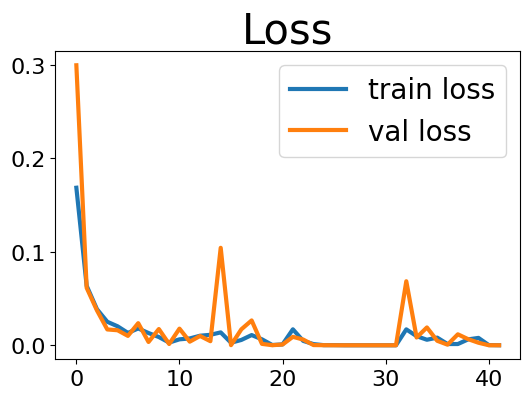

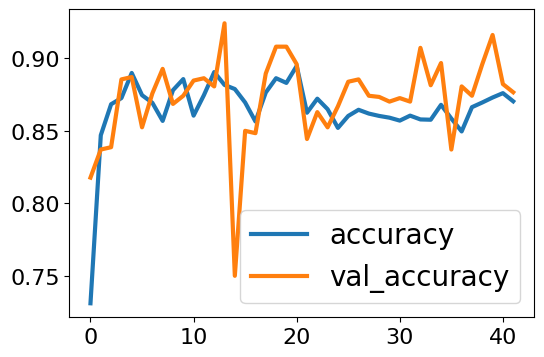

In [31]:
ch.plot_history(history, figsize=(6,4))

In [34]:
#best_model.save("model/mlc_cnn_optuna_randomsampler_v2.4.h5")

INFO:tensorflow:Assets written to: model/mlc_cnn_optuna_randomsampler_v2.4\assets


# 3. Evaluation of the optimized model and saving the results

In [15]:
best_model = load_model("model/mlc_cnn_optuna_randomsampler_v2.4.h5")
best_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_8 (Conv1D)           (None, 913, 64)           576       
                                                                 
 max_pooling1d_8 (MaxPooling  (None, 228, 64)          0         
 1D)                                                             
                                                                 
 batch_normalization_8 (Batc  (None, 228, 64)          256       
 hNormalization)                                                 
                                                                 
 conv1d_9 (Conv1D)           (None, 221, 64)           32832     
                                                                 
 max_pooling1d_9 (MaxPooling  (None, 55, 64)           0         
 1D)                                                             
                                                      

In [16]:
prediction = best_model.predict(x_test)
y_pred = ch.make_pred_mlc(prediction, threshold=0.5)
acc, ham = ch.mlc_result(y_test, y_pred)



acc: 0.92
hamming loss: 0.0145

              precision    recall  f1-score   support

           0      1.000     1.000     1.000        50
           1      0.971     1.000     0.985       100
           2      0.984     0.900     0.940       200
           3      0.985     0.980     0.982       200
           4      0.933     0.830     0.878       100
           5      0.979     0.933     0.956       150
           6      0.993     0.967     0.980       150
           7      0.980     0.972     0.976       250

   micro avg      0.979     0.948     0.963      1200
   macro avg      0.978     0.948     0.962      1200
weighted avg      0.979     0.948     0.963      1200
 samples avg      0.978     0.955     0.962      1200



In [17]:
dfzip = ch.convert_and_zip_label(y_test, y_pred)
ch.cm_multi(dfzip)

Predicted,0,1,2,3,4,5,6,7,14,16,24,27,35,37,246,267,357,Total
True,,,,,,,,,,,,,,,,,,
0,50,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,50
1,0,50,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,50
2,0,1,46,0,1,1,0,0,0,0,1,0,0,0,0,0,0,50
3,0,0,0,50,0,0,0,0,0,0,0,0,0,0,0,0,0,50
4,0,0,0,1,45,0,0,1,0,0,2,0,0,0,0,0,1,50
5,0,0,0,0,0,49,0,0,0,0,0,0,1,0,0,0,0,50
6,0,0,0,0,0,0,50,0,0,0,0,0,0,0,0,0,0,50
7,0,0,0,0,2,0,0,48,0,0,0,0,0,0,0,0,0,50
16,0,3,0,0,0,0,0,0,1,46,0,0,0,0,0,0,0,50


In [19]:
res = ch.collect_results_mlc(y_test, y_pred, algorithm="cnn_optuna_random", params="optuna_random", best_param=best_param)
res

{'algorithm': 'cnn_optuna_random',
 'params': 'optuna_random',
 'best_param': {'filters': 64,
  'kernel_size': 8,
  'maxpool': 4,
  'conv_layer': 4,
  'bn_conv': True,
  'bn_conv_position': 1,
  'dropout': 0.4,
  'dense_layer': 3,
  'bn_dense': False,
  'bn_dense_position': 3,
  'dropout_conv': False,
  'unit1': 240,
  'unit2': 80,
  'unit3': 40,
  'lr': 0.0010639742064577657,
  'batch_size': 16},
 'rec_0': 1.0,
 'pre_0': 1.0,
 'f1_0': 1.0,
 'rec_weighted': 0.9475,
 'pre_weighted': 0.9790312239315184,
 'f1_weighted': 0.9625947604132054,
 'acc': 0.92}

In [20]:
#ch.save_results_json(filename="mlc_algorithm_adaption_hyperopt_results_v2.4.json", 
                     key_algorithm = "cnn_optuna_random", 
                     hyperopt_result = res)

existing file mlc_algorithm_adaption_hyperopt_results_v2.4.json opened and results of cnn_optuna_random saved.
